# Regression: predict fuel efficiency

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of comprehensive data exploration using SparkXshards on Orca. 

It is adapted from [TensorFlow tutorial of basic regression] (https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_regression.ipynb) on auto data. 


In [ ]:
# Use seaborn for some plots
!pip install seaborn pandas numpy

In [ ]:
# import necessary libraries
import bigdl.orca.data.pandas
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.data.transformer import *
from bigdl.orca.learn.tf.estimator import Estimator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow.compat.v1 as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Start an OrcaContext and setup backend using "pandas", then it will use pandas to read each file into a pandas dataframe.

In [ ]:
sc = init_orca_context(memory="4g")
OrcaContext.pandas_read_backend = "pandas"

##  Load data in parallel and get general information

Load data into data_shards, it is a SparkXshards that can be operated on in parallel, here each element of the data_shards is a panda dataframe read from a file on the cluster. Users can distribute local code of `pd.read_csv(dataFile)` using `bigdl.orca.data.pandas.read_csv(datapath)`.

In [ ]:
datapath = './auto-mpg/auto-mpg.csv'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
data_shards = bigdl.orca.data.pandas.read_csv(file_path=datapath, names=column_names,
                                              na_values="?", comment='\t',
                                              sep=" ", skipinitialspace=True)


In [5]:
# show the first couple of rows in the data_shards
data_shards.head(5)

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1

In [6]:
# see the num of partitions of data_shards
data_shards.num_partitions()


1

In [7]:
# count total number of rows in the data_shards
len(data_shards)

398

## Clean the data

The dataset contains a few unknown values, drop them

In [8]:
null_cnt_pdf = data_shards.get_null_sum().sort_values(by="total", ascending=False)
null_cnt_pdf.head(5)

col  total
3    Horsepower      6
0           MPG      0
1     Cylinders      0
2  Displacement      0
4        Weight      0

In [9]:
def drop_na(df):
    df = df.dropna()
    return df
data_shards = data_shards.transform_shard(drop_na)

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [10]:
def generate_extra_cols(df):
    origin = df.pop('Origin')
    df['USA'] = (origin == 1)*1.0
    df['Europe'] = (origin == 2)*1.0
    df['Japan'] = (origin == 3)*1.0
    return df

data_shards = data_shards.transform_shard(generate_extra_cols)

## Inspect the data

Users can compute the descriptive statistics summary of on the full data_shards in a distributed way. For local visualization, users can sample a portion of the data_shards across the cluster into a local panda dataframe, then analyze it using traditional tools like seaborn for plots.

###  Statistics summary  on full data_shards

In [11]:
data_shards.describe()

createDataFrame from shards attempted Arrow optimization failed as: 'NoneType' object has no attribute 'json',Will try without Arrow optimization


summary                MPG           Cylinders        Displacement  \
0   count                392                 392                 392   
1    mean  23.44591836734694   5.471938775510204  194.41198979591837   
2  stddev  7.805007486571802  1.7057832474527845  104.64400390890465   
3     min                9.0                   3                68.0   
4     max               46.6                   8               455.0   

           Horsepower              Weight        Acceleration  \
0                 392                 392                 392   
1  104.46938775510205  2977.5841836734694  15.541326530612228   
2   38.49115993282846   849.4025600429486    2.75886411918808   
3                46.0              1613.0                 8.0   
4               230.0              5140.0                24.8   

          Model Year                  USA               Europe  \
0                392                  392                  392   
1   75.9795918367347                0.625  0.17346938775510204   
2  3.683736543577868  0.48474160596386784   0.3791364586840211   
3                 70                  0.0                  0.0   
4                 82                  1.0                  1.0   

                 Japan  
0                  392  
1  0.20153061224489796  
2  0.40165604004927413  
3                  0.0  
4                  1.0

###  Local visualization

Users can call `data_shards.sample_to_pdf(frac)` to sample a portion of the data_shards and bring back to a panda dataframe on local for visualization. 
Just a few examples are shown in here.

In [12]:
# 0 < frac <= 1, here frac = 1.0 is chosen to collect and show full data.
pdf = data_shards.sample_to_pdf(frac = 1.0)

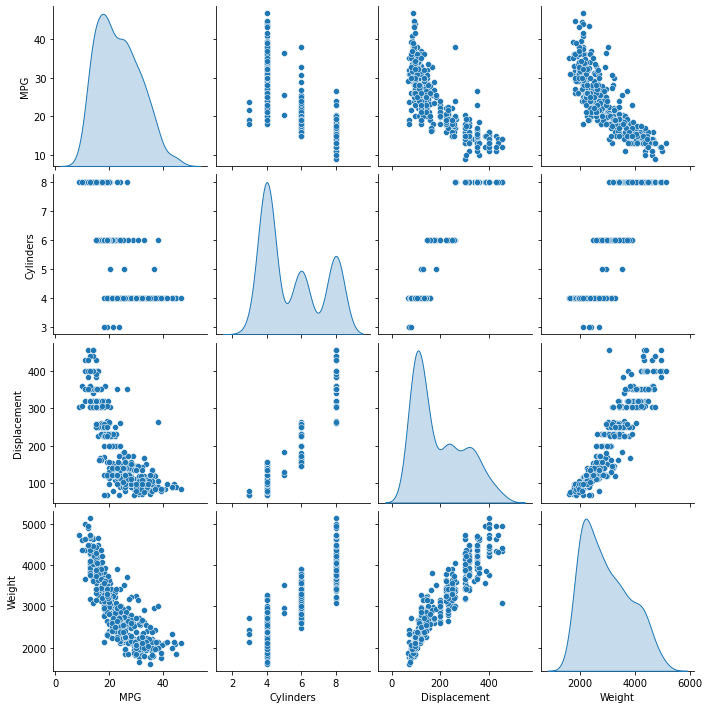

In [13]:
sns.pairplot(pdf[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

Plot scatter plots to show relationship with numerical variables.

## Normalize the data using MinMaxScaler

In [14]:
columns = data_shards.get_schema()['columns']
print(columns)
scaler = MinMaxScaler(inputCol=list(columns[1:]), outputCol="scaled_vec")
data_shards = scaler.fit_transform(data_shards)

['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan']
createDataFrame from shards attempted Arrow optimization failed as: 'NoneType' object has no attribute 'json',Will try without Arrow optimization
create shards from Spark DataFrame attempted Arrow optimization failed as: name 'df' is not defined. Will try without Arrow optimization


## Train validation split

In [15]:
def split_train_test(df):
    train_df = df.sample(frac=0.8, random_state=0)
    test_df = df.drop(train_df.index)
    return train_df, test_df

shards_train, shards_val = data_shards.transform_shard(split_train_test).split()

In [16]:
shards_train.head(5)

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
144  28.0          4          90.0        75.0  2125.0          14.5   
280  22.3          4         140.0        88.0  2890.0          17.3   
68   12.0          8         350.0       160.0  4456.0          13.5   
372  38.0          4         105.0        63.0  2125.0          14.7   
328  33.8          4          97.0        67.0  2145.0          18.0   

     Model Year  USA  Europe  Japan  \
144          74  1.0     0.0    0.0   
280          79  1.0     0.0    0.0   
68           72  1.0     0.0    0.0   
372          82  1.0     0.0    0.0   
328          80  0.0     0.0    1.0   

             081c9e2e-6871-11ed-aba1-dca9048df0d4x_vec  \
144  [4.0, 90.0, 75.0, 2125.0, 14.5, 74.0, 1.0, 0.0...   
280  [4.0, 140.0, 88.0, 2890.0, 17.299999237060547,...   
68   [8.0, 350.0, 160.0, 4456.0, 13.5, 72.0, 1.0, 0...   
372  [4.0, 105.0, 63.0, 2125.0, 14.699999809265137,...   
328  [4.0, 97.0, 67.0, 2145.0, 18.0, 80.0, 0.0, 0.0...   

                                            scaled_vec  
144  [0.20000000298023224, 0.05684754624962807, 0.1...  
280  [0.20000000298023224, 0.1860465109348297, 0.22...  
68   [1.0, 0.7286821603775024, 0.6195651888847351, ...  
372  [0.20000000298023224, 0.09560723602771759, 0.0...  
328  [0.20000000298023224, 0.07493539899587631, 0.1...

In [18]:
print(len(shards_train), len(shards_val))

314 78


## The model

Build the model model as usual. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.


In [19]:
def build_model():
    model = Sequential([
        Dense(64, activation=tf.nn.relu, input_shape=[9]),
        Dense(64, activation=tf.nn.relu),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [ ]:
model = build_model()

In [21]:
est = Estimator.from_keras(keras_model=model)

In [22]:
EPOCHS = 1000
est.fit(data=shards_train,
        batch_size=16,
        epochs=EPOCHS, feature_cols=['scaled_vec'], label_cols=['MPG'])

2022-11-19 17:18:12.265811: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-19 17:18:12.311941: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faee417ae10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-19 17:18:12.311956: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


creating: createFakeOptimMethod
Instructions for updating:
Use `tf.cast` instead.





creating: createTFTrainingHelper
darwin-x86_64/libiomp5.dylib
/Users/guoqiong/opt/anaconda3/envs/py37tf2_x/lib/python3.7/site-packages/bigdl/share/orca/lib/../../tflibs/darwin-x86_64/libiomp5.dylib
got shared path
darwin-x86_64/libmklml.dylib
/Users/guoqiong/opt/anaconda3/envs/py37tf2_x/lib/python3.7/site-packages/bigdl/share/orca/lib/../../tflibs/darwin-x86_64/libmklml.dylib
got shared path
darwin-x86_64/libtensorflow_framework.dylib
/Users/guoqiong/opt/anaconda3/envs/py37tf2_x/lib/python3.7/site-packages/bigdl/share/orca/lib/../../tflibs/darwin-x86_64/libtensorflow_framework.dylib
got shared path
darwin-x86_64/libtensorflow_jni.dylib
/Users/guoqiong/opt/anaconda3/envs/py37tf2_x/lib/python3.7/site-packages/bigdl/share/orca/lib/../../tflibs/darwin-x86_64/libtensorflow_jni.dylib
got shared path


2022-11-19 17:18:13.658222: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 17:18:13.691690: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fadb89d4580 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-19 17:18:13.692035: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


creating: createIdentityCriterion
creating: createTFParkSampleToMiniBatch
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
22-11-19 17:18:13 [Thread-3] INFO  InternalDistriOptimizer$:1009 - TFTrainingHelperV2[TFParkTraining] isTorch is false
22-11-19 17:18:13 [Thread-3] INFO  DistriOptimizer$:830 - caching training rdd ...
22-11-19 17:18:14 [Thread-3] INFO  DistriOptimizer$:655 - Cache thread models...
22-11-19 17:18:14 [Executor task launch worker for task 29] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 284
22-11-19 17:18:14 [Executor task launch worker for task 29] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 284
22-11-19 17:18:14 [Executor task launch worker for task 29] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 284
22-11-19 17:18:14 [Executor task launch worker for task 29] INFO  DistriOptimizer$:638 - model thread pool size is 1
2022-11-19 17:18:14 WARN  BlockManager:66 - Asked to remove block test_0weights0, which does n

22-11-19 17:18:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 2 208/314][Iteration 33][Wall Clock 1.433110294s] Trained 16.0 records in 0.026229144 seconds. Throughput is 610.0085 records/second. Loss is 378.1303. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 2 224/314][Iteration 34][Wall Clock 1.461197623s] Trained 16.0 records in 0.028087329 seconds. Throughput is 569.65186 records/second. Loss is 353.04437. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 2 240/314][Iteration 35][Wall Clock 1.498288472s] Trained 16.0 records in 0.037090849 seconds. Throughput is 431.37326 records/second. Loss is 280.34882. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 2 256/314][Iteration 36][Wall Clock 1.521896624s] Trained 16.0 records in 0.023608152 seconds. Throughput is 677.732 records/second. Loss is 356.74625. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 2 272/314][Iteration 37][Wall Clock 1.545078285s] Trained 1

22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 4 160/314][Iteration 70][Wall Clock 2.310321618s] Trained 16.0 records in 0.022811202 seconds. Throughput is 701.4098 records/second. Loss is 138.13013. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 4 176/314][Iteration 71][Wall Clock 2.340099516s] Trained 16.0 records in 0.029777898 seconds. Throughput is 537.3113 records/second. Loss is 72.569595. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 4 192/314][Iteration 72][Wall Clock 2.358238266s] Trained 16.0 records in 0.01813875 seconds. Throughput is 882.0895 records/second. Loss is 120.98472. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 4 208/314][Iteration 73][Wall Clock 2.376591288s] Trained 16.0 records in 0.018353022 seconds. Throughput is 871.791 records/second. Loss is 116.44795. 
22-11-19 17:18:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 4 224/314][Iteration 74][Wall Clock 2.404590689s] Trained 16.

22-11-19 17:18:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 6 208/314][Iteration 113][Wall Clock 3.366037501s] Trained 16.0 records in 0.023663577 seconds. Throughput is 676.1446 records/second. Loss is 63.433556. 
22-11-19 17:18:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 6 224/314][Iteration 114][Wall Clock 3.386761552s] Trained 16.0 records in 0.020724051 seconds. Throughput is 772.04987 records/second. Loss is 71.768814. 
22-11-19 17:18:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 6 240/314][Iteration 115][Wall Clock 3.411056469s] Trained 16.0 records in 0.024294917 seconds. Throughput is 658.574 records/second. Loss is 50.23094. 
22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 6 256/314][Iteration 116][Wall Clock 3.450669192s] Trained 16.0 records in 0.039612723 seconds. Throughput is 403.91064 records/second. Loss is 46.611263. 
22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 6 272/314][Iteration 117][Wall Clock 3.472386709s] Trai

22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 8 224/314][Iteration 154][Wall Clock 4.226047567s] Trained 16.0 records in 0.018368727 seconds. Throughput is 871.04565 records/second. Loss is 20.458687. 
22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 8 240/314][Iteration 155][Wall Clock 4.242817998s] Trained 16.0 records in 0.016770431 seconds. Throughput is 954.0601 records/second. Loss is 28.986061. 
22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 8 256/314][Iteration 156][Wall Clock 4.260175046s] Trained 16.0 records in 0.017357048 seconds. Throughput is 921.81573 records/second. Loss is 23.39735. 
22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 8 272/314][Iteration 157][Wall Clock 4.276029675s] Trained 16.0 records in 0.015854629 seconds. Throughput is 1009.169 records/second. Loss is 21.846859. 
22-11-19 17:18:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 8 288/314][Iteration 158][Wall Clock 4.294522711s] Tra

22-11-19 17:18:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 10 320/314][Iteration 200][Wall Clock 5.065855016s] Trained 16.0 records in 0.01829405 seconds. Throughput is 874.6013 records/second. Loss is 13.223973. 
22-11-19 17:18:19 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 10 320/314][Iteration 200][Wall Clock 5.065855016s] Epoch finished. Wall clock time is 5074.46341 ms
22-11-19 17:18:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 11 16/314][Iteration 201][Wall Clock 5.092779968s] Trained 16.0 records in 0.018316558 seconds. Throughput is 873.5266 records/second. Loss is 21.183865. 
22-11-19 17:18:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 11 32/314][Iteration 202][Wall Clock 5.116134964s] Trained 16.0 records in 0.023354996 seconds. Throughput is 685.07825 records/second. Loss is 41.8602. 
22-11-19 17:18:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 11 48/314][Iteration 203][Wall Clock 5.141593916s] Trained 16.0 records in 0.025458952 seconds. Throughput is 

22-11-19 17:18:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 12 320/314][Iteration 240][Wall Clock 5.922888837s] Trained 16.0 records in 0.049395504 seconds. Throughput is 323.9161 records/second. Loss is 23.166819. 
22-11-19 17:18:20 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 12 320/314][Iteration 240][Wall Clock 5.922888837s] Epoch finished. Wall clock time is 5933.405539 ms
22-11-19 17:18:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 13 16/314][Iteration 241][Wall Clock 5.957938565s] Trained 16.0 records in 0.024533026 seconds. Throughput is 652.18207 records/second. Loss is 28.31868. 
22-11-19 17:18:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 13 32/314][Iteration 242][Wall Clock 5.987113781s] Trained 16.0 records in 0.029175216 seconds. Throughput is 548.41064 records/second. Loss is 23.883926. 
22-11-19 17:18:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 13 48/314][Iteration 243][Wall Clock 6.011258229s] Trained 16.0 records in 0.024144448 seconds. Throughput

22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 14 272/314][Iteration 277][Wall Clock 6.772231295s] Trained 16.0 records in 0.050386303 seconds. Throughput is 317.54663 records/second. Loss is 19.560028. 
22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 14 288/314][Iteration 278][Wall Clock 6.794211386s] Trained 16.0 records in 0.021980091 seconds. Throughput is 727.93146 records/second. Loss is 6.247467. 
22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 14 304/314][Iteration 279][Wall Clock 6.811986307s] Trained 16.0 records in 0.017774921 seconds. Throughput is 900.14465 records/second. Loss is 13.633537. 
22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 14 320/314][Iteration 280][Wall Clock 6.828044911s] Trained 16.0 records in 0.016058604 seconds. Throughput is 996.35065 records/second. Loss is 8.406944. 
22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 14 320/314][Iteration 280][Wall Clock 6.828044911

22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 16 224/314][Iteration 314][Wall Clock 7.394156277s] Trained 16.0 records in 0.01782937 seconds. Throughput is 897.3957 records/second. Loss is 14.878948. 
22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 16 240/314][Iteration 315][Wall Clock 7.413148443s] Trained 16.0 records in 0.018992166 seconds. Throughput is 842.45264 records/second. Loss is 18.342045. 
22-11-19 17:18:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 16 256/314][Iteration 316][Wall Clock 7.452270358s] Trained 16.0 records in 0.039121915 seconds. Throughput is 408.97794 records/second. Loss is 15.120315. 
22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 16 272/314][Iteration 317][Wall Clock 7.474753872s] Trained 16.0 records in 0.022483514 seconds. Throughput is 711.6325 records/second. Loss is 5.470639. 
22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 16 288/314][Iteration 318][Wall Clock 7.491631975s]

22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 18 160/314][Iteration 350][Wall Clock 8.030875838s] Trained 16.0 records in 0.020457125 seconds. Throughput is 782.1236 records/second. Loss is 14.804987. 
22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 18 176/314][Iteration 351][Wall Clock 8.049453125s] Trained 16.0 records in 0.018577287 seconds. Throughput is 861.2668 records/second. Loss is 9.426048. 
22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 18 192/314][Iteration 352][Wall Clock 8.066196777s] Trained 16.0 records in 0.016743652 seconds. Throughput is 955.586 records/second. Loss is 11.115269. 
22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 18 208/314][Iteration 353][Wall Clock 8.087932142s] Trained 16.0 records in 0.021735365 seconds. Throughput is 736.1275 records/second. Loss is 20.546299. 
22-11-19 17:18:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 18 224/314][Iteration 354][Wall Clock 8.106475608s] T

22-11-19 17:18:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 20 144/314][Iteration 389][Wall Clock 8.907144892s] Trained 16.0 records in 0.017998851 seconds. Throughput is 888.9456 records/second. Loss is 18.439999. 
22-11-19 17:18:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 20 160/314][Iteration 390][Wall Clock 8.922732473s] Trained 16.0 records in 0.015587581 seconds. Throughput is 1026.4581 records/second. Loss is 12.689444. 
22-11-19 17:18:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 20 176/314][Iteration 391][Wall Clock 8.94011618s] Trained 16.0 records in 0.017383707 seconds. Throughput is 920.40204 records/second. Loss is 18.126944. 
22-11-19 17:18:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 20 192/314][Iteration 392][Wall Clock 8.956276064s] Trained 16.0 records in 0.016159884 seconds. Throughput is 990.1061 records/second. Loss is 11.184261. 
22-11-19 17:18:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 20 208/314][Iteration 393][Wall Clock 8.973138254s

22-11-19 17:18:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 22 256/314][Iteration 436][Wall Clock 9.752452198s] Trained 16.0 records in 0.015907604 seconds. Throughput is 1005.8083 records/second. Loss is 17.022608. 
22-11-19 17:18:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 22 272/314][Iteration 437][Wall Clock 9.768116784s] Trained 16.0 records in 0.015664586 seconds. Throughput is 1021.4122 records/second. Loss is 8.566322. 
22-11-19 17:18:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 22 288/314][Iteration 438][Wall Clock 9.783305961s] Trained 16.0 records in 0.015189177 seconds. Throughput is 1053.3816 records/second. Loss is 10.321668. 
22-11-19 17:18:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 22 304/314][Iteration 439][Wall Clock 9.798499765s] Trained 16.0 records in 0.015193804 seconds. Throughput is 1053.0608 records/second. Loss is 15.735985. 
22-11-19 17:18:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 22 320/314][Iteration 440][Wall Clock 9.81460981

22-11-19 17:18:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 24 192/314][Iteration 472][Wall Clock 10.598869117s] Trained 16.0 records in 0.033412207 seconds. Throughput is 478.8669 records/second. Loss is 8.789351. 
22-11-19 17:18:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 24 208/314][Iteration 473][Wall Clock 10.618138228s] Trained 16.0 records in 0.019269111 seconds. Throughput is 830.3445 records/second. Loss is 7.733881. 
22-11-19 17:18:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 24 224/314][Iteration 474][Wall Clock 10.635483873s] Trained 16.0 records in 0.017345645 seconds. Throughput is 922.42175 records/second. Loss is 7.314487. 
22-11-19 17:18:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 24 240/314][Iteration 475][Wall Clock 10.652734974s] Trained 16.0 records in 0.017251101 seconds. Throughput is 927.47705 records/second. Loss is 7.6107297. 
22-11-19 17:18:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 24 256/314][Iteration 476][Wall Clock 10.6684943

22-11-19 17:18:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 26 272/314][Iteration 517][Wall Clock 11.448355058s] Trained 16.0 records in 0.040414621 seconds. Throughput is 395.89633 records/second. Loss is 6.7335715. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 26 288/314][Iteration 518][Wall Clock 11.471663451s] Trained 16.0 records in 0.023308393 seconds. Throughput is 686.448 records/second. Loss is 6.9206347. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 26 304/314][Iteration 519][Wall Clock 11.490855507s] Trained 16.0 records in 0.019192056 seconds. Throughput is 833.6782 records/second. Loss is 9.592937. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 26 320/314][Iteration 520][Wall Clock 11.507632696s] Trained 16.0 records in 0.016777189 seconds. Throughput is 953.67584 records/second. Loss is 2.4938698. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 26 320/314][Iteration 520][Wall Clock 11.507632

22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 28 256/314][Iteration 556][Wall Clock 12.090963931s] Trained 16.0 records in 0.014862447 seconds. Throughput is 1076.5387 records/second. Loss is 7.1993628. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 28 272/314][Iteration 557][Wall Clock 12.109976785s] Trained 16.0 records in 0.019012854 seconds. Throughput is 841.53595 records/second. Loss is 5.950652. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 28 288/314][Iteration 558][Wall Clock 12.127352487s] Trained 16.0 records in 0.017375702 seconds. Throughput is 920.8261 records/second. Loss is 7.873707. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 28 304/314][Iteration 559][Wall Clock 12.14400713s] Trained 16.0 records in 0.016654643 seconds. Throughput is 960.6931 records/second. Loss is 22.786877. 
22-11-19 17:18:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 28 320/314][Iteration 560][Wall Clock 12.1593650

22-11-19 17:18:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 30 320/314][Iteration 600][Wall Clock 12.918643677s] Trained 16.0 records in 0.014179354 seconds. Throughput is 1128.4012 records/second. Loss is 6.749682. 
22-11-19 17:18:27 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 30 320/314][Iteration 600][Wall Clock 12.918643677s] Epoch finished. Wall clock time is 12926.967606 ms
22-11-19 17:18:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 31 16/314][Iteration 601][Wall Clock 12.941731695s] Trained 16.0 records in 0.014764089 seconds. Throughput is 1083.7106 records/second. Loss is 5.835089. 
22-11-19 17:18:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 31 32/314][Iteration 602][Wall Clock 12.956858678s] Trained 16.0 records in 0.015126983 seconds. Throughput is 1057.7126 records/second. Loss is 8.3919115. 
22-11-19 17:18:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 31 48/314][Iteration 603][Wall Clock 12.973326629s] Trained 16.0 records in 0.016467951 seconds. Thro

22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 33 16/314][Iteration 641][Wall Clock 13.558562907s] Trained 16.0 records in 0.016149132 seconds. Throughput is 990.7653 records/second. Loss is 9.039529. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 33 32/314][Iteration 642][Wall Clock 13.573993271s] Trained 16.0 records in 0.015430364 seconds. Throughput is 1036.9166 records/second. Loss is 5.1010394. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 33 48/314][Iteration 643][Wall Clock 13.603108129s] Trained 16.0 records in 0.029114858 seconds. Throughput is 549.5476 records/second. Loss is 5.4773455. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 33 64/314][Iteration 644][Wall Clock 13.618853601s] Trained 16.0 records in 0.015745472 seconds. Throughput is 1016.16516 records/second. Loss is 8.626339. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 33 80/314][Iteration 645][Wall Clock 13.634185522s

22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 35 80/314][Iteration 685][Wall Clock 14.178472093s] Trained 16.0 records in 0.012906672 seconds. Throughput is 1239.6688 records/second. Loss is 8.472469. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 35 96/314][Iteration 686][Wall Clock 14.191703431s] Trained 16.0 records in 0.013231338 seconds. Throughput is 1209.2504 records/second. Loss is 5.1868954. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 35 112/314][Iteration 687][Wall Clock 14.204794025s] Trained 16.0 records in 0.013090594 seconds. Throughput is 1222.2517 records/second. Loss is 11.785987. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 35 128/314][Iteration 688][Wall Clock 14.218257153s] Trained 16.0 records in 0.013463128 seconds. Throughput is 1188.431 records/second. Loss is 10.019861. 
22-11-19 17:18:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 35 144/314][Iteration 689][Wall Clock 14.232505

22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 37 112/314][Iteration 727][Wall Clock 14.783181716s] Trained 16.0 records in 0.012891384 seconds. Throughput is 1241.139 records/second. Loss is 6.6353064. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 37 128/314][Iteration 728][Wall Clock 14.797024942s] Trained 16.0 records in 0.013843226 seconds. Throughput is 1155.7999 records/second. Loss is 3.9106977. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 37 144/314][Iteration 729][Wall Clock 14.809886036s] Trained 16.0 records in 0.012861094 seconds. Throughput is 1244.0621 records/second. Loss is 7.7742157. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 37 160/314][Iteration 730][Wall Clock 14.822967824s] Trained 16.0 records in 0.013081788 seconds. Throughput is 1223.0743 records/second. Loss is 6.9702177. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 37 176/314][Iteration 731][Wall Clock 14.835

22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 39 192/314][Iteration 772][Wall Clock 15.408442731s] Trained 16.0 records in 0.015883969 seconds. Throughput is 1007.30493 records/second. Loss is 6.2179284. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 39 208/314][Iteration 773][Wall Clock 15.422163661s] Trained 16.0 records in 0.01372093 seconds. Throughput is 1166.1018 records/second. Loss is 6.6339025. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 39 224/314][Iteration 774][Wall Clock 15.435410213s] Trained 16.0 records in 0.013246552 seconds. Throughput is 1207.8615 records/second. Loss is 5.6274242. 
22-11-19 17:18:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 39 240/314][Iteration 775][Wall Clock 15.448064199s] Trained 16.0 records in 0.012653986 seconds. Throughput is 1264.4237 records/second. Loss is 8.445433. 
22-11-19 17:18:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 39 256/314][Iteration 776][Wall Clock 15.461

22-11-19 17:18:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 41 288/314][Iteration 818][Wall Clock 16.032552488s] Trained 16.0 records in 0.013544734 seconds. Throughput is 1181.2709 records/second. Loss is 8.805222. 
22-11-19 17:18:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 41 304/314][Iteration 819][Wall Clock 16.046702074s] Trained 16.0 records in 0.014149586 seconds. Throughput is 1130.7751 records/second. Loss is 8.707709. 
22-11-19 17:18:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 41 320/314][Iteration 820][Wall Clock 16.060077246s] Trained 16.0 records in 0.013375172 seconds. Throughput is 1196.2462 records/second. Loss is 2.1465054. 
22-11-19 17:18:30 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 41 320/314][Iteration 820][Wall Clock 16.060077246s] Epoch finished. Wall clock time is 16066.349827 ms
22-11-19 17:18:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 42 16/314][Iteration 821][Wall Clock 16.079736361s] Trained 16.0 records in 0.013386534 seconds. Th

22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 44 32/314][Iteration 862][Wall Clock 16.655669688s] Trained 16.0 records in 0.014392029 seconds. Throughput is 1111.7266 records/second. Loss is 5.353582. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 44 48/314][Iteration 863][Wall Clock 16.6702242s] Trained 16.0 records in 0.014554512 seconds. Throughput is 1099.3154 records/second. Loss is 6.6772814. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 44 64/314][Iteration 864][Wall Clock 16.68353248s] Trained 16.0 records in 0.01330828 seconds. Throughput is 1202.259 records/second. Loss is 7.759712. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 44 80/314][Iteration 865][Wall Clock 16.69678723s] Trained 16.0 records in 0.01325475 seconds. Throughput is 1207.1145 records/second. Loss is 9.543415. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 44 96/314][Iteration 866][Wall Clock 16.710450896s] Train

22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 46 48/314][Iteration 903][Wall Clock 17.26894458s] Trained 16.0 records in 0.016757582 seconds. Throughput is 954.79175 records/second. Loss is 16.946947. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 46 64/314][Iteration 904][Wall Clock 17.289649309s] Trained 16.0 records in 0.020704729 seconds. Throughput is 772.7703 records/second. Loss is 5.6159644. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 46 80/314][Iteration 905][Wall Clock 17.308650964s] Trained 16.0 records in 0.019001655 seconds. Throughput is 842.0319 records/second. Loss is 7.29407. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 46 96/314][Iteration 906][Wall Clock 17.323580284s] Trained 16.0 records in 0.01492932 seconds. Throughput is 1071.7167 records/second. Loss is 5.970048. 
22-11-19 17:18:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 46 112/314][Iteration 907][Wall Clock 17.338164692s] T

22-11-19 17:18:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 48 96/314][Iteration 946][Wall Clock 17.896504196s] Trained 16.0 records in 0.014948647 seconds. Throughput is 1070.331 records/second. Loss is 2.67108. 
22-11-19 17:18:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 48 112/314][Iteration 947][Wall Clock 17.911790466s] Trained 16.0 records in 0.01528627 seconds. Throughput is 1046.6909 records/second. Loss is 3.2811637. 
22-11-19 17:18:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 48 128/314][Iteration 948][Wall Clock 17.926701906s] Trained 16.0 records in 0.01491144 seconds. Throughput is 1073.0017 records/second. Loss is 4.958155. 
22-11-19 17:18:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 48 144/314][Iteration 949][Wall Clock 17.941468241s] Trained 16.0 records in 0.014766335 seconds. Throughput is 1083.5458 records/second. Loss is 13.370518. 
22-11-19 17:18:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 48 160/314][Iteration 950][Wall Clock 17.956065348

22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 50 176/314][Iteration 991][Wall Clock 18.517066092s] Trained 16.0 records in 0.012992637 seconds. Throughput is 1231.4667 records/second. Loss is 10.033949. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 50 192/314][Iteration 992][Wall Clock 18.530027889s] Trained 16.0 records in 0.012961797 seconds. Throughput is 1234.3967 records/second. Loss is 2.37185. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 50 208/314][Iteration 993][Wall Clock 18.543178435s] Trained 16.0 records in 0.013150546 seconds. Throughput is 1216.6796 records/second. Loss is 3.5209181. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 50 224/314][Iteration 994][Wall Clock 18.556176008s] Trained 16.0 records in 0.012997573 seconds. Throughput is 1230.999 records/second. Loss is 9.248049. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 50 240/314][Iteration 995][Wall Clock 18.568736

22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 52 272/314][Iteration 1037][Wall Clock 19.137732708s] Trained 16.0 records in 0.013292702 seconds. Throughput is 1203.668 records/second. Loss is 8.089032. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 52 288/314][Iteration 1038][Wall Clock 19.150412133s] Trained 16.0 records in 0.012679425 seconds. Throughput is 1261.8868 records/second. Loss is 6.6929255. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 52 304/314][Iteration 1039][Wall Clock 19.162829391s] Trained 16.0 records in 0.012417258 seconds. Throughput is 1288.5293 records/second. Loss is 5.9003487. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 52 320/314][Iteration 1040][Wall Clock 19.175461686s] Trained 16.0 records in 0.012632295 seconds. Throughput is 1266.595 records/second. Loss is 9.436191. 
22-11-19 17:18:33 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 52 320/314][Iteration 1040][Wall Clock 19.1

22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 55 80/314][Iteration 1085][Wall Clock 19.766243119s] Trained 16.0 records in 0.013225027 seconds. Throughput is 1209.8274 records/second. Loss is 10.006398. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 55 96/314][Iteration 1086][Wall Clock 19.778872636s] Trained 16.0 records in 0.012629517 seconds. Throughput is 1266.8734 records/second. Loss is 8.319977. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 55 112/314][Iteration 1087][Wall Clock 19.791411386s] Trained 16.0 records in 0.01253875 seconds. Throughput is 1276.0443 records/second. Loss is 9.14637. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 55 128/314][Iteration 1088][Wall Clock 19.804394738s] Trained 16.0 records in 0.012983352 seconds. Throughput is 1232.3474 records/second. Loss is 6.194137. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 55 144/314][Iteration 1089][Wall Clock 19.8169

22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 57 192/314][Iteration 1132][Wall Clock 20.395016087s] Trained 16.0 records in 0.013428659 seconds. Throughput is 1191.4816 records/second. Loss is 3.7267184. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 57 208/314][Iteration 1133][Wall Clock 20.407650699s] Trained 16.0 records in 0.012634612 seconds. Throughput is 1266.3627 records/second. Loss is 7.717675. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 57 224/314][Iteration 1134][Wall Clock 20.420148058s] Trained 16.0 records in 0.012497359 seconds. Throughput is 1280.2705 records/second. Loss is 6.264664. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 57 240/314][Iteration 1135][Wall Clock 20.433259999s] Trained 16.0 records in 0.013111941 seconds. Throughput is 1220.2618 records/second. Loss is 2.7341137. 
22-11-19 17:18:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 57 256/314][Iteration 1136][Wall Clock 20

22-11-19 17:18:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 59 304/314][Iteration 1179][Wall Clock 21.028849796s] Trained 16.0 records in 0.01356507 seconds. Throughput is 1179.5 records/second. Loss is 12.521219. 
22-11-19 17:18:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 59 320/314][Iteration 1180][Wall Clock 21.041664558s] Trained 16.0 records in 0.012814762 seconds. Throughput is 1248.56 records/second. Loss is 8.446642. 
22-11-19 17:18:35 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 59 320/314][Iteration 1180][Wall Clock 21.041664558s] Epoch finished. Wall clock time is 21047.791088 ms
22-11-19 17:18:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 60 16/314][Iteration 1181][Wall Clock 21.060682756s] Trained 16.0 records in 0.012891668 seconds. Throughput is 1241.1117 records/second. Loss is 8.132167. 
22-11-19 17:18:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 60 32/314][Iteration 1182][Wall Clock 21.073257442s] Trained 16.0 records in 0.012574686 seconds. Thro

22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 62 80/314][Iteration 1225][Wall Clock 21.654195582s] Trained 16.0 records in 0.012620767 seconds. Throughput is 1267.7518 records/second. Loss is 3.4772358. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 62 96/314][Iteration 1226][Wall Clock 21.666921006s] Trained 16.0 records in 0.012725424 seconds. Throughput is 1257.3254 records/second. Loss is 10.051037. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 62 112/314][Iteration 1227][Wall Clock 21.679826741s] Trained 16.0 records in 0.012905735 seconds. Throughput is 1239.7589 records/second. Loss is 9.78326. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 62 128/314][Iteration 1228][Wall Clock 21.692532004s] Trained 16.0 records in 0.012705263 seconds. Throughput is 1259.3207 records/second. Loss is 9.983234. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 62 144/314][Iteration 1229][Wall Clock 21.70

22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 64 192/314][Iteration 1272][Wall Clock 22.276094764s] Trained 16.0 records in 0.013179603 seconds. Throughput is 1213.9971 records/second. Loss is 6.238886. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 64 208/314][Iteration 1273][Wall Clock 22.28866524s] Trained 16.0 records in 0.012570476 seconds. Throughput is 1272.8237 records/second. Loss is 18.41244. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 64 224/314][Iteration 1274][Wall Clock 22.30123021s] Trained 16.0 records in 0.01256497 seconds. Throughput is 1273.3815 records/second. Loss is 6.071125. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 64 240/314][Iteration 1275][Wall Clock 22.314114753s] Trained 16.0 records in 0.012884543 seconds. Throughput is 1241.798 records/second. Loss is 6.2745743. 
22-11-19 17:18:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 64 256/314][Iteration 1276][Wall Clock 22.3262

22-11-19 17:18:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 66 288/314][Iteration 1318][Wall Clock 22.897579974s] Trained 16.0 records in 0.013771615 seconds. Throughput is 1161.81 records/second. Loss is 10.278016. 
22-11-19 17:18:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 66 304/314][Iteration 1319][Wall Clock 22.910535852s] Trained 16.0 records in 0.012955878 seconds. Throughput is 1234.9607 records/second. Loss is 4.799635. 
22-11-19 17:18:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 66 320/314][Iteration 1320][Wall Clock 22.923361506s] Trained 16.0 records in 0.012825654 seconds. Throughput is 1247.4998 records/second. Loss is 7.699502. 
22-11-19 17:18:37 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 66 320/314][Iteration 1320][Wall Clock 22.923361506s] Epoch finished. Wall clock time is 22929.36984 ms
22-11-19 17:18:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 67 16/314][Iteration 1321][Wall Clock 22.942012027s] Trained 16.0 records in 0.012642187 seconds. 

22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 69 64/314][Iteration 1364][Wall Clock 23.521812723s] Trained 16.0 records in 0.013367335 seconds. Throughput is 1196.9476 records/second. Loss is 8.064391. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 69 80/314][Iteration 1365][Wall Clock 23.534740028s] Trained 16.0 records in 0.012927305 seconds. Throughput is 1237.6903 records/second. Loss is 6.0493355. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 69 96/314][Iteration 1366][Wall Clock 23.547667683s] Trained 16.0 records in 0.012927655 seconds. Throughput is 1237.6567 records/second. Loss is 11.895784. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 69 112/314][Iteration 1367][Wall Clock 23.56156319s] Trained 16.0 records in 0.013895507 seconds. Throughput is 1151.4513 records/second. Loss is 6.7180448. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 69 128/314][Iteration 1368][Wall Clock 23.57

22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 71 144/314][Iteration 1409][Wall Clock 24.149311792s] Trained 16.0 records in 0.017855955 seconds. Throughput is 896.0596 records/second. Loss is 3.2325842. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 71 160/314][Iteration 1410][Wall Clock 24.164740423s] Trained 16.0 records in 0.015428631 seconds. Throughput is 1037.0331 records/second. Loss is 9.618227. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 71 176/314][Iteration 1411][Wall Clock 24.178288175s] Trained 16.0 records in 0.013547752 seconds. Throughput is 1181.0077 records/second. Loss is 8.006134. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 71 192/314][Iteration 1412][Wall Clock 24.192872314s] Trained 16.0 records in 0.014584139 seconds. Throughput is 1097.0823 records/second. Loss is 3.9505005. 
22-11-19 17:18:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 71 208/314][Iteration 1413][Wall Clock 24.

22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 73 272/314][Iteration 1457][Wall Clock 24.764711115s] Trained 16.0 records in 0.012262133 seconds. Throughput is 1304.8301 records/second. Loss is 9.426103. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 73 288/314][Iteration 1458][Wall Clock 24.777819823s] Trained 16.0 records in 0.013108708 seconds. Throughput is 1220.5627 records/second. Loss is 8.702969. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 73 304/314][Iteration 1459][Wall Clock 24.790166511s] Trained 16.0 records in 0.012346688 seconds. Throughput is 1295.8942 records/second. Loss is 6.091051. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 73 320/314][Iteration 1460][Wall Clock 24.802857927s] Trained 16.0 records in 0.012691416 seconds. Throughput is 1260.6947 records/second. Loss is 5.2677555. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 73 320/314][Iteration 1460][Wall Clock 24.

22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 76 80/314][Iteration 1505][Wall Clock 25.390363011s] Trained 16.0 records in 0.012210992 seconds. Throughput is 1310.2948 records/second. Loss is 2.9516149. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 76 96/314][Iteration 1506][Wall Clock 25.403126195s] Trained 16.0 records in 0.012763184 seconds. Throughput is 1253.6057 records/second. Loss is 1.5650733. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 76 112/314][Iteration 1507][Wall Clock 25.415539653s] Trained 16.0 records in 0.012413458 seconds. Throughput is 1288.9237 records/second. Loss is 7.7655315. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 76 128/314][Iteration 1508][Wall Clock 25.428141629s] Trained 16.0 records in 0.012601976 seconds. Throughput is 1269.6421 records/second. Loss is 19.008963. 
22-11-19 17:18:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 76 144/314][Iteration 1509][Wall Clock 25

22-11-19 17:18:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 78 192/314][Iteration 1552][Wall Clock 26.008181898s] Trained 16.0 records in 0.012233944 seconds. Throughput is 1307.8367 records/second. Loss is 5.421819. 
22-11-19 17:18:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 78 208/314][Iteration 1553][Wall Clock 26.021727813s] Trained 16.0 records in 0.013545915 seconds. Throughput is 1181.168 records/second. Loss is 10.491991. 
22-11-19 17:18:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 78 224/314][Iteration 1554][Wall Clock 26.035055555s] Trained 16.0 records in 0.013327742 seconds. Throughput is 1200.5034 records/second. Loss is 4.445983. 
22-11-19 17:18:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 78 240/314][Iteration 1555][Wall Clock 26.048091401s] Trained 16.0 records in 0.013035846 seconds. Throughput is 1227.3849 records/second. Loss is 5.312725. 
22-11-19 17:18:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 78 256/314][Iteration 1556][Wall Clock 26.0

22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 80 272/314][Iteration 1597][Wall Clock 26.628195509s] Trained 16.0 records in 0.012559966 seconds. Throughput is 1273.8888 records/second. Loss is 8.811299. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 80 288/314][Iteration 1598][Wall Clock 26.640689643s] Trained 16.0 records in 0.012494134 seconds. Throughput is 1280.601 records/second. Loss is 4.515139. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 80 304/314][Iteration 1599][Wall Clock 26.65284729s] Trained 16.0 records in 0.012157647 seconds. Throughput is 1316.0442 records/second. Loss is 3.9560375. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 80 320/314][Iteration 1600][Wall Clock 26.665364294s] Trained 16.0 records in 0.012517004 seconds. Throughput is 1278.2611 records/second. Loss is 4.1977277. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 80 320/314][Iteration 1600][Wall Clock 26.6

22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 83 80/314][Iteration 1645][Wall Clock 27.245163094s] Trained 16.0 records in 0.012400624 seconds. Throughput is 1290.2576 records/second. Loss is 5.6112556. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 83 96/314][Iteration 1646][Wall Clock 27.257550862s] Trained 16.0 records in 0.012387768 seconds. Throughput is 1291.5967 records/second. Loss is 5.952485. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 83 112/314][Iteration 1647][Wall Clock 27.270209372s] Trained 16.0 records in 0.01265851 seconds. Throughput is 1263.9718 records/second. Loss is 4.942806. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 83 128/314][Iteration 1648][Wall Clock 27.283065481s] Trained 16.0 records in 0.012856109 seconds. Throughput is 1244.5446 records/second. Loss is 4.7560587. 
22-11-19 17:18:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 83 144/314][Iteration 1649][Wall Clock 27.29

22-11-19 17:18:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 85 192/314][Iteration 1692][Wall Clock 27.878953646s] Trained 16.0 records in 0.013349774 seconds. Throughput is 1198.5221 records/second. Loss is 13.024065. 
22-11-19 17:18:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 85 208/314][Iteration 1693][Wall Clock 27.891568966s] Trained 16.0 records in 0.01261532 seconds. Throughput is 1268.2992 records/second. Loss is 4.235274. 
22-11-19 17:18:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 85 224/314][Iteration 1694][Wall Clock 27.904239846s] Trained 16.0 records in 0.01267088 seconds. Throughput is 1262.7378 records/second. Loss is 4.6908755. 
22-11-19 17:18:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 85 240/314][Iteration 1695][Wall Clock 27.916609701s] Trained 16.0 records in 0.012369855 seconds. Throughput is 1293.467 records/second. Loss is 8.974602. 
22-11-19 17:18:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 85 256/314][Iteration 1696][Wall Clock 27.92

22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 87 320/314][Iteration 1740][Wall Clock 28.498054792s] Trained 16.0 records in 0.012888199 seconds. Throughput is 1241.4458 records/second. Loss is 3.914892. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 87 320/314][Iteration 1740][Wall Clock 28.498054792s] Epoch finished. Wall clock time is 28503.645534 ms
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 88 16/314][Iteration 1741][Wall Clock 28.516263943s] Trained 16.0 records in 0.012618409 seconds. Throughput is 1267.9888 records/second. Loss is 3.916837. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 88 32/314][Iteration 1742][Wall Clock 28.529492536s] Trained 16.0 records in 0.013228593 seconds. Throughput is 1209.5012 records/second. Loss is 10.755731. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 88 48/314][Iteration 1743][Wall Clock 28.542488001s] Trained 16.0 records in 0.012995465 seconds.

22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 90 96/314][Iteration 1786][Wall Clock 29.114373681s] Trained 16.0 records in 0.016564986 seconds. Throughput is 965.89276 records/second. Loss is 6.080737. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 90 112/314][Iteration 1787][Wall Clock 29.127419695s] Trained 16.0 records in 0.013046014 seconds. Throughput is 1226.4282 records/second. Loss is 6.5942564. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 90 128/314][Iteration 1788][Wall Clock 29.141600933s] Trained 16.0 records in 0.014181238 seconds. Throughput is 1128.2513 records/second. Loss is 6.588768. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 90 144/314][Iteration 1789][Wall Clock 29.15552133s] Trained 16.0 records in 0.013920397 seconds. Throughput is 1149.3926 records/second. Loss is 6.1234307. 
22-11-19 17:18:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 90 160/314][Iteration 1790][Wall Clock 29.1

22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 92 192/314][Iteration 1832][Wall Clock 29.734993446s] Trained 16.0 records in 0.013098635 seconds. Throughput is 1221.5013 records/second. Loss is 10.990355. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 92 208/314][Iteration 1833][Wall Clock 29.747176468s] Trained 16.0 records in 0.012183022 seconds. Throughput is 1313.3031 records/second. Loss is 6.887052. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 92 224/314][Iteration 1834][Wall Clock 29.759471129s] Trained 16.0 records in 0.012294661 seconds. Throughput is 1301.3778 records/second. Loss is 4.0528736. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 92 240/314][Iteration 1835][Wall Clock 29.772219766s] Trained 16.0 records in 0.012748637 seconds. Throughput is 1255.0361 records/second. Loss is 3.4379308. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 92 256/314][Iteration 1836][Wall Clock 2

22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 94 320/314][Iteration 1880][Wall Clock 30.364017812s] Trained 16.0 records in 0.012840974 seconds. Throughput is 1246.0114 records/second. Loss is 3.3646955. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 94 320/314][Iteration 1880][Wall Clock 30.364017812s] Epoch finished. Wall clock time is 30369.679384 ms
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 95 16/314][Iteration 1881][Wall Clock 30.381943099s] Trained 16.0 records in 0.012263715 seconds. Throughput is 1304.6617 records/second. Loss is 10.974797. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 95 32/314][Iteration 1882][Wall Clock 30.39420628s] Trained 16.0 records in 0.012263181 seconds. Throughput is 1304.7186 records/second. Loss is 4.862766. 
22-11-19 17:18:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 95 48/314][Iteration 1883][Wall Clock 30.406918914s] Trained 16.0 records in 0.012712634 seconds.

22-11-19 17:18:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 97 96/314][Iteration 1926][Wall Clock 30.988379716s] Trained 16.0 records in 0.013086485 seconds. Throughput is 1222.6355 records/second. Loss is 7.360523. 
22-11-19 17:18:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 97 112/314][Iteration 1927][Wall Clock 31.000555039s] Trained 16.0 records in 0.012175323 seconds. Throughput is 1314.1334 records/second. Loss is 8.535252. 
22-11-19 17:18:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 97 128/314][Iteration 1928][Wall Clock 31.012504713s] Trained 16.0 records in 0.011949674 seconds. Throughput is 1338.9486 records/second. Loss is 5.441001. 
22-11-19 17:18:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 97 144/314][Iteration 1929][Wall Clock 31.024602295s] Trained 16.0 records in 0.012097582 seconds. Throughput is 1322.5784 records/second. Loss is 8.394858. 
22-11-19 17:18:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 97 160/314][Iteration 1930][Wall Clock 31.03

22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 99 192/314][Iteration 1972][Wall Clock 31.61411448s] Trained 16.0 records in 0.012214554 seconds. Throughput is 1309.9128 records/second. Loss is 21.5731. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 99 208/314][Iteration 1973][Wall Clock 31.627547163s] Trained 16.0 records in 0.013432683 seconds. Throughput is 1191.1246 records/second. Loss is 5.518787. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 99 224/314][Iteration 1974][Wall Clock 31.639996787s] Trained 16.0 records in 0.012449624 seconds. Throughput is 1285.1793 records/second. Loss is 4.0738726. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 99 240/314][Iteration 1975][Wall Clock 31.652408852s] Trained 16.0 records in 0.012412065 seconds. Throughput is 1289.0684 records/second. Loss is 2.053006. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 99 256/314][Iteration 1976][Wall Clock 31.66

22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 101 288/314][Iteration 2018][Wall Clock 32.246770847s] Trained 16.0 records in 0.012898556 seconds. Throughput is 1240.449 records/second. Loss is 2.3659432. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 101 304/314][Iteration 2019][Wall Clock 32.259421268s] Trained 16.0 records in 0.012650421 seconds. Throughput is 1264.78 records/second. Loss is 2.8992445. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 101 320/314][Iteration 2020][Wall Clock 32.271931093s] Trained 16.0 records in 0.012509825 seconds. Throughput is 1278.9948 records/second. Loss is 9.007483. 
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 101 320/314][Iteration 2020][Wall Clock 32.271931093s] Epoch finished. Wall clock time is 32277.969903 ms
22-11-19 17:18:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 102 16/314][Iteration 2021][Wall Clock 32.290536014s] Trained 16.0 records in 0.012566111 sec

22-11-19 17:18:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 104 96/314][Iteration 2066][Wall Clock 32.877350313s] Trained 16.0 records in 0.012090409 seconds. Throughput is 1323.363 records/second. Loss is 5.176914. 
22-11-19 17:18:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 104 112/314][Iteration 2067][Wall Clock 32.890484545s] Trained 16.0 records in 0.013134232 seconds. Throughput is 1218.1908 records/second. Loss is 8.3396015. 
22-11-19 17:18:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 104 128/314][Iteration 2068][Wall Clock 32.903285032s] Trained 16.0 records in 0.012800487 seconds. Throughput is 1249.9525 records/second. Loss is 7.877942. 
22-11-19 17:18:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 104 144/314][Iteration 2069][Wall Clock 32.915935261s] Trained 16.0 records in 0.012650229 seconds. Throughput is 1264.7992 records/second. Loss is 9.137943. 
22-11-19 17:18:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 104 160/314][Iteration 2070][Wall Clock 

22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 106 224/314][Iteration 2114][Wall Clock 33.491537336s] Trained 16.0 records in 0.011802972 seconds. Throughput is 1355.5907 records/second. Loss is 6.1499624. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 106 240/314][Iteration 2115][Wall Clock 33.50409247s] Trained 16.0 records in 0.012555134 seconds. Throughput is 1274.3792 records/second. Loss is 3.5816708. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 106 256/314][Iteration 2116][Wall Clock 33.516219926s] Trained 16.0 records in 0.012127456 seconds. Throughput is 1319.3203 records/second. Loss is 4.7075653. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 106 272/314][Iteration 2117][Wall Clock 33.5292476s] Trained 16.0 records in 0.013027674 seconds. Throughput is 1228.1548 records/second. Loss is 4.7161283. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 106 288/314][Iteration 2118][Wall Cloc

22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 109 32/314][Iteration 2162][Wall Clock 34.109821595s] Trained 16.0 records in 0.014532871 seconds. Throughput is 1100.9525 records/second. Loss is 6.0468564. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 109 48/314][Iteration 2163][Wall Clock 34.122272313s] Trained 16.0 records in 0.012450718 seconds. Throughput is 1285.0664 records/second. Loss is 9.974488. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 109 64/314][Iteration 2164][Wall Clock 34.135287522s] Trained 16.0 records in 0.013015209 seconds. Throughput is 1229.331 records/second. Loss is 7.234399. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 109 80/314][Iteration 2165][Wall Clock 34.148250864s] Trained 16.0 records in 0.012963342 seconds. Throughput is 1234.2496 records/second. Loss is 5.527548. 
22-11-19 17:18:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 109 96/314][Iteration 2166][Wall Clock 34.1

22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 111 160/314][Iteration 2210][Wall Clock 34.714598383s] Trained 16.0 records in 0.012152839 seconds. Throughput is 1316.5647 records/second. Loss is 9.331683. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 111 176/314][Iteration 2211][Wall Clock 34.726855187s] Trained 16.0 records in 0.012256804 seconds. Throughput is 1305.3975 records/second. Loss is 12.070498. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 111 192/314][Iteration 2212][Wall Clock 34.739254014s] Trained 16.0 records in 0.012398827 seconds. Throughput is 1290.4447 records/second. Loss is 11.495264. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 111 208/314][Iteration 2213][Wall Clock 34.751772917s] Trained 16.0 records in 0.012518903 seconds. Throughput is 1278.0673 records/second. Loss is 8.559492. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 111 224/314][Iteration 2214][Wall Clo

22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 113 304/314][Iteration 2259][Wall Clock 35.338412515s] Trained 16.0 records in 0.013064894 seconds. Throughput is 1224.656 records/second. Loss is 8.518181. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 113 320/314][Iteration 2260][Wall Clock 35.350523679s] Trained 16.0 records in 0.012111164 seconds. Throughput is 1321.0952 records/second. Loss is 8.95496. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 113 320/314][Iteration 2260][Wall Clock 35.350523679s] Epoch finished. Wall clock time is 35356.105487 ms
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 114 16/314][Iteration 2261][Wall Clock 35.368651203s] Trained 16.0 records in 0.012545716 seconds. Throughput is 1275.3357 records/second. Loss is 4.953103. 
22-11-19 17:18:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 114 32/314][Iteration 2262][Wall Clock 35.380808927s] Trained 16.0 records in 0.012157724 secon

22-11-19 17:18:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 116 96/314][Iteration 2306][Wall Clock 35.950304288s] Trained 16.0 records in 0.012085693 seconds. Throughput is 1323.8794 records/second. Loss is 9.335245. 
22-11-19 17:18:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 116 112/314][Iteration 2307][Wall Clock 35.96314749s] Trained 16.0 records in 0.012843202 seconds. Throughput is 1245.7953 records/second. Loss is 7.026935. 
22-11-19 17:18:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 116 128/314][Iteration 2308][Wall Clock 35.975619702s] Trained 16.0 records in 0.012472212 seconds. Throughput is 1282.8518 records/second. Loss is 8.146949. 
22-11-19 17:18:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 116 144/314][Iteration 2309][Wall Clock 35.98804012s] Trained 16.0 records in 0.012420418 seconds. Throughput is 1288.2014 records/second. Loss is 3.4034843. 
22-11-19 17:18:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 116 160/314][Iteration 2310][Wall Clock 3

22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 118 192/314][Iteration 2352][Wall Clock 36.568629624s] Trained 16.0 records in 0.012096023 seconds. Throughput is 1322.7488 records/second. Loss is 4.58959. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 118 208/314][Iteration 2353][Wall Clock 36.581128225s] Trained 16.0 records in 0.012498601 seconds. Throughput is 1280.1432 records/second. Loss is 6.7684526. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 118 224/314][Iteration 2354][Wall Clock 36.593148722s] Trained 16.0 records in 0.012020497 seconds. Throughput is 1331.0598 records/second. Loss is 6.235659. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 118 240/314][Iteration 2355][Wall Clock 36.605578364s] Trained 16.0 records in 0.012429642 seconds. Throughput is 1287.2455 records/second. Loss is 5.7422757. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 118 256/314][Iteration 2356][Wall Cloc

22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 121 16/314][Iteration 2401][Wall Clock 37.204991465s] Trained 16.0 records in 0.012884289 seconds. Throughput is 1241.8225 records/second. Loss is 7.9058037. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 121 32/314][Iteration 2402][Wall Clock 37.21710309s] Trained 16.0 records in 0.012111625 seconds. Throughput is 1321.0449 records/second. Loss is 4.7110624. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 121 48/314][Iteration 2403][Wall Clock 37.229283216s] Trained 16.0 records in 0.012180126 seconds. Throughput is 1313.6152 records/second. Loss is 2.3473926. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 121 64/314][Iteration 2404][Wall Clock 37.241611218s] Trained 16.0 records in 0.012328002 seconds. Throughput is 1297.8584 records/second. Loss is 8.483898. 
22-11-19 17:18:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 121 80/314][Iteration 2405][Wall Clock 37

22-11-19 17:18:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 123 176/314][Iteration 2451][Wall Clock 37.839389935s] Trained 16.0 records in 0.012534507 seconds. Throughput is 1276.4762 records/second. Loss is 8.177162. 
22-11-19 17:18:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 123 192/314][Iteration 2452][Wall Clock 37.851652469s] Trained 16.0 records in 0.012262534 seconds. Throughput is 1304.7874 records/second. Loss is 7.961627. 
22-11-19 17:18:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 123 208/314][Iteration 2453][Wall Clock 37.863869258s] Trained 16.0 records in 0.012216789 seconds. Throughput is 1309.6731 records/second. Loss is 7.469475. 
22-11-19 17:18:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 123 224/314][Iteration 2454][Wall Clock 37.876230956s] Trained 16.0 records in 0.012361698 seconds. Throughput is 1294.3206 records/second. Loss is 10.127249. 
22-11-19 17:18:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 123 240/314][Iteration 2455][Wall Cloc

22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 125 304/314][Iteration 2499][Wall Clock 38.458489032s] Trained 16.0 records in 0.013495468 seconds. Throughput is 1185.5833 records/second. Loss is 3.5111458. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 125 320/314][Iteration 2500][Wall Clock 38.472491853s] Trained 16.0 records in 0.014002821 seconds. Throughput is 1142.6268 records/second. Loss is 3.8108048. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 125 320/314][Iteration 2500][Wall Clock 38.472491853s] Epoch finished. Wall clock time is 38478.358398 ms
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 126 16/314][Iteration 2501][Wall Clock 38.492011137s] Trained 16.0 records in 0.013652739 seconds. Throughput is 1171.926 records/second. Loss is 16.597996. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 126 32/314][Iteration 2502][Wall Clock 38.505332953s] Trained 16.0 records in 0.013321816 s

22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 128 96/314][Iteration 2546][Wall Clock 39.074373751s] Trained 16.0 records in 0.012333289 seconds. Throughput is 1297.302 records/second. Loss is 6.8593245. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 128 112/314][Iteration 2547][Wall Clock 39.087467929s] Trained 16.0 records in 0.013094178 seconds. Throughput is 1221.9171 records/second. Loss is 5.4507484. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 128 128/314][Iteration 2548][Wall Clock 39.100017856s] Trained 16.0 records in 0.012549927 seconds. Throughput is 1274.9077 records/second. Loss is 14.973991. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 128 144/314][Iteration 2549][Wall Clock 39.113200042s] Trained 16.0 records in 0.013182186 seconds. Throughput is 1213.7593 records/second. Loss is 4.739498. 
22-11-19 17:18:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 128 160/314][Iteration 2550][Wall Cloc

22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 130 208/314][Iteration 2593][Wall Clock 39.686237296s] Trained 16.0 records in 0.012368412 seconds. Throughput is 1293.618 records/second. Loss is 3.4803753. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 130 224/314][Iteration 2594][Wall Clock 39.699318577s] Trained 16.0 records in 0.013081281 seconds. Throughput is 1223.1217 records/second. Loss is 7.724046. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 130 240/314][Iteration 2595][Wall Clock 39.711393744s] Trained 16.0 records in 0.012075167 seconds. Throughput is 1325.0334 records/second. Loss is 4.395254. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 130 256/314][Iteration 2596][Wall Clock 39.733831498s] Trained 16.0 records in 0.022437754 seconds. Throughput is 713.08386 records/second. Loss is 5.49022. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 130 272/314][Iteration 2597][Wall Clock 

22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 132 320/314][Iteration 2640][Wall Clock 40.304571154s] Trained 16.0 records in 0.01502693 seconds. Throughput is 1064.7551 records/second. Loss is 3.354155. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 132 320/314][Iteration 2640][Wall Clock 40.304571154s] Epoch finished. Wall clock time is 40310.04948 ms
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 133 16/314][Iteration 2641][Wall Clock 40.323398334s] Trained 16.0 records in 0.013348854 seconds. Throughput is 1198.6047 records/second. Loss is 4.8243985. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 133 32/314][Iteration 2642][Wall Clock 40.343172545s] Trained 16.0 records in 0.019774211 seconds. Throughput is 809.13464 records/second. Loss is 8.40526. 
22-11-19 17:18:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 133 48/314][Iteration 2643][Wall Clock 40.357944573s] Trained 16.0 records in 0.014772028 second

22-11-19 17:18:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 135 64/314][Iteration 2684][Wall Clock 40.93936271s] Trained 16.0 records in 0.015873291 seconds. Throughput is 1007.98254 records/second. Loss is 5.5177536. 
22-11-19 17:18:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 135 80/314][Iteration 2685][Wall Clock 40.954973945s] Trained 16.0 records in 0.015611235 seconds. Throughput is 1024.903 records/second. Loss is 6.9593935. 
22-11-19 17:18:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 135 96/314][Iteration 2686][Wall Clock 40.972290618s] Trained 16.0 records in 0.017316673 seconds. Throughput is 923.965 records/second. Loss is 4.5996156. 
22-11-19 17:18:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 135 112/314][Iteration 2687][Wall Clock 40.986786148s] Trained 16.0 records in 0.01449553 seconds. Throughput is 1103.7886 records/second. Loss is 3.4047062. 
22-11-19 17:18:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 135 128/314][Iteration 2688][Wall Clock 41

22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 137 128/314][Iteration 2728][Wall Clock 41.550666236s] Trained 16.0 records in 0.013283135 seconds. Throughput is 1204.5349 records/second. Loss is 7.2104163. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 137 144/314][Iteration 2729][Wall Clock 41.564685176s] Trained 16.0 records in 0.01401894 seconds. Throughput is 1141.3131 records/second. Loss is 14.064513. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 137 160/314][Iteration 2730][Wall Clock 41.577093657s] Trained 16.0 records in 0.012408481 seconds. Throughput is 1289.4407 records/second. Loss is 2.6780024. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 137 176/314][Iteration 2731][Wall Clock 41.589324533s] Trained 16.0 records in 0.012230876 seconds. Throughput is 1308.1647 records/second. Loss is 5.841079. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 137 192/314][Iteration 2732][Wall Clo

22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 139 272/314][Iteration 2777][Wall Clock 42.171184289s] Trained 16.0 records in 0.012522854 seconds. Throughput is 1277.6641 records/second. Loss is 3.9671683. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 139 288/314][Iteration 2778][Wall Clock 42.183072345s] Trained 16.0 records in 0.011888056 seconds. Throughput is 1345.8887 records/second. Loss is 4.2715473. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 139 304/314][Iteration 2779][Wall Clock 42.194752979s] Trained 16.0 records in 0.011680634 seconds. Throughput is 1369.7887 records/second. Loss is 11.114778. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 139 320/314][Iteration 2780][Wall Clock 42.206894123s] Trained 16.0 records in 0.012141144 seconds. Throughput is 1317.833 records/second. Loss is 13.854432. 
22-11-19 17:18:56 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 139 320/314][Iteration 2780][Wall Cl

22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 142 48/314][Iteration 2823][Wall Clock 42.792266328s] Trained 16.0 records in 0.012431688 seconds. Throughput is 1287.0336 records/second. Loss is 11.910085. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 142 64/314][Iteration 2824][Wall Clock 42.804319167s] Trained 16.0 records in 0.012052839 seconds. Throughput is 1327.4882 records/second. Loss is 5.40708. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 142 80/314][Iteration 2825][Wall Clock 42.816570228s] Trained 16.0 records in 0.012251061 seconds. Throughput is 1306.0093 records/second. Loss is 4.3727875. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 142 96/314][Iteration 2826][Wall Clock 42.828945472s] Trained 16.0 records in 0.012375244 seconds. Throughput is 1292.9038 records/second. Loss is 6.199689. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 142 112/314][Iteration 2827][Wall Clock 42

22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 144 208/314][Iteration 2873][Wall Clock 43.417851663s] Trained 16.0 records in 0.01204922 seconds. Throughput is 1327.8868 records/second. Loss is 15.770532. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 144 224/314][Iteration 2874][Wall Clock 43.430150287s] Trained 16.0 records in 0.012298624 seconds. Throughput is 1300.9585 records/second. Loss is 7.155739. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 144 240/314][Iteration 2875][Wall Clock 43.442564114s] Trained 16.0 records in 0.012413827 seconds. Throughput is 1288.8854 records/second. Loss is 6.0107336. 
22-11-19 17:18:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 144 256/314][Iteration 2876][Wall Clock 43.454514669s] Trained 16.0 records in 0.011950555 seconds. Throughput is 1338.85 records/second. Loss is 3.0698662. 
22-11-19 17:18:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 144 272/314][Iteration 2877][Wall Clock

22-11-19 17:18:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 147 48/314][Iteration 2923][Wall Clock 44.039805959s] Trained 16.0 records in 0.012362758 seconds. Throughput is 1294.2096 records/second. Loss is 4.5549784. 
22-11-19 17:18:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 147 64/314][Iteration 2924][Wall Clock 44.051378328s] Trained 16.0 records in 0.011572369 seconds. Throughput is 1382.6036 records/second. Loss is 4.7784967. 
22-11-19 17:18:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 147 80/314][Iteration 2925][Wall Clock 44.063138306s] Trained 16.0 records in 0.011759978 seconds. Throughput is 1360.5468 records/second. Loss is 1.8216832. 
22-11-19 17:18:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 147 96/314][Iteration 2926][Wall Clock 44.075316566s] Trained 16.0 records in 0.01217826 seconds. Throughput is 1313.8167 records/second. Loss is 7.4299083. 
22-11-19 17:18:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 147 112/314][Iteration 2927][Wall Clock 

22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 149 224/314][Iteration 2974][Wall Clock 44.655019033s] Trained 16.0 records in 0.012353747 seconds. Throughput is 1295.1536 records/second. Loss is 6.267297. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 149 240/314][Iteration 2975][Wall Clock 44.679536348s] Trained 16.0 records in 0.024517315 seconds. Throughput is 652.60004 records/second. Loss is 8.741843. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 149 256/314][Iteration 2976][Wall Clock 44.692729756s] Trained 16.0 records in 0.013193408 seconds. Throughput is 1212.7268 records/second. Loss is 6.2022276. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 149 272/314][Iteration 2977][Wall Clock 44.705811526s] Trained 16.0 records in 0.01308177 seconds. Throughput is 1223.076 records/second. Loss is 9.8404875. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 149 288/314][Iteration 2978][Wall Clock

22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 152 32/314][Iteration 3022][Wall Clock 45.280362748s] Trained 16.0 records in 0.013646672 seconds. Throughput is 1172.447 records/second. Loss is 12.535503. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 152 48/314][Iteration 3023][Wall Clock 45.293641608s] Trained 16.0 records in 0.01327886 seconds. Throughput is 1204.9227 records/second. Loss is 8.900116. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 152 64/314][Iteration 3024][Wall Clock 45.306516894s] Trained 16.0 records in 0.012875286 seconds. Throughput is 1242.6908 records/second. Loss is 9.520092. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 152 80/314][Iteration 3025][Wall Clock 45.319392575s] Trained 16.0 records in 0.012875681 seconds. Throughput is 1242.6527 records/second. Loss is 6.72164. 
22-11-19 17:18:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 152 96/314][Iteration 3026][Wall Clock 45.331

22-11-19 17:19:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 154 192/314][Iteration 3072][Wall Clock 45.908902899s] Trained 16.0 records in 0.013615781 seconds. Throughput is 1175.1069 records/second. Loss is 4.1136217. 
22-11-19 17:19:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 154 208/314][Iteration 3073][Wall Clock 45.92121784s] Trained 16.0 records in 0.012314941 seconds. Throughput is 1299.2349 records/second. Loss is 3.4489512. 
22-11-19 17:19:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 154 224/314][Iteration 3074][Wall Clock 45.934094717s] Trained 16.0 records in 0.012876877 seconds. Throughput is 1242.5374 records/second. Loss is 7.0946465. 
22-11-19 17:19:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 154 240/314][Iteration 3075][Wall Clock 45.946786278s] Trained 16.0 records in 0.012691561 seconds. Throughput is 1260.6802 records/second. Loss is 14.921034. 
22-11-19 17:19:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 154 256/314][Iteration 3076][Wall Cl

22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 157 32/314][Iteration 3122][Wall Clock 46.536248727s] Trained 16.0 records in 0.012303039 seconds. Throughput is 1300.4917 records/second. Loss is 3.3974373. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 157 48/314][Iteration 3123][Wall Clock 46.548492904s] Trained 16.0 records in 0.012244177 seconds. Throughput is 1306.7437 records/second. Loss is 4.082688. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 157 64/314][Iteration 3124][Wall Clock 46.560325403s] Trained 16.0 records in 0.011832499 seconds. Throughput is 1352.208 records/second. Loss is 7.245635. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 157 80/314][Iteration 3125][Wall Clock 46.573258146s] Trained 16.0 records in 0.012932743 seconds. Throughput is 1237.1699 records/second. Loss is 3.4297957. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 157 96/314][Iteration 3126][Wall Clock 46.

22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 159 160/314][Iteration 3170][Wall Clock 47.14883896s] Trained 16.0 records in 0.012414936 seconds. Throughput is 1288.7703 records/second. Loss is 8.578344. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 159 176/314][Iteration 3171][Wall Clock 47.160372019s] Trained 16.0 records in 0.011533059 seconds. Throughput is 1387.3162 records/second. Loss is 6.7533607. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 159 192/314][Iteration 3172][Wall Clock 47.172577825s] Trained 16.0 records in 0.012205806 seconds. Throughput is 1310.8516 records/second. Loss is 5.6473994. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 159 208/314][Iteration 3173][Wall Clock 47.185039854s] Trained 16.0 records in 0.012462029 seconds. Throughput is 1283.9 records/second. Loss is 5.863889. 
22-11-19 17:19:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 159 224/314][Iteration 3174][Wall Clock 4

22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 161 320/314][Iteration 3220][Wall Clock 47.781093681s] Trained 16.0 records in 0.012442767 seconds. Throughput is 1285.8877 records/second. Loss is 4.1491766. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 161 320/314][Iteration 3220][Wall Clock 47.781093681s] Epoch finished. Wall clock time is 47786.375304 ms
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 162 16/314][Iteration 3221][Wall Clock 47.798310739s] Trained 16.0 records in 0.011935435 seconds. Throughput is 1340.546 records/second. Loss is 7.33969. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 162 32/314][Iteration 3222][Wall Clock 47.81030816s] Trained 16.0 records in 0.011997421 seconds. Throughput is 1333.6199 records/second. Loss is 13.653466. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 162 48/314][Iteration 3223][Wall Clock 47.822195628s] Trained 16.0 records in 0.011887468 secon

22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 164 144/314][Iteration 3269][Wall Clock 48.401156697s] Trained 16.0 records in 0.013521822 seconds. Throughput is 1183.2725 records/second. Loss is 11.823719. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 164 160/314][Iteration 3270][Wall Clock 48.413392776s] Trained 16.0 records in 0.012236079 seconds. Throughput is 1307.6084 records/second. Loss is 4.269813. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 164 176/314][Iteration 3271][Wall Clock 48.425443513s] Trained 16.0 records in 0.012050737 seconds. Throughput is 1327.7196 records/second. Loss is 3.233202. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 164 192/314][Iteration 3272][Wall Clock 48.438882892s] Trained 16.0 records in 0.013439379 seconds. Throughput is 1190.5312 records/second. Loss is 7.1009884. 
22-11-19 17:19:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 164 208/314][Iteration 3273][Wall Clo

22-11-19 17:19:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 166 288/314][Iteration 3318][Wall Clock 49.019593705s] Trained 16.0 records in 0.014432872 seconds. Throughput is 1108.5804 records/second. Loss is 6.761482. 
22-11-19 17:19:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 166 304/314][Iteration 3319][Wall Clock 49.03379317s] Trained 16.0 records in 0.014199465 seconds. Throughput is 1126.8031 records/second. Loss is 10.403113. 
22-11-19 17:19:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 166 320/314][Iteration 3320][Wall Clock 49.045521541s] Trained 16.0 records in 0.011728371 seconds. Throughput is 1364.2134 records/second. Loss is 10.388003. 
22-11-19 17:19:03 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 166 320/314][Iteration 3320][Wall Clock 49.045521541s] Epoch finished. Wall clock time is 49050.859827 ms
22-11-19 17:19:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 167 16/314][Iteration 3321][Wall Clock 49.063268962s] Trained 16.0 records in 0.012409135 s

22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 169 80/314][Iteration 3365][Wall Clock 49.639985532s] Trained 16.0 records in 0.012126679 seconds. Throughput is 1319.405 records/second. Loss is 18.841393. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 169 96/314][Iteration 3366][Wall Clock 49.651890127s] Trained 16.0 records in 0.011904595 seconds. Throughput is 1344.0188 records/second. Loss is 4.2386. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 169 112/314][Iteration 3367][Wall Clock 49.663767099s] Trained 16.0 records in 0.011876972 seconds. Throughput is 1347.1447 records/second. Loss is 5.395721. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 169 128/314][Iteration 3368][Wall Clock 49.676363992s] Trained 16.0 records in 0.012596893 seconds. Throughput is 1270.1544 records/second. Loss is 1.8967412. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 169 144/314][Iteration 3369][Wall Clock 49

22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 171 256/314][Iteration 3416][Wall Clock 50.254298659s] Trained 16.0 records in 0.012395886 seconds. Throughput is 1290.7509 records/second. Loss is 19.083363. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 171 272/314][Iteration 3417][Wall Clock 50.266584409s] Trained 16.0 records in 0.01228575 seconds. Throughput is 1302.3218 records/second. Loss is 1.5733299. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 171 288/314][Iteration 3418][Wall Clock 50.278731842s] Trained 16.0 records in 0.012147433 seconds. Throughput is 1317.1508 records/second. Loss is 2.1964118. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 171 304/314][Iteration 3419][Wall Clock 50.302901533s] Trained 16.0 records in 0.024169691 seconds. Throughput is 661.98615 records/second. Loss is 6.6374044. 
22-11-19 17:19:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 171 320/314][Iteration 3420][Wall Cl

22-11-19 17:19:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 174 96/314][Iteration 3466][Wall Clock 50.869258037s] Trained 16.0 records in 0.013089261 seconds. Throughput is 1222.3761 records/second. Loss is 3.7071168. 
22-11-19 17:19:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 174 112/314][Iteration 3467][Wall Clock 50.881901599s] Trained 16.0 records in 0.012643562 seconds. Throughput is 1265.4662 records/second. Loss is 14.713808. 
22-11-19 17:19:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 174 128/314][Iteration 3468][Wall Clock 50.894172232s] Trained 16.0 records in 0.012270633 seconds. Throughput is 1303.9261 records/second. Loss is 4.3626423. 
22-11-19 17:19:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 174 144/314][Iteration 3469][Wall Clock 50.906723545s] Trained 16.0 records in 0.012551313 seconds. Throughput is 1274.767 records/second. Loss is 2.0502229. 
22-11-19 17:19:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 174 160/314][Iteration 3470][Wall Clo

22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 176 272/314][Iteration 3517][Wall Clock 51.511071894s] Trained 16.0 records in 0.012932392 seconds. Throughput is 1237.2035 records/second. Loss is 6.261292. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 176 288/314][Iteration 3518][Wall Clock 51.523103831s] Trained 16.0 records in 0.012031937 seconds. Throughput is 1329.7942 records/second. Loss is 4.502634. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 176 304/314][Iteration 3519][Wall Clock 51.535843234s] Trained 16.0 records in 0.012739403 seconds. Throughput is 1255.9458 records/second. Loss is 8.734714. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 176 320/314][Iteration 3520][Wall Clock 51.548560549s] Trained 16.0 records in 0.012717315 seconds. Throughput is 1258.1272 records/second. Loss is 7.706991. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 176 320/314][Iteration 3520][Wall Clock

22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 179 112/314][Iteration 3567][Wall Clock 52.127990646s] Trained 16.0 records in 0.011825766 seconds. Throughput is 1352.9779 records/second. Loss is 6.91043. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 179 128/314][Iteration 3568][Wall Clock 52.140746469s] Trained 16.0 records in 0.012755823 seconds. Throughput is 1254.3291 records/second. Loss is 1.4662455. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 179 144/314][Iteration 3569][Wall Clock 52.153148045s] Trained 16.0 records in 0.012401576 seconds. Throughput is 1290.1586 records/second. Loss is 19.283775. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 179 160/314][Iteration 3570][Wall Clock 52.165108928s] Trained 16.0 records in 0.011960883 seconds. Throughput is 1337.694 records/second. Loss is 6.8780494. 
22-11-19 17:19:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 179 176/314][Iteration 3571][Wall Cloc

22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 181 272/314][Iteration 3617][Wall Clock 52.743702728s] Trained 16.0 records in 0.013058275 seconds. Throughput is 1225.2767 records/second. Loss is 1.8415518. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 181 288/314][Iteration 3618][Wall Clock 52.755868798s] Trained 16.0 records in 0.01216607 seconds. Throughput is 1315.133 records/second. Loss is 7.772395. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 181 304/314][Iteration 3619][Wall Clock 52.770029117s] Trained 16.0 records in 0.014160319 seconds. Throughput is 1129.918 records/second. Loss is 7.851704. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 181 320/314][Iteration 3620][Wall Clock 52.784071081s] Trained 16.0 records in 0.014041964 seconds. Throughput is 1139.4418 records/second. Loss is 12.681589. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 181 320/314][Iteration 3620][Wall Clock 

22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 184 128/314][Iteration 3668][Wall Clock 53.364904291s] Trained 16.0 records in 0.012637631 seconds. Throughput is 1266.06 records/second. Loss is 6.051531. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 184 144/314][Iteration 3669][Wall Clock 53.379388174s] Trained 16.0 records in 0.014483883 seconds. Throughput is 1104.6761 records/second. Loss is 4.700827. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 184 160/314][Iteration 3670][Wall Clock 53.391015611s] Trained 16.0 records in 0.011627437 seconds. Throughput is 1376.0557 records/second. Loss is 6.0502973. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 184 176/314][Iteration 3671][Wall Clock 53.41470214s] Trained 16.0 records in 0.023686529 seconds. Throughput is 675.48944 records/second. Loss is 12.758999. 
22-11-19 17:19:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 184 192/314][Iteration 3672][Wall Clock 

22-11-19 17:19:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 186 288/314][Iteration 3718][Wall Clock 53.97480285s] Trained 16.0 records in 0.012147823 seconds. Throughput is 1317.1084 records/second. Loss is 8.7006. 
22-11-19 17:19:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 186 304/314][Iteration 3719][Wall Clock 53.987108957s] Trained 16.0 records in 0.012306107 seconds. Throughput is 1300.1675 records/second. Loss is 11.481978. 
22-11-19 17:19:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 186 320/314][Iteration 3720][Wall Clock 54.002688426s] Trained 16.0 records in 0.015579469 seconds. Throughput is 1026.9927 records/second. Loss is 4.486994. 
22-11-19 17:19:08 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 186 320/314][Iteration 3720][Wall Clock 54.002688426s] Epoch finished. Wall clock time is 54007.897196 ms
22-11-19 17:19:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 187 16/314][Iteration 3721][Wall Clock 54.02781135s] Trained 16.0 records in 0.019914154 secon

22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 189 64/314][Iteration 3764][Wall Clock 54.59230089s] Trained 16.0 records in 0.011670509 seconds. Throughput is 1370.977 records/second. Loss is 11.325115. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 189 80/314][Iteration 3765][Wall Clock 54.604628581s] Trained 16.0 records in 0.012327691 seconds. Throughput is 1297.8911 records/second. Loss is 4.246231. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 189 96/314][Iteration 3766][Wall Clock 54.616432636s] Trained 16.0 records in 0.011804055 seconds. Throughput is 1355.4663 records/second. Loss is 2.654851. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 189 112/314][Iteration 3767][Wall Clock 54.628827734s] Trained 16.0 records in 0.012395098 seconds. Throughput is 1290.8329 records/second. Loss is 6.0997496. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 189 128/314][Iteration 3768][Wall Clock 54

22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 191 240/314][Iteration 3815][Wall Clock 55.213174305s] Trained 16.0 records in 0.012017976 seconds. Throughput is 1331.339 records/second. Loss is 1.7439824. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 191 256/314][Iteration 3816][Wall Clock 55.225083855s] Trained 16.0 records in 0.01190955 seconds. Throughput is 1343.4596 records/second. Loss is 11.431253. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 191 272/314][Iteration 3817][Wall Clock 55.237335224s] Trained 16.0 records in 0.012251369 seconds. Throughput is 1305.9766 records/second. Loss is 4.923344. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 191 288/314][Iteration 3818][Wall Clock 55.250465907s] Trained 16.0 records in 0.013130683 seconds. Throughput is 1218.52 records/second. Loss is 7.6879053. 
22-11-19 17:19:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 191 304/314][Iteration 3819][Wall Clock 

22-11-19 17:19:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 194 48/314][Iteration 3863][Wall Clock 55.831121204s] Trained 16.0 records in 0.022356528 seconds. Throughput is 715.6746 records/second. Loss is 5.3285728. 
22-11-19 17:19:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 194 64/314][Iteration 3864][Wall Clock 55.844858434s] Trained 16.0 records in 0.01373723 seconds. Throughput is 1164.7181 records/second. Loss is 5.4210744. 
22-11-19 17:19:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 194 80/314][Iteration 3865][Wall Clock 55.857486989s] Trained 16.0 records in 0.012628555 seconds. Throughput is 1266.97 records/second. Loss is 6.3968706. 
22-11-19 17:19:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 194 96/314][Iteration 3866][Wall Clock 55.869096589s] Trained 16.0 records in 0.0116096 seconds. Throughput is 1378.1698 records/second. Loss is 3.006601. 
22-11-19 17:19:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 194 112/314][Iteration 3867][Wall Clock 55.881

22-11-19 17:19:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 196 192/314][Iteration 3912][Wall Clock 56.451262483s] Trained 16.0 records in 0.012387981 seconds. Throughput is 1291.5745 records/second. Loss is 10.163763. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 196 208/314][Iteration 3913][Wall Clock 56.46361684s] Trained 16.0 records in 0.012354357 seconds. Throughput is 1295.0896 records/second. Loss is 2.8903825. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 196 224/314][Iteration 3914][Wall Clock 56.476539889s] Trained 16.0 records in 0.012923049 seconds. Throughput is 1238.0979 records/second. Loss is 3.9913604. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 196 240/314][Iteration 3915][Wall Clock 56.488536816s] Trained 16.0 records in 0.011996927 seconds. Throughput is 1333.6749 records/second. Loss is 4.7739043. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 196 256/314][Iteration 3916][Wall Cl

22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 199 32/314][Iteration 3962][Wall Clock 57.078434743s] Trained 16.0 records in 0.012456529 seconds. Throughput is 1284.467 records/second. Loss is 13.065877. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 199 48/314][Iteration 3963][Wall Clock 57.090356083s] Trained 16.0 records in 0.01192134 seconds. Throughput is 1342.131 records/second. Loss is 5.186961. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 199 64/314][Iteration 3964][Wall Clock 57.102005835s] Trained 16.0 records in 0.011649752 seconds. Throughput is 1373.4198 records/second. Loss is 6.2863955. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 199 80/314][Iteration 3965][Wall Clock 57.114242045s] Trained 16.0 records in 0.01223621 seconds. Throughput is 1307.5945 records/second. Loss is 9.509048. 
22-11-19 17:19:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 199 96/314][Iteration 3966][Wall Clock 57.125

22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 201 192/314][Iteration 4012][Wall Clock 57.688030604s] Trained 16.0 records in 0.011408787 seconds. Throughput is 1402.4277 records/second. Loss is 1.4484947. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 201 208/314][Iteration 4013][Wall Clock 57.700226112s] Trained 16.0 records in 0.012195508 seconds. Throughput is 1311.9585 records/second. Loss is 8.124704. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 201 224/314][Iteration 4014][Wall Clock 57.712230825s] Trained 16.0 records in 0.012004713 seconds. Throughput is 1332.8099 records/second. Loss is 6.3927054. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 201 240/314][Iteration 4015][Wall Clock 57.724233807s] Trained 16.0 records in 0.012002982 seconds. Throughput is 1333.0021 records/second. Loss is 3.4755921. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 201 256/314][Iteration 4016][Wall Cl

22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 204 32/314][Iteration 4062][Wall Clock 58.3051678s] Trained 16.0 records in 0.012065483 seconds. Throughput is 1326.0969 records/second. Loss is 7.6311274. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 204 48/314][Iteration 4063][Wall Clock 58.317259962s] Trained 16.0 records in 0.012092162 seconds. Throughput is 1323.1711 records/second. Loss is 9.559338. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 204 64/314][Iteration 4064][Wall Clock 58.328874289s] Trained 16.0 records in 0.011614327 seconds. Throughput is 1377.6089 records/second. Loss is 2.711014. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 204 80/314][Iteration 4065][Wall Clock 58.340780308s] Trained 16.0 records in 0.011906019 seconds. Throughput is 1343.858 records/second. Loss is 2.265706. 
22-11-19 17:19:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 204 96/314][Iteration 4066][Wall Clock 58.352

22-11-19 17:19:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 206 208/314][Iteration 4113][Wall Clock 58.916397925s] Trained 16.0 records in 0.012620879 seconds. Throughput is 1267.7405 records/second. Loss is 3.6911578. 
22-11-19 17:19:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 206 224/314][Iteration 4114][Wall Clock 58.928409794s] Trained 16.0 records in 0.012011869 seconds. Throughput is 1332.0159 records/second. Loss is 2.8876328. 
22-11-19 17:19:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 206 240/314][Iteration 4115][Wall Clock 58.940221736s] Trained 16.0 records in 0.011811942 seconds. Throughput is 1354.5614 records/second. Loss is 2.7999039. 
22-11-19 17:19:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 206 256/314][Iteration 4116][Wall Clock 58.952163917s] Trained 16.0 records in 0.011942181 seconds. Throughput is 1339.7888 records/second. Loss is 4.7554026. 
22-11-19 17:19:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 206 272/314][Iteration 4117][Wall C

22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 209 48/314][Iteration 4163][Wall Clock 59.527743487s] Trained 16.0 records in 0.011641059 seconds. Throughput is 1374.4454 records/second. Loss is 10.245703. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 209 64/314][Iteration 4164][Wall Clock 59.53974823s] Trained 16.0 records in 0.012004743 seconds. Throughput is 1332.8065 records/second. Loss is 11.273987. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 209 80/314][Iteration 4165][Wall Clock 59.551674484s] Trained 16.0 records in 0.011926254 seconds. Throughput is 1341.578 records/second. Loss is 5.7763515. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 209 96/314][Iteration 4166][Wall Clock 59.564235895s] Trained 16.0 records in 0.012561411 seconds. Throughput is 1273.7423 records/second. Loss is 1.669883. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 209 112/314][Iteration 4167][Wall Clock 59

22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 211 208/314][Iteration 4213][Wall Clock 60.136772363s] Trained 16.0 records in 0.01150935 seconds. Throughput is 1390.1741 records/second. Loss is 6.1221933. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 211 224/314][Iteration 4214][Wall Clock 60.149031536s] Trained 16.0 records in 0.012259173 seconds. Throughput is 1305.1451 records/second. Loss is 2.4298854. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 211 240/314][Iteration 4215][Wall Clock 60.161241004s] Trained 16.0 records in 0.012209468 seconds. Throughput is 1310.4585 records/second. Loss is 3.8775868. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 211 256/314][Iteration 4216][Wall Clock 60.17306796s] Trained 16.0 records in 0.011826956 seconds. Throughput is 1352.8418 records/second. Loss is 8.572965. 
22-11-19 17:19:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 211 272/314][Iteration 4217][Wall Cloc

22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 214 48/314][Iteration 4263][Wall Clock 60.760262218s] Trained 16.0 records in 0.011818789 seconds. Throughput is 1353.7766 records/second. Loss is 3.5391037. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 214 64/314][Iteration 4264][Wall Clock 60.772171793s] Trained 16.0 records in 0.011909575 seconds. Throughput is 1343.4568 records/second. Loss is 8.355121. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 214 80/314][Iteration 4265][Wall Clock 60.783628538s] Trained 16.0 records in 0.011456745 seconds. Throughput is 1396.5573 records/second. Loss is 6.06523. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 214 96/314][Iteration 4266][Wall Clock 60.79533834s] Trained 16.0 records in 0.011709802 seconds. Throughput is 1366.3767 records/second. Loss is 4.2078357. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 214 112/314][Iteration 4267][Wall Clock 60.

22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 216 208/314][Iteration 4313][Wall Clock 61.37140362s] Trained 16.0 records in 0.011495276 seconds. Throughput is 1391.8761 records/second. Loss is 5.426642. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 216 224/314][Iteration 4314][Wall Clock 61.383379168s] Trained 16.0 records in 0.011975548 seconds. Throughput is 1336.0558 records/second. Loss is 10.731285. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 216 240/314][Iteration 4315][Wall Clock 61.394857012s] Trained 16.0 records in 0.011477844 seconds. Throughput is 1393.99 records/second. Loss is 9.43941. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 216 256/314][Iteration 4316][Wall Clock 61.406498419s] Trained 16.0 records in 0.011641407 seconds. Throughput is 1374.4043 records/second. Loss is 3.146339. 
22-11-19 17:19:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 216 272/314][Iteration 4317][Wall Clock 61

22-11-19 17:19:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 219 64/314][Iteration 4364][Wall Clock 61.988842232s] Trained 16.0 records in 0.011685659 seconds. Throughput is 1369.1996 records/second. Loss is 3.4268231. 
22-11-19 17:19:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 219 80/314][Iteration 4365][Wall Clock 62.000637632s] Trained 16.0 records in 0.0117954 seconds. Throughput is 1356.461 records/second. Loss is 8.283675. 
22-11-19 17:19:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 219 96/314][Iteration 4366][Wall Clock 62.012297356s] Trained 16.0 records in 0.011659724 seconds. Throughput is 1372.2452 records/second. Loss is 3.5563197. 
22-11-19 17:19:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 219 112/314][Iteration 4367][Wall Clock 62.024828772s] Trained 16.0 records in 0.012531416 seconds. Throughput is 1276.7911 records/second. Loss is 17.578444. 
22-11-19 17:19:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 219 128/314][Iteration 4368][Wall Clock 62

22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 221 224/314][Iteration 4414][Wall Clock 62.59888847s] Trained 16.0 records in 0.012211397 seconds. Throughput is 1310.2513 records/second. Loss is 6.0854554. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 221 240/314][Iteration 4415][Wall Clock 62.610736849s] Trained 16.0 records in 0.011848379 seconds. Throughput is 1350.3958 records/second. Loss is 4.0494847. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 221 256/314][Iteration 4416][Wall Clock 62.622864595s] Trained 16.0 records in 0.012127746 seconds. Throughput is 1319.2888 records/second. Loss is 2.9084585. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 221 272/314][Iteration 4417][Wall Clock 62.63541141s] Trained 16.0 records in 0.012546815 seconds. Throughput is 1275.224 records/second. Loss is 1.5048405. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 221 288/314][Iteration 4418][Wall Cloc

22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 224 64/314][Iteration 4464][Wall Clock 63.215072265s] Trained 16.0 records in 0.011444165 seconds. Throughput is 1398.0923 records/second. Loss is 5.8893347. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 224 80/314][Iteration 4465][Wall Clock 63.227141035s] Trained 16.0 records in 0.01206877 seconds. Throughput is 1325.7357 records/second. Loss is 8.07489. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 224 96/314][Iteration 4466][Wall Clock 63.238950126s] Trained 16.0 records in 0.011809091 seconds. Throughput is 1354.8883 records/second. Loss is 3.4178913. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 224 112/314][Iteration 4467][Wall Clock 63.250869097s] Trained 16.0 records in 0.011918971 seconds. Throughput is 1342.3977 records/second. Loss is 2.3537393. 
22-11-19 17:19:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 224 128/314][Iteration 4468][Wall Clock 6

22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 226 224/314][Iteration 4514][Wall Clock 63.823582473s] Trained 16.0 records in 0.011416087 seconds. Throughput is 1401.531 records/second. Loss is 4.3711805. 
22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 226 240/314][Iteration 4515][Wall Clock 63.835621503s] Trained 16.0 records in 0.01203903 seconds. Throughput is 1329.0107 records/second. Loss is 13.092399. 
22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 226 256/314][Iteration 4516][Wall Clock 63.846944961s] Trained 16.0 records in 0.011323458 seconds. Throughput is 1412.996 records/second. Loss is 6.7779217. 
22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 226 272/314][Iteration 4517][Wall Clock 63.858754631s] Trained 16.0 records in 0.01180967 seconds. Throughput is 1354.8219 records/second. Loss is 5.250803. 
22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 226 288/314][Iteration 4518][Wall Clock 

22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 229 64/314][Iteration 4564][Wall Clock 64.432215518s] Trained 16.0 records in 0.011519726 seconds. Throughput is 1388.9219 records/second. Loss is 5.089374. 
22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 229 80/314][Iteration 4565][Wall Clock 64.444392848s] Trained 16.0 records in 0.01217733 seconds. Throughput is 1313.9169 records/second. Loss is 4.22403. 
22-11-19 17:19:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 229 96/314][Iteration 4566][Wall Clock 64.456007356s] Trained 16.0 records in 0.011614508 seconds. Throughput is 1377.5874 records/second. Loss is 3.9272852. 
22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 229 112/314][Iteration 4567][Wall Clock 64.468146512s] Trained 16.0 records in 0.012139156 seconds. Throughput is 1318.0487 records/second. Loss is 6.447937. 
22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 229 128/314][Iteration 4568][Wall Clock 64.

22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 231 240/314][Iteration 4615][Wall Clock 65.036744873s] Trained 16.0 records in 0.011892463 seconds. Throughput is 1345.3899 records/second. Loss is 10.09845. 
22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 231 256/314][Iteration 4616][Wall Clock 65.048550001s] Trained 16.0 records in 0.011805128 seconds. Throughput is 1355.3431 records/second. Loss is 20.075535. 
22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 231 272/314][Iteration 4617][Wall Clock 65.060459346s] Trained 16.0 records in 0.011909345 seconds. Throughput is 1343.4828 records/second. Loss is 2.675422. 
22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 231 288/314][Iteration 4618][Wall Clock 65.073261779s] Trained 16.0 records in 0.012802433 seconds. Throughput is 1249.7625 records/second. Loss is 16.894402. 
22-11-19 17:19:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 231 304/314][Iteration 4619][Wall Clo

22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 234 80/314][Iteration 4665][Wall Clock 65.650462976s] Trained 16.0 records in 0.011558824 seconds. Throughput is 1384.2239 records/second. Loss is 4.367609. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 234 96/314][Iteration 4666][Wall Clock 65.662423079s] Trained 16.0 records in 0.011960103 seconds. Throughput is 1337.7811 records/second. Loss is 4.518503. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 234 112/314][Iteration 4667][Wall Clock 65.674532583s] Trained 16.0 records in 0.012109504 seconds. Throughput is 1321.2762 records/second. Loss is 3.0823474. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 234 128/314][Iteration 4668][Wall Clock 65.686401994s] Trained 16.0 records in 0.011869411 seconds. Throughput is 1348.0028 records/second. Loss is 2.8173718. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 234 144/314][Iteration 4669][Wall Clock

22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 236 240/314][Iteration 4715][Wall Clock 66.259681206s] Trained 16.0 records in 0.01153799 seconds. Throughput is 1386.7234 records/second. Loss is 5.890835. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 236 256/314][Iteration 4716][Wall Clock 66.272185039s] Trained 16.0 records in 0.012503833 seconds. Throughput is 1279.6077 records/second. Loss is 4.829765. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 236 272/314][Iteration 4717][Wall Clock 66.284104784s] Trained 16.0 records in 0.011919745 seconds. Throughput is 1342.3105 records/second. Loss is 16.01091. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 236 288/314][Iteration 4718][Wall Clock 66.296169255s] Trained 16.0 records in 0.012064471 seconds. Throughput is 1326.2081 records/second. Loss is 3.5698686. 
22-11-19 17:19:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 236 304/314][Iteration 4719][Wall Clock

22-11-19 17:19:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 239 96/314][Iteration 4766][Wall Clock 66.889248942s] Trained 16.0 records in 0.011941753 seconds. Throughput is 1339.8368 records/second. Loss is 3.3021019. 
22-11-19 17:19:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 239 112/314][Iteration 4767][Wall Clock 66.901362007s] Trained 16.0 records in 0.012113065 seconds. Throughput is 1320.8878 records/second. Loss is 7.4906726. 
22-11-19 17:19:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 239 128/314][Iteration 4768][Wall Clock 66.914348257s] Trained 16.0 records in 0.01298625 seconds. Throughput is 1232.0724 records/second. Loss is 3.195994. 
22-11-19 17:19:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 239 144/314][Iteration 4769][Wall Clock 66.92701557s] Trained 16.0 records in 0.012667313 seconds. Throughput is 1263.0934 records/second. Loss is 7.216957. 
22-11-19 17:19:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 239 160/314][Iteration 4770][Wall Clock 

22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 241 256/314][Iteration 4816][Wall Clock 67.496043482s] Trained 16.0 records in 0.011944207 seconds. Throughput is 1339.5615 records/second. Loss is 4.706293. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 241 272/314][Iteration 4817][Wall Clock 67.508119115s] Trained 16.0 records in 0.012075633 seconds. Throughput is 1324.9823 records/second. Loss is 11.804983. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 241 288/314][Iteration 4818][Wall Clock 67.519958404s] Trained 16.0 records in 0.011839289 seconds. Throughput is 1351.4325 records/second. Loss is 4.1558294. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 241 304/314][Iteration 4819][Wall Clock 67.532821688s] Trained 16.0 records in 0.012863284 seconds. Throughput is 1243.8503 records/second. Loss is 15.650729. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 241 320/314][Iteration 4820][Wall Cl

22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 244 80/314][Iteration 4865][Wall Clock 68.117748015s] Trained 16.0 records in 0.012018668 seconds. Throughput is 1331.2623 records/second. Loss is 5.9935055. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 244 96/314][Iteration 4866][Wall Clock 68.129413691s] Trained 16.0 records in 0.011665676 seconds. Throughput is 1371.545 records/second. Loss is 2.9890132. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 244 112/314][Iteration 4867][Wall Clock 68.141935666s] Trained 16.0 records in 0.012521975 seconds. Throughput is 1277.7538 records/second. Loss is 3.0150163. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 244 128/314][Iteration 4868][Wall Clock 68.153949292s] Trained 16.0 records in 0.012013626 seconds. Throughput is 1331.821 records/second. Loss is 6.3929915. 
22-11-19 17:19:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 244 144/314][Iteration 4869][Wall Clock

22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 246 224/314][Iteration 4914][Wall Clock 68.732765017s] Trained 16.0 records in 0.011820584 seconds. Throughput is 1353.571 records/second. Loss is 6.3803196. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 246 240/314][Iteration 4915][Wall Clock 68.74469026s] Trained 16.0 records in 0.011925243 seconds. Throughput is 1341.6918 records/second. Loss is 7.533817. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 246 256/314][Iteration 4916][Wall Clock 68.756290927s] Trained 16.0 records in 0.011600667 seconds. Throughput is 1379.2311 records/second. Loss is 3.3818889. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 246 272/314][Iteration 4917][Wall Clock 68.768689015s] Trained 16.0 records in 0.012398088 seconds. Throughput is 1290.5215 records/second. Loss is 5.465226. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 246 288/314][Iteration 4918][Wall Clock

22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 249 48/314][Iteration 4963][Wall Clock 69.339671651s] Trained 16.0 records in 0.01167325 seconds. Throughput is 1370.6552 records/second. Loss is 2.6440244. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 249 64/314][Iteration 4964][Wall Clock 69.351649137s] Trained 16.0 records in 0.011977486 seconds. Throughput is 1335.8396 records/second. Loss is 6.397552. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 249 80/314][Iteration 4965][Wall Clock 69.363573086s] Trained 16.0 records in 0.011923949 seconds. Throughput is 1341.8373 records/second. Loss is 20.65049. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 249 96/314][Iteration 4966][Wall Clock 69.375480962s] Trained 16.0 records in 0.011907876 seconds. Throughput is 1343.6486 records/second. Loss is 16.928135. 
22-11-19 17:19:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 249 112/314][Iteration 4967][Wall Clock 69

22-11-19 17:19:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 251 208/314][Iteration 5013][Wall Clock 69.951799261s] Trained 16.0 records in 0.012234186 seconds. Throughput is 1307.8108 records/second. Loss is 6.4137626. 
22-11-19 17:19:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 251 224/314][Iteration 5014][Wall Clock 69.963731932s] Trained 16.0 records in 0.011932671 seconds. Throughput is 1340.8566 records/second. Loss is 7.696816. 
22-11-19 17:19:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 251 240/314][Iteration 5015][Wall Clock 69.975378286s] Trained 16.0 records in 0.011646354 seconds. Throughput is 1373.8206 records/second. Loss is 2.9650507. 
22-11-19 17:19:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 251 256/314][Iteration 5016][Wall Clock 69.987163373s] Trained 16.0 records in 0.011785087 seconds. Throughput is 1357.648 records/second. Loss is 4.1344776. 
22-11-19 17:19:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 251 272/314][Iteration 5017][Wall Clo

22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 254 64/314][Iteration 5064][Wall Clock 70.559182798s] Trained 16.0 records in 0.011640492 seconds. Throughput is 1374.5123 records/second. Loss is 5.4210005. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 254 80/314][Iteration 5065][Wall Clock 70.571341852s] Trained 16.0 records in 0.012159054 seconds. Throughput is 1315.8918 records/second. Loss is 1.7520083. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 254 96/314][Iteration 5066][Wall Clock 70.582994058s] Trained 16.0 records in 0.011652206 seconds. Throughput is 1373.1305 records/second. Loss is 3.5174394. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 254 112/314][Iteration 5067][Wall Clock 70.608132574s] Trained 16.0 records in 0.025138516 seconds. Throughput is 636.4735 records/second. Loss is 5.2772226. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 254 128/314][Iteration 5068][Wall Clock

22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 256 224/314][Iteration 5114][Wall Clock 71.178342836s] Trained 16.0 records in 0.012847256 seconds. Throughput is 1245.4021 records/second. Loss is 7.333159. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 256 240/314][Iteration 5115][Wall Clock 71.190563472s] Trained 16.0 records in 0.012220636 seconds. Throughput is 1309.2609 records/second. Loss is 2.5773118. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 256 256/314][Iteration 5116][Wall Clock 71.202762869s] Trained 16.0 records in 0.012199397 seconds. Throughput is 1311.5402 records/second. Loss is 5.1259947. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 256 272/314][Iteration 5117][Wall Clock 71.216040404s] Trained 16.0 records in 0.013277535 seconds. Throughput is 1205.043 records/second. Loss is 7.422391. 
22-11-19 17:19:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 256 288/314][Iteration 5118][Wall Cloc

22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 259 64/314][Iteration 5164][Wall Clock 71.795524771s] Trained 16.0 records in 0.01184977 seconds. Throughput is 1350.2372 records/second. Loss is 3.036212. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 259 80/314][Iteration 5165][Wall Clock 71.807706533s] Trained 16.0 records in 0.012181762 seconds. Throughput is 1313.439 records/second. Loss is 4.584528. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 259 96/314][Iteration 5166][Wall Clock 71.819015414s] Trained 16.0 records in 0.011308881 seconds. Throughput is 1414.8173 records/second. Loss is 5.77013. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 259 112/314][Iteration 5167][Wall Clock 71.830967054s] Trained 16.0 records in 0.01195164 seconds. Throughput is 1338.7284 records/second. Loss is 2.2928467. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 259 128/314][Iteration 5168][Wall Clock 71.84

22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 261 240/314][Iteration 5215][Wall Clock 72.41276011s] Trained 16.0 records in 0.01134271 seconds. Throughput is 1410.5977 records/second. Loss is 16.628479. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 261 256/314][Iteration 5216][Wall Clock 72.425198637s] Trained 16.0 records in 0.012438527 seconds. Throughput is 1286.3259 records/second. Loss is 2.4002013. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 261 272/314][Iteration 5217][Wall Clock 72.43720521s] Trained 16.0 records in 0.012006573 seconds. Throughput is 1332.6034 records/second. Loss is 1.1373718. 
22-11-19 17:19:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 261 288/314][Iteration 5218][Wall Clock 72.448905803s] Trained 16.0 records in 0.011700593 seconds. Throughput is 1367.452 records/second. Loss is 2.5465736. 
22-11-19 17:19:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 261 304/314][Iteration 5219][Wall Clock

22-11-19 17:19:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 264 80/314][Iteration 5265][Wall Clock 73.022146689s] Trained 16.0 records in 0.011754023 seconds. Throughput is 1361.2361 records/second. Loss is 8.161609. 
22-11-19 17:19:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 264 96/314][Iteration 5266][Wall Clock 73.03397686s] Trained 16.0 records in 0.011830171 seconds. Throughput is 1352.4741 records/second. Loss is 14.518424. 
22-11-19 17:19:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 264 112/314][Iteration 5267][Wall Clock 73.045855007s] Trained 16.0 records in 0.011878147 seconds. Throughput is 1347.0115 records/second. Loss is 5.562479. 
22-11-19 17:19:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 264 128/314][Iteration 5268][Wall Clock 73.057871982s] Trained 16.0 records in 0.012016975 seconds. Throughput is 1331.4498 records/second. Loss is 4.854651. 
22-11-19 17:19:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 264 144/314][Iteration 5269][Wall Clock 7

22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 266 288/314][Iteration 5318][Wall Clock 73.645019059s] Trained 16.0 records in 0.012591703 seconds. Throughput is 1270.678 records/second. Loss is 8.918968. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 266 304/314][Iteration 5319][Wall Clock 73.656810624s] Trained 16.0 records in 0.011791565 seconds. Throughput is 1356.9021 records/second. Loss is 2.656279. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 266 320/314][Iteration 5320][Wall Clock 73.678809443s] Trained 16.0 records in 0.021998819 seconds. Throughput is 727.31177 records/second. Loss is 11.006972. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 266 320/314][Iteration 5320][Wall Clock 73.678809443s] Epoch finished. Wall clock time is 73683.670172 ms
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 267 16/314][Iteration 5321][Wall Clock 73.696481604s] Trained 16.0 records in 0.012811432 se

22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 269 128/314][Iteration 5368][Wall Clock 74.261746028s] Trained 16.0 records in 0.012881839 seconds. Throughput is 1242.0587 records/second. Loss is 6.8160205. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 269 144/314][Iteration 5369][Wall Clock 74.275026672s] Trained 16.0 records in 0.013280644 seconds. Throughput is 1204.7609 records/second. Loss is 5.747097. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 269 160/314][Iteration 5370][Wall Clock 74.288038138s] Trained 16.0 records in 0.013011466 seconds. Throughput is 1229.6847 records/second. Loss is 6.3942266. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 269 176/314][Iteration 5371][Wall Clock 74.300080945s] Trained 16.0 records in 0.012042807 seconds. Throughput is 1328.5939 records/second. Loss is 2.5614903. 
22-11-19 17:19:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 269 192/314][Iteration 5372][Wall Cl

22-11-19 17:19:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 271 304/314][Iteration 5419][Wall Clock 74.894139735s] Trained 16.0 records in 0.012546984 seconds. Throughput is 1275.2069 records/second. Loss is 2.9644935. 
22-11-19 17:19:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 271 320/314][Iteration 5420][Wall Clock 74.906057095s] Trained 16.0 records in 0.01191736 seconds. Throughput is 1342.5792 records/second. Loss is 6.389366. 
22-11-19 17:19:29 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 271 320/314][Iteration 5420][Wall Clock 74.906057095s] Epoch finished. Wall clock time is 74911.381845 ms
22-11-19 17:19:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 272 16/314][Iteration 5421][Wall Clock 74.92322391s] Trained 16.0 records in 0.011842065 seconds. Throughput is 1351.1157 records/second. Loss is 4.9433675. 
22-11-19 17:19:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 272 32/314][Iteration 5422][Wall Clock 74.935321214s] Trained 16.0 records in 0.012097304 sec

22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 274 176/314][Iteration 5471][Wall Clock 75.522614694s] Trained 16.0 records in 0.011960702 seconds. Throughput is 1337.7141 records/second. Loss is 4.4262013. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 274 192/314][Iteration 5472][Wall Clock 75.53396895s] Trained 16.0 records in 0.011354256 seconds. Throughput is 1409.1632 records/second. Loss is 6.856425. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 274 208/314][Iteration 5473][Wall Clock 75.54560131s] Trained 16.0 records in 0.01163236 seconds. Throughput is 1375.4733 records/second. Loss is 4.2155504. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 274 224/314][Iteration 5474][Wall Clock 75.55740664s] Trained 16.0 records in 0.01180533 seconds. Throughput is 1355.32 records/second. Loss is 1.5486163. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 274 240/314][Iteration 5475][Wall Clock 75.

22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 277 32/314][Iteration 5522][Wall Clock 76.150887949s] Trained 16.0 records in 0.011823502 seconds. Throughput is 1353.2369 records/second. Loss is 3.9484038. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 277 48/314][Iteration 5523][Wall Clock 76.162228267s] Trained 16.0 records in 0.011340318 seconds. Throughput is 1410.8951 records/second. Loss is 3.364848. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 277 64/314][Iteration 5524][Wall Clock 76.173803489s] Trained 16.0 records in 0.011575222 seconds. Throughput is 1382.263 records/second. Loss is 14.691717. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 277 80/314][Iteration 5525][Wall Clock 76.185688477s] Trained 16.0 records in 0.011884988 seconds. Throughput is 1346.2361 records/second. Loss is 13.5218115. 
22-11-19 17:19:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 277 96/314][Iteration 5526][Wall Clock 7

22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 278 288/314][Iteration 5558][Wall Clock 76.567078648s] Trained 16.0 records in 0.011989493 seconds. Throughput is 1334.5018 records/second. Loss is 4.671932. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 278 304/314][Iteration 5559][Wall Clock 76.578493558s] Trained 16.0 records in 0.01141491 seconds. Throughput is 1401.6755 records/second. Loss is 7.353748. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 278 320/314][Iteration 5560][Wall Clock 76.590334316s] Trained 16.0 records in 0.011840758 seconds. Throughput is 1351.2649 records/second. Loss is 5.673332. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 278 320/314][Iteration 5560][Wall Clock 76.590334316s] Epoch finished. Wall clock time is 76595.14128 ms
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 279 16/314][Iteration 5561][Wall Clock 76.606940463s] Trained 16.0 records in 0.011799183 seco

22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 281 160/314][Iteration 5610][Wall Clock 77.199097019s] Trained 16.0 records in 0.012186281 seconds. Throughput is 1312.9518 records/second. Loss is 11.453995. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 281 176/314][Iteration 5611][Wall Clock 77.210632939s] Trained 16.0 records in 0.01153592 seconds. Throughput is 1386.9722 records/second. Loss is 5.91148. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 281 192/314][Iteration 5612][Wall Clock 77.222192839s] Trained 16.0 records in 0.0115599 seconds. Throughput is 1384.095 records/second. Loss is 7.8744736. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 281 208/314][Iteration 5613][Wall Clock 77.233922634s] Trained 16.0 records in 0.011729795 seconds. Throughput is 1364.0477 records/second. Loss is 8.18955. 
22-11-19 17:19:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 281 224/314][Iteration 5614][Wall Clock 77.

22-11-19 17:19:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 284 16/314][Iteration 5661][Wall Clock 77.828163135s] Trained 16.0 records in 0.012579731 seconds. Throughput is 1271.8873 records/second. Loss is 1.5888342. 
22-11-19 17:19:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 284 32/314][Iteration 5662][Wall Clock 77.841041566s] Trained 16.0 records in 0.012878431 seconds. Throughput is 1242.3873 records/second. Loss is 2.9155025. 
22-11-19 17:19:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 284 48/314][Iteration 5663][Wall Clock 77.853121287s] Trained 16.0 records in 0.012079721 seconds. Throughput is 1324.5338 records/second. Loss is 6.228245. 
22-11-19 17:19:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 284 64/314][Iteration 5664][Wall Clock 77.864903553s] Trained 16.0 records in 0.011782266 seconds. Throughput is 1357.973 records/second. Loss is 6.457595. 
22-11-19 17:19:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 284 80/314][Iteration 5665][Wall Clock 77.

22-11-19 17:19:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 286 208/314][Iteration 5713][Wall Clock 78.453359264s] Trained 16.0 records in 0.012098106 seconds. Throughput is 1322.5211 records/second. Loss is 3.4604392. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 286 224/314][Iteration 5714][Wall Clock 78.464753588s] Trained 16.0 records in 0.011394324 seconds. Throughput is 1404.2079 records/second. Loss is 7.1671476. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 286 240/314][Iteration 5715][Wall Clock 78.476263789s] Trained 16.0 records in 0.011510201 seconds. Throughput is 1390.0713 records/second. Loss is 3.3505716. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 286 256/314][Iteration 5716][Wall Clock 78.488022328s] Trained 16.0 records in 0.011758539 seconds. Throughput is 1360.7133 records/second. Loss is 3.1924977. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 286 272/314][Iteration 5717][Wall C

22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 288 144/314][Iteration 5749][Wall Clock 78.875600074s] Trained 16.0 records in 0.011867616 seconds. Throughput is 1348.2067 records/second. Loss is 3.096374. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 288 160/314][Iteration 5750][Wall Clock 78.886872005s] Trained 16.0 records in 0.011271931 seconds. Throughput is 1419.4551 records/second. Loss is 17.451448. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 288 176/314][Iteration 5751][Wall Clock 78.8988517s] Trained 16.0 records in 0.011979695 seconds. Throughput is 1335.5933 records/second. Loss is 7.205762. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 288 192/314][Iteration 5752][Wall Clock 78.910514693s] Trained 16.0 records in 0.011662993 seconds. Throughput is 1371.8606 records/second. Loss is 5.3665676. 
22-11-19 17:19:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 288 208/314][Iteration 5753][Wall Clock

22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 291 32/314][Iteration 5802][Wall Clock 79.512032483s] Trained 16.0 records in 0.011888301 seconds. Throughput is 1345.861 records/second. Loss is 6.8035374. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 291 48/314][Iteration 5803][Wall Clock 79.523554945s] Trained 16.0 records in 0.011522462 seconds. Throughput is 1388.5922 records/second. Loss is 6.258935. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 291 64/314][Iteration 5804][Wall Clock 79.535098129s] Trained 16.0 records in 0.011543184 seconds. Throughput is 1386.0994 records/second. Loss is 3.494699. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 291 80/314][Iteration 5805][Wall Clock 79.546888226s] Trained 16.0 records in 0.011790097 seconds. Throughput is 1357.0712 records/second. Loss is 3.4120994. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 291 96/314][Iteration 5806][Wall Clock 79.

22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 293 176/314][Iteration 5851][Wall Clock 80.126534061s] Trained 16.0 records in 0.013804562 seconds. Throughput is 1159.0371 records/second. Loss is 6.31701. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 293 192/314][Iteration 5852][Wall Clock 80.143794127s] Trained 16.0 records in 0.017260066 seconds. Throughput is 926.99536 records/second. Loss is 2.196363. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 293 208/314][Iteration 5853][Wall Clock 80.15762887s] Trained 16.0 records in 0.013834743 seconds. Throughput is 1156.5087 records/second. Loss is 14.566937. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 293 224/314][Iteration 5854][Wall Clock 80.171006769s] Trained 16.0 records in 0.013377899 seconds. Throughput is 1196.0024 records/second. Loss is 4.4020233. 
22-11-19 17:19:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 293 240/314][Iteration 5855][Wall Clock

22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 295 240/314][Iteration 5895][Wall Clock 80.747061587s] Trained 16.0 records in 0.013591921 seconds. Throughput is 1177.1699 records/second. Loss is 5.655944. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 295 256/314][Iteration 5896][Wall Clock 80.760549779s] Trained 16.0 records in 0.013488192 seconds. Throughput is 1186.2228 records/second. Loss is 4.8634076. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 295 272/314][Iteration 5897][Wall Clock 80.772573616s] Trained 16.0 records in 0.012023837 seconds. Throughput is 1330.69 records/second. Loss is 5.0303183. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 295 288/314][Iteration 5898][Wall Clock 80.784690736s] Trained 16.0 records in 0.01211712 seconds. Throughput is 1320.4457 records/second. Loss is 3.2215652. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 295 304/314][Iteration 5899][Wall Clock

22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 298 80/314][Iteration 5945][Wall Clock 81.365090043s] Trained 16.0 records in 0.01228946 seconds. Throughput is 1301.9287 records/second. Loss is 5.9886665. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 298 96/314][Iteration 5946][Wall Clock 81.378130501s] Trained 16.0 records in 0.013040458 seconds. Throughput is 1226.9508 records/second. Loss is 6.5605283. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 298 112/314][Iteration 5947][Wall Clock 81.38981834s] Trained 16.0 records in 0.011687839 seconds. Throughput is 1368.9442 records/second. Loss is 4.4569807. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 298 128/314][Iteration 5948][Wall Clock 81.401731586s] Trained 16.0 records in 0.011913246 seconds. Throughput is 1343.043 records/second. Loss is 3.708574. 
22-11-19 17:19:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 298 144/314][Iteration 5949][Wall Clock 8

22-11-19 17:19:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 300 240/314][Iteration 5995][Wall Clock 81.989765737s] Trained 16.0 records in 0.011637128 seconds. Throughput is 1374.9097 records/second. Loss is 6.387103. 
22-11-19 17:19:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 300 256/314][Iteration 5996][Wall Clock 82.001522189s] Trained 16.0 records in 0.011756452 seconds. Throughput is 1360.9548 records/second. Loss is 4.0189085. 
22-11-19 17:19:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 300 272/314][Iteration 5997][Wall Clock 82.013183278s] Trained 16.0 records in 0.011661089 seconds. Throughput is 1372.0846 records/second. Loss is 3.9645321. 
22-11-19 17:19:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 300 288/314][Iteration 5998][Wall Clock 82.024761387s] Trained 16.0 records in 0.011578109 seconds. Throughput is 1381.9182 records/second. Loss is 3.4851627. 
22-11-19 17:19:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 300 304/314][Iteration 5999][Wall Cl

22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 303 96/314][Iteration 6046][Wall Clock 82.612382724s] Trained 16.0 records in 0.011478877 seconds. Throughput is 1393.8646 records/second. Loss is 2.9054835. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 303 112/314][Iteration 6047][Wall Clock 82.624534999s] Trained 16.0 records in 0.012152275 seconds. Throughput is 1316.6259 records/second. Loss is 7.175659. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 303 128/314][Iteration 6048][Wall Clock 82.636163444s] Trained 16.0 records in 0.011628445 seconds. Throughput is 1375.9363 records/second. Loss is 11.740145. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 303 144/314][Iteration 6049][Wall Clock 82.647588635s] Trained 16.0 records in 0.011425191 seconds. Throughput is 1400.4143 records/second. Loss is 7.26182. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 303 160/314][Iteration 6050][Wall Clock

22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 305 272/314][Iteration 6097][Wall Clock 83.237372308s] Trained 16.0 records in 0.011470273 seconds. Throughput is 1394.9102 records/second. Loss is 6.2703867. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 305 288/314][Iteration 6098][Wall Clock 83.24921849s] Trained 16.0 records in 0.011846182 seconds. Throughput is 1350.6461 records/second. Loss is 4.8097115. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 305 304/314][Iteration 6099][Wall Clock 83.260672869s] Trained 16.0 records in 0.011454379 seconds. Throughput is 1396.8457 records/second. Loss is 3.6063466. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 305 320/314][Iteration 6100][Wall Clock 83.27233416s] Trained 16.0 records in 0.011661291 seconds. Throughput is 1372.0608 records/second. Loss is 2.8721898. 
22-11-19 17:19:37 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 305 320/314][Iteration 6100][Wall Clo

22-11-19 17:19:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 308 144/314][Iteration 6149][Wall Clock 83.867655159s] Trained 16.0 records in 0.0121056 seconds. Throughput is 1321.7024 records/second. Loss is 1.7671725. 
22-11-19 17:19:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 308 160/314][Iteration 6150][Wall Clock 83.878965133s] Trained 16.0 records in 0.011309974 seconds. Throughput is 1414.6805 records/second. Loss is 3.529592. 
22-11-19 17:19:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 308 176/314][Iteration 6151][Wall Clock 83.89052149s] Trained 16.0 records in 0.011556357 seconds. Throughput is 1384.5193 records/second. Loss is 5.838385. 
22-11-19 17:19:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 308 192/314][Iteration 6152][Wall Clock 83.902382648s] Trained 16.0 records in 0.011861158 seconds. Throughput is 1348.9408 records/second. Loss is 6.2754307. 
22-11-19 17:19:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 308 208/314][Iteration 6153][Wall Clock 

22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 311 16/314][Iteration 6201][Wall Clock 84.486071579s] Trained 16.0 records in 0.011964401 seconds. Throughput is 1337.3005 records/second. Loss is 6.5389624. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 311 32/314][Iteration 6202][Wall Clock 84.497888309s] Trained 16.0 records in 0.01181673 seconds. Throughput is 1354.0126 records/second. Loss is 3.3276944. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 311 48/314][Iteration 6203][Wall Clock 84.509487102s] Trained 16.0 records in 0.011598793 seconds. Throughput is 1379.4539 records/second. Loss is 9.544465. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 311 64/314][Iteration 6204][Wall Clock 84.521079157s] Trained 16.0 records in 0.011592055 seconds. Throughput is 1380.2557 records/second. Loss is 5.6573763. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 311 80/314][Iteration 6205][Wall Clock 84

22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 313 192/314][Iteration 6252][Wall Clock 85.104349076s] Trained 16.0 records in 0.01185114 seconds. Throughput is 1350.081 records/second. Loss is 4.118112. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 313 208/314][Iteration 6253][Wall Clock 85.115929298s] Trained 16.0 records in 0.011580222 seconds. Throughput is 1381.666 records/second. Loss is 1.2176332. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 313 224/314][Iteration 6254][Wall Clock 85.128105706s] Trained 16.0 records in 0.012176408 seconds. Throughput is 1314.0164 records/second. Loss is 1.9382321. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 313 240/314][Iteration 6255][Wall Clock 85.139682095s] Trained 16.0 records in 0.011576389 seconds. Throughput is 1382.1235 records/second. Loss is 4.650095. 
22-11-19 17:19:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 313 256/314][Iteration 6256][Wall Clock 

22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 316 48/314][Iteration 6303][Wall Clock 85.723639849s] Trained 16.0 records in 0.01158509 seconds. Throughput is 1381.0854 records/second. Loss is 3.2790346. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 316 64/314][Iteration 6304][Wall Clock 85.735263407s] Trained 16.0 records in 0.011623558 seconds. Throughput is 1376.5149 records/second. Loss is 12.289516. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 316 80/314][Iteration 6305][Wall Clock 85.746620361s] Trained 16.0 records in 0.011356954 seconds. Throughput is 1408.8284 records/second. Loss is 4.144696. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 316 96/314][Iteration 6306][Wall Clock 85.757864586s] Trained 16.0 records in 0.011244225 seconds. Throughput is 1422.9526 records/second. Loss is 2.8072982. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 316 112/314][Iteration 6307][Wall Clock 8

22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 318 208/314][Iteration 6353][Wall Clock 86.345307968s] Trained 16.0 records in 0.015771964 seconds. Throughput is 1014.45825 records/second. Loss is 4.660116. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 318 224/314][Iteration 6354][Wall Clock 86.360381488s] Trained 16.0 records in 0.01507352 seconds. Throughput is 1061.4641 records/second. Loss is 3.4151943. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 318 240/314][Iteration 6355][Wall Clock 86.37425541s] Trained 16.0 records in 0.013873922 seconds. Throughput is 1153.2428 records/second. Loss is 1.8080735. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 318 256/314][Iteration 6356][Wall Clock 86.386600976s] Trained 16.0 records in 0.012345566 seconds. Throughput is 1296.0118 records/second. Loss is 8.942099. 
22-11-19 17:19:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 318 272/314][Iteration 6357][Wall Cloc

22-11-19 17:19:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 321 48/314][Iteration 6403][Wall Clock 86.964209256s] Trained 16.0 records in 0.011942998 seconds. Throughput is 1339.6971 records/second. Loss is 6.41182. 
22-11-19 17:19:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 321 64/314][Iteration 6404][Wall Clock 86.975806021s] Trained 16.0 records in 0.011596765 seconds. Throughput is 1379.6951 records/second. Loss is 5.4843373. 
22-11-19 17:19:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 321 80/314][Iteration 6405][Wall Clock 86.987302595s] Trained 16.0 records in 0.011496574 seconds. Throughput is 1391.719 records/second. Loss is 4.8605413. 
22-11-19 17:19:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 321 96/314][Iteration 6406][Wall Clock 86.999506275s] Trained 16.0 records in 0.01220368 seconds. Throughput is 1311.08 records/second. Loss is 4.1383295. 
22-11-19 17:19:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 321 112/314][Iteration 6407][Wall Clock 87.01

22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 323 240/314][Iteration 6455][Wall Clock 87.587508942s] Trained 16.0 records in 0.011751433 seconds. Throughput is 1361.5361 records/second. Loss is 3.417373. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 323 256/314][Iteration 6456][Wall Clock 87.599337033s] Trained 16.0 records in 0.011828091 seconds. Throughput is 1352.7119 records/second. Loss is 2.5568967. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 323 272/314][Iteration 6457][Wall Clock 87.610926627s] Trained 16.0 records in 0.011589594 seconds. Throughput is 1380.5488 records/second. Loss is 3.815133. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 323 288/314][Iteration 6458][Wall Clock 87.622749721s] Trained 16.0 records in 0.011823094 seconds. Throughput is 1353.2836 records/second. Loss is 2.9580522. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 323 304/314][Iteration 6459][Wall Clo

22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 326 80/314][Iteration 6505][Wall Clock 88.192845771s] Trained 16.0 records in 0.011243975 seconds. Throughput is 1422.9844 records/second. Loss is 2.3872583. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 326 96/314][Iteration 6506][Wall Clock 88.204772486s] Trained 16.0 records in 0.011926715 seconds. Throughput is 1341.5261 records/second. Loss is 3.7516758. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 326 112/314][Iteration 6507][Wall Clock 88.216308742s] Trained 16.0 records in 0.011536256 seconds. Throughput is 1386.9318 records/second. Loss is 18.165075. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 326 128/314][Iteration 6508][Wall Clock 88.227652842s] Trained 16.0 records in 0.0113441 seconds. Throughput is 1410.4248 records/second. Loss is 5.2345653. 
22-11-19 17:19:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 326 144/314][Iteration 6509][Wall Clock

22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 328 240/314][Iteration 6555][Wall Clock 88.817132524s] Trained 16.0 records in 0.012850997 seconds. Throughput is 1245.0396 records/second. Loss is 16.086355. 
22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 328 256/314][Iteration 6556][Wall Clock 88.83008498s] Trained 16.0 records in 0.012952456 seconds. Throughput is 1235.287 records/second. Loss is 4.9555573. 
22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 328 272/314][Iteration 6557][Wall Clock 88.841670892s] Trained 16.0 records in 0.011585912 seconds. Throughput is 1380.9875 records/second. Loss is 3.2384143. 
22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 328 288/314][Iteration 6558][Wall Clock 88.853451004s] Trained 16.0 records in 0.011780112 seconds. Throughput is 1358.2214 records/second. Loss is 5.8780336. 
22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 328 304/314][Iteration 6559][Wall Clo

22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 331 96/314][Iteration 6606][Wall Clock 89.431948344s] Trained 16.0 records in 0.011379976 seconds. Throughput is 1405.9784 records/second. Loss is 2.4578695. 
22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 331 112/314][Iteration 6607][Wall Clock 89.444130769s] Trained 16.0 records in 0.012182425 seconds. Throughput is 1313.3674 records/second. Loss is 3.1264443. 
22-11-19 17:19:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 331 128/314][Iteration 6608][Wall Clock 89.455571696s] Trained 16.0 records in 0.011440927 seconds. Throughput is 1398.488 records/second. Loss is 3.506023. 
22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 331 144/314][Iteration 6609][Wall Clock 89.467070999s] Trained 16.0 records in 0.011499303 seconds. Throughput is 1391.3887 records/second. Loss is 3.7353196. 
22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 331 160/314][Iteration 6610][Wall Cloc

22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 333 272/314][Iteration 6657][Wall Clock 90.042790109s] Trained 16.0 records in 0.013023109 seconds. Throughput is 1228.5852 records/second. Loss is 2.9264708. 
22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 333 288/314][Iteration 6658][Wall Clock 90.055771435s] Trained 16.0 records in 0.012981326 seconds. Throughput is 1232.5397 records/second. Loss is 2.251361. 
22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 333 304/314][Iteration 6659][Wall Clock 90.067237777s] Trained 16.0 records in 0.011466342 seconds. Throughput is 1395.3883 records/second. Loss is 2.7452595. 
22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 333 320/314][Iteration 6660][Wall Clock 90.078744238s] Trained 16.0 records in 0.011506461 seconds. Throughput is 1390.5232 records/second. Loss is 8.450118. 
22-11-19 17:19:44 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 333 320/314][Iteration 6660][Wall Clo

22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 336 160/314][Iteration 6710][Wall Clock 90.671547793s] Trained 16.0 records in 0.012467706 seconds. Throughput is 1283.3156 records/second. Loss is 3.3224273. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 336 176/314][Iteration 6711][Wall Clock 90.68301002s] Trained 16.0 records in 0.011462227 seconds. Throughput is 1395.8893 records/second. Loss is 5.8634844. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 336 192/314][Iteration 6712][Wall Clock 90.694455369s] Trained 16.0 records in 0.011445349 seconds. Throughput is 1397.9478 records/second. Loss is 2.1071255. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 336 208/314][Iteration 6713][Wall Clock 90.706561275s] Trained 16.0 records in 0.012105906 seconds. Throughput is 1321.669 records/second. Loss is 3.4190931. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 336 224/314][Iteration 6714][Wall Clo

22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 339 16/314][Iteration 6761][Wall Clock 91.290303527s] Trained 16.0 records in 0.011903492 seconds. Throughput is 1344.1434 records/second. Loss is 9.044799. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 339 32/314][Iteration 6762][Wall Clock 91.301722458s] Trained 16.0 records in 0.011418931 seconds. Throughput is 1401.1819 records/second. Loss is 1.2788994. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 339 48/314][Iteration 6763][Wall Clock 91.313136997s] Trained 16.0 records in 0.011414539 seconds. Throughput is 1401.7211 records/second. Loss is 3.0848727. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 339 64/314][Iteration 6764][Wall Clock 91.324844379s] Trained 16.0 records in 0.011707382 seconds. Throughput is 1366.659 records/second. Loss is 2.996316. 
22-11-19 17:19:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 339 80/314][Iteration 6765][Wall Clock 91.

22-11-19 17:19:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 341 208/314][Iteration 6813][Wall Clock 91.908938329s] Trained 16.0 records in 0.012099099 seconds. Throughput is 1322.4125 records/second. Loss is 4.300106. 
22-11-19 17:19:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 341 224/314][Iteration 6814][Wall Clock 91.920848386s] Trained 16.0 records in 0.011910057 seconds. Throughput is 1343.4025 records/second. Loss is 19.002426. 
22-11-19 17:19:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 341 240/314][Iteration 6815][Wall Clock 91.932816847s] Trained 16.0 records in 0.011968461 seconds. Throughput is 1336.8469 records/second. Loss is 2.9092143. 
22-11-19 17:19:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 341 256/314][Iteration 6816][Wall Clock 91.944644865s] Trained 16.0 records in 0.011828018 seconds. Throughput is 1352.7202 records/second. Loss is 2.7386513. 
22-11-19 17:19:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 341 272/314][Iteration 6817][Wall Cl

22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 344 64/314][Iteration 6864][Wall Clock 92.524857045s] Trained 16.0 records in 0.011728345 seconds. Throughput is 1364.2163 records/second. Loss is 4.6737204. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 344 80/314][Iteration 6865][Wall Clock 92.536181326s] Trained 16.0 records in 0.011324281 seconds. Throughput is 1412.8932 records/second. Loss is 13.3363085. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 344 96/314][Iteration 6866][Wall Clock 92.547817679s] Trained 16.0 records in 0.011636353 seconds. Throughput is 1375.0012 records/second. Loss is 2.7434292. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 344 112/314][Iteration 6867][Wall Clock 92.559984782s] Trained 16.0 records in 0.012167103 seconds. Throughput is 1315.0214 records/second. Loss is 8.95882. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 344 128/314][Iteration 6868][Wall Clock

22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 345 320/314][Iteration 6900][Wall Clock 92.942243332s] Trained 16.0 records in 0.012199195 seconds. Throughput is 1311.5619 records/second. Loss is 5.023107. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 345 320/314][Iteration 6900][Wall Clock 92.942243332s] Epoch finished. Wall clock time is 92946.963461 ms
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 346 16/314][Iteration 6901][Wall Clock 92.958680489s] Trained 16.0 records in 0.011717028 seconds. Throughput is 1365.5339 records/second. Loss is 14.977615. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 346 32/314][Iteration 6902][Wall Clock 92.970777035s] Trained 16.0 records in 0.012096546 seconds. Throughput is 1322.6917 records/second. Loss is 7.1385403. 
22-11-19 17:19:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 346 48/314][Iteration 6903][Wall Clock 92.982357737s] Trained 16.0 records in 0.011580702 se

22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 348 176/314][Iteration 6951][Wall Clock 93.571867537s] Trained 16.0 records in 0.011977929 seconds. Throughput is 1335.7902 records/second. Loss is 1.3995433. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 348 192/314][Iteration 6952][Wall Clock 93.583286522s] Trained 16.0 records in 0.011418985 seconds. Throughput is 1401.1753 records/second. Loss is 2.7677853. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 348 208/314][Iteration 6953][Wall Clock 93.595030914s] Trained 16.0 records in 0.011744392 seconds. Throughput is 1362.3523 records/second. Loss is 2.6373487. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 348 224/314][Iteration 6954][Wall Clock 93.607783062s] Trained 16.0 records in 0.012752148 seconds. Throughput is 1254.6906 records/second. Loss is 2.3040361. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 348 240/314][Iteration 6955][Wall C

22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 351 48/314][Iteration 7003][Wall Clock 94.196419192s] Trained 16.0 records in 0.01164166 seconds. Throughput is 1374.3745 records/second. Loss is 4.898945. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 351 64/314][Iteration 7004][Wall Clock 94.208458812s] Trained 16.0 records in 0.01203962 seconds. Throughput is 1328.9456 records/second. Loss is 4.696008. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 351 80/314][Iteration 7005][Wall Clock 94.219995519s] Trained 16.0 records in 0.011536707 seconds. Throughput is 1386.8776 records/second. Loss is 10.856515. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 351 96/314][Iteration 7006][Wall Clock 94.231392382s] Trained 16.0 records in 0.011396863 seconds. Throughput is 1403.8951 records/second. Loss is 2.7138634. 
22-11-19 17:19:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 351 112/314][Iteration 7007][Wall Clock 94.

22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 353 224/314][Iteration 7054][Wall Clock 94.818325321s] Trained 16.0 records in 0.012789477 seconds. Throughput is 1251.0286 records/second. Loss is 2.175577. 
22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 353 240/314][Iteration 7055][Wall Clock 94.830815536s] Trained 16.0 records in 0.012490215 seconds. Throughput is 1281.0028 records/second. Loss is 6.8726835. 
22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 353 256/314][Iteration 7056][Wall Clock 94.842384812s] Trained 16.0 records in 0.011569276 seconds. Throughput is 1382.9733 records/second. Loss is 6.411971. 
22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 353 272/314][Iteration 7057][Wall Clock 94.853934083s] Trained 16.0 records in 0.011549271 seconds. Throughput is 1385.3689 records/second. Loss is 3.7559123. 
22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 353 288/314][Iteration 7058][Wall Clo

22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 356 80/314][Iteration 7105][Wall Clock 95.433478619s] Trained 16.0 records in 0.011470511 seconds. Throughput is 1394.8812 records/second. Loss is 2.3917594. 
22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 356 96/314][Iteration 7106][Wall Clock 95.445353341s] Trained 16.0 records in 0.011874722 seconds. Throughput is 1347.3999 records/second. Loss is 1.9643238. 
22-11-19 17:19:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 356 112/314][Iteration 7107][Wall Clock 95.45675213s] Trained 16.0 records in 0.011398789 seconds. Throughput is 1403.658 records/second. Loss is 7.3174725. 
22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 356 128/314][Iteration 7108][Wall Clock 95.468245591s] Trained 16.0 records in 0.011493461 seconds. Throughput is 1392.0958 records/second. Loss is 18.611332. 
22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 356 144/314][Iteration 7109][Wall Clock

22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 358 288/314][Iteration 7158][Wall Clock 96.062757555s] Trained 16.0 records in 0.012430788 seconds. Throughput is 1287.1267 records/second. Loss is 3.4614494. 
22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 358 304/314][Iteration 7159][Wall Clock 96.075041752s] Trained 16.0 records in 0.012284197 seconds. Throughput is 1302.4865 records/second. Loss is 4.898938. 
22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 358 320/314][Iteration 7160][Wall Clock 96.086361146s] Trained 16.0 records in 0.011319394 seconds. Throughput is 1413.5032 records/second. Loss is 5.357806. 
22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 358 320/314][Iteration 7160][Wall Clock 96.086361146s] Epoch finished. Wall clock time is 96091.193135 ms
22-11-19 17:19:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 359 16/314][Iteration 7161][Wall Clock 96.10351661s] Trained 16.0 records in 0.012323475 se

22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 361 160/314][Iteration 7210][Wall Clock 96.68849433s] Trained 16.0 records in 0.012109366 seconds. Throughput is 1321.2913 records/second. Loss is 11.0856. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 361 176/314][Iteration 7211][Wall Clock 96.700050431s] Trained 16.0 records in 0.011556101 seconds. Throughput is 1384.55 records/second. Loss is 6.651986. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 361 192/314][Iteration 7212][Wall Clock 96.711629726s] Trained 16.0 records in 0.011579295 seconds. Throughput is 1381.7767 records/second. Loss is 4.646598. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 361 208/314][Iteration 7213][Wall Clock 96.723661924s] Trained 16.0 records in 0.012032198 seconds. Throughput is 1329.7654 records/second. Loss is 6.66728. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 361 224/314][Iteration 7214][Wall Clock 96.7

22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 364 16/314][Iteration 7261][Wall Clock 97.308376975s] Trained 16.0 records in 0.012220049 seconds. Throughput is 1309.3237 records/second. Loss is 3.1237366. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 364 32/314][Iteration 7262][Wall Clock 97.319949319s] Trained 16.0 records in 0.011572344 seconds. Throughput is 1382.6067 records/second. Loss is 11.22343. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 364 48/314][Iteration 7263][Wall Clock 97.331282137s] Trained 16.0 records in 0.011332818 seconds. Throughput is 1411.8289 records/second. Loss is 7.4201355. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 364 64/314][Iteration 7264][Wall Clock 97.343081907s] Trained 16.0 records in 0.01179977 seconds. Throughput is 1355.9586 records/second. Loss is 14.197361. 
22-11-19 17:19:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 364 80/314][Iteration 7265][Wall Clock 97

22-11-19 17:19:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 366 208/314][Iteration 7313][Wall Clock 97.932495929s] Trained 16.0 records in 0.012625442 seconds. Throughput is 1267.2823 records/second. Loss is 8.495009. 
22-11-19 17:19:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 366 224/314][Iteration 7314][Wall Clock 97.944022484s] Trained 16.0 records in 0.011526555 seconds. Throughput is 1388.0991 records/second. Loss is 11.055732. 
22-11-19 17:19:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 366 240/314][Iteration 7315][Wall Clock 97.955364365s] Trained 16.0 records in 0.011341881 seconds. Throughput is 1410.7008 records/second. Loss is 9.365033. 
22-11-19 17:19:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 366 256/314][Iteration 7316][Wall Clock 97.967041501s] Trained 16.0 records in 0.011677136 seconds. Throughput is 1370.199 records/second. Loss is 3.8373828. 
22-11-19 17:19:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 366 272/314][Iteration 7317][Wall Cloc

22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 369 48/314][Iteration 7363][Wall Clock 98.554117945s] Trained 16.0 records in 0.01109583 seconds. Throughput is 1441.9832 records/second. Loss is 2.1924503. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 369 64/314][Iteration 7364][Wall Clock 98.566030959s] Trained 16.0 records in 0.011913014 seconds. Throughput is 1343.0691 records/second. Loss is 7.1491632. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 369 80/314][Iteration 7365][Wall Clock 98.577663561s] Trained 16.0 records in 0.011632602 seconds. Throughput is 1375.4447 records/second. Loss is 6.054889. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 369 96/314][Iteration 7366][Wall Clock 98.589000725s] Trained 16.0 records in 0.011337164 seconds. Throughput is 1411.2877 records/second. Loss is 3.5939884. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 369 112/314][Iteration 7367][Wall Clock 9

22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 370 304/314][Iteration 7399][Wall Clock 98.975341997s] Trained 16.0 records in 0.012017291 seconds. Throughput is 1331.4149 records/second. Loss is 3.78261. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 370 320/314][Iteration 7400][Wall Clock 98.986695948s] Trained 16.0 records in 0.011353951 seconds. Throughput is 1409.201 records/second. Loss is 4.3350687. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 370 320/314][Iteration 7400][Wall Clock 98.986695948s] Epoch finished. Wall clock time is 98991.373217 ms
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 371 16/314][Iteration 7401][Wall Clock 99.003956032s] Trained 16.0 records in 0.012582815 seconds. Throughput is 1271.5756 records/second. Loss is 1.5869577. 
22-11-19 17:19:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 371 32/314][Iteration 7402][Wall Clock 99.015809425s] Trained 16.0 records in 0.011853393 sec

22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 373 160/314][Iteration 7450][Wall Clock 99.592754836s] Trained 16.0 records in 0.011833685 seconds. Throughput is 1352.0724 records/second. Loss is 3.6437278. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 373 176/314][Iteration 7451][Wall Clock 99.604427594s] Trained 16.0 records in 0.011672758 seconds. Throughput is 1370.713 records/second. Loss is 5.527049. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 373 192/314][Iteration 7452][Wall Clock 99.616314171s] Trained 16.0 records in 0.011886577 seconds. Throughput is 1346.0562 records/second. Loss is 9.24069. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 373 208/314][Iteration 7453][Wall Clock 99.628970156s] Trained 16.0 records in 0.012655985 seconds. Throughput is 1264.224 records/second. Loss is 4.173192. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 373 224/314][Iteration 7454][Wall Clock 9

22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 375 320/314][Iteration 7500][Wall Clock 100.214495096s] Trained 16.0 records in 0.012215405 seconds. Throughput is 1309.8215 records/second. Loss is 1.7766675. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 375 320/314][Iteration 7500][Wall Clock 100.214495096s] Epoch finished. Wall clock time is 100220.103261 ms
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 376 16/314][Iteration 7501][Wall Clock 100.232075296s] Trained 16.0 records in 0.011972035 seconds. Throughput is 1336.4478 records/second. Loss is 4.9354186. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 376 32/314][Iteration 7502][Wall Clock 100.243970245s] Trained 16.0 records in 0.011894949 seconds. Throughput is 1345.1088 records/second. Loss is 5.8768635. 
22-11-19 17:19:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 376 48/314][Iteration 7503][Wall Clock 100.256231339s] Trained 16.0 records in 0.01226

22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 377 240/314][Iteration 7535][Wall Clock 100.630253977s] Trained 16.0 records in 0.011453507 seconds. Throughput is 1396.9521 records/second. Loss is 2.443338. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 377 256/314][Iteration 7536][Wall Clock 100.643087727s] Trained 16.0 records in 0.01283375 seconds. Throughput is 1246.7128 records/second. Loss is 3.009822. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 377 272/314][Iteration 7537][Wall Clock 100.654788387s] Trained 16.0 records in 0.01170066 seconds. Throughput is 1367.4442 records/second. Loss is 2.978124. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 377 288/314][Iteration 7538][Wall Clock 100.668090348s] Trained 16.0 records in 0.013301961 seconds. Throughput is 1202.8302 records/second. Loss is 8.901043. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 377 304/314][Iteration 7539][Wall Clo

22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 380 80/314][Iteration 7585][Wall Clock 101.244525593s] Trained 16.0 records in 0.012123616 seconds. Throughput is 1319.7383 records/second. Loss is 3.1726446. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 380 96/314][Iteration 7586][Wall Clock 101.256343043s] Trained 16.0 records in 0.01181745 seconds. Throughput is 1353.93 records/second. Loss is 4.5321016. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 380 112/314][Iteration 7587][Wall Clock 101.267735622s] Trained 16.0 records in 0.011392579 seconds. Throughput is 1404.423 records/second. Loss is 12.857498. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 380 128/314][Iteration 7588][Wall Clock 101.279145415s] Trained 16.0 records in 0.011409793 seconds. Throughput is 1402.3041 records/second. Loss is 2.6468182. 
22-11-19 17:19:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 380 144/314][Iteration 7589][Wall Clo

22-11-19 17:19:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 382 240/314][Iteration 7635][Wall Clock 101.84746542s] Trained 16.0 records in 0.011304185 seconds. Throughput is 1415.405 records/second. Loss is 4.8139973. 
22-11-19 17:19:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 382 256/314][Iteration 7636][Wall Clock 101.859211408s] Trained 16.0 records in 0.011745988 seconds. Throughput is 1362.1672 records/second. Loss is 1.6675892. 
22-11-19 17:19:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 382 272/314][Iteration 7637][Wall Clock 101.870808453s] Trained 16.0 records in 0.011597045 seconds. Throughput is 1379.6619 records/second. Loss is 11.858616. 
22-11-19 17:19:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 382 288/314][Iteration 7638][Wall Clock 101.88242135s] Trained 16.0 records in 0.011612897 seconds. Throughput is 1377.7786 records/second. Loss is 4.5034766. 
22-11-19 17:19:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 382 304/314][Iteration 7639][Wall 

22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 385 80/314][Iteration 7685][Wall Clock 102.463082815s] Trained 16.0 records in 0.011897119 seconds. Throughput is 1344.8634 records/second. Loss is 14.718153. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 385 96/314][Iteration 7686][Wall Clock 102.475754023s] Trained 16.0 records in 0.012671208 seconds. Throughput is 1262.7052 records/second. Loss is 3.5241113. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 385 112/314][Iteration 7687][Wall Clock 102.48746319s] Trained 16.0 records in 0.011709167 seconds. Throughput is 1366.4508 records/second. Loss is 4.526092. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 385 128/314][Iteration 7688][Wall Clock 102.499588783s] Trained 16.0 records in 0.012125593 seconds. Throughput is 1319.5231 records/second. Loss is 8.204041. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 385 144/314][Iteration 7689][Wall Cl

22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 387 272/314][Iteration 7737][Wall Clock 103.085246046s] Trained 16.0 records in 0.011746386 seconds. Throughput is 1362.1211 records/second. Loss is 3.5626578. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 387 288/314][Iteration 7738][Wall Clock 103.096723761s] Trained 16.0 records in 0.011477715 seconds. Throughput is 1394.0056 records/second. Loss is 3.8326454. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 387 304/314][Iteration 7739][Wall Clock 103.108257428s] Trained 16.0 records in 0.011533667 seconds. Throughput is 1387.243 records/second. Loss is 3.5411868. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 387 320/314][Iteration 7740][Wall Clock 103.120038539s] Trained 16.0 records in 0.011781111 seconds. Throughput is 1358.1062 records/second. Loss is 2.2051554. 
22-11-19 17:19:57 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 387 320/314][Iteration 7740][Wal

22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 390 144/314][Iteration 7789][Wall Clock 103.713972331s] Trained 16.0 records in 0.012175986 seconds. Throughput is 1314.062 records/second. Loss is 3.6617236. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 390 160/314][Iteration 7790][Wall Clock 103.725270113s] Trained 16.0 records in 0.011297782 seconds. Throughput is 1416.2072 records/second. Loss is 3.1674953. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 390 176/314][Iteration 7791][Wall Clock 103.736683701s] Trained 16.0 records in 0.011413588 seconds. Throughput is 1401.8379 records/second. Loss is 9.631935. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 390 192/314][Iteration 7792][Wall Clock 103.748950879s] Trained 16.0 records in 0.012267178 seconds. Throughput is 1304.2935 records/second. Loss is 2.7087212. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 390 208/314][Iteration 7793][Wall

22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 393 16/314][Iteration 7841][Wall Clock 104.342370562s] Trained 16.0 records in 0.012041464 seconds. Throughput is 1328.7421 records/second. Loss is 5.020693. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 393 32/314][Iteration 7842][Wall Clock 104.35438935s] Trained 16.0 records in 0.012018788 seconds. Throughput is 1331.249 records/second. Loss is 9.21936. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 393 48/314][Iteration 7843][Wall Clock 104.366355947s] Trained 16.0 records in 0.011966597 seconds. Throughput is 1337.055 records/second. Loss is 13.772404. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 393 64/314][Iteration 7844][Wall Clock 104.378713906s] Trained 16.0 records in 0.012357959 seconds. Throughput is 1294.7123 records/second. Loss is 6.2147803. 
22-11-19 17:19:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 393 80/314][Iteration 7845][Wall Clock 10

22-11-19 17:19:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 395 208/314][Iteration 7893][Wall Clock 104.962486453s] Trained 16.0 records in 0.012503759 seconds. Throughput is 1279.6152 records/second. Loss is 10.896139. 
22-11-19 17:19:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 395 224/314][Iteration 7894][Wall Clock 104.974354896s] Trained 16.0 records in 0.011868443 seconds. Throughput is 1348.1128 records/second. Loss is 1.7136912. 
22-11-19 17:19:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 395 240/314][Iteration 7895][Wall Clock 104.986756129s] Trained 16.0 records in 0.012401233 seconds. Throughput is 1290.1942 records/second. Loss is 3.3527956. 
22-11-19 17:19:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 395 256/314][Iteration 7896][Wall Clock 104.998685245s] Trained 16.0 records in 0.011929116 seconds. Throughput is 1341.2561 records/second. Loss is 2.365941. 
22-11-19 17:19:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 395 272/314][Iteration 7897][Wal

22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 398 48/314][Iteration 7943][Wall Clock 105.575933663s] Trained 16.0 records in 0.01364817 seconds. Throughput is 1172.3184 records/second. Loss is 10.723165. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 398 64/314][Iteration 7944][Wall Clock 105.58781877s] Trained 16.0 records in 0.011885107 seconds. Throughput is 1346.2227 records/second. Loss is 3.3593512. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 398 80/314][Iteration 7945][Wall Clock 105.599140631s] Trained 16.0 records in 0.011321861 seconds. Throughput is 1413.1952 records/second. Loss is 1.2050569. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 398 96/314][Iteration 7946][Wall Clock 105.611340149s] Trained 16.0 records in 0.012199518 seconds. Throughput is 1311.5272 records/second. Loss is 2.346423. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 398 112/314][Iteration 7947][Wall Cloc

22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 400 208/314][Iteration 7993][Wall Clock 106.183436626s] Trained 16.0 records in 0.01224155 seconds. Throughput is 1307.024 records/second. Loss is 1.8856167. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 400 224/314][Iteration 7994][Wall Clock 106.195019928s] Trained 16.0 records in 0.011583302 seconds. Throughput is 1381.2987 records/second. Loss is 3.0754528. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 400 240/314][Iteration 7995][Wall Clock 106.207065831s] Trained 16.0 records in 0.012045903 seconds. Throughput is 1328.2524 records/second. Loss is 5.859499. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 400 256/314][Iteration 7996][Wall Clock 106.218398112s] Trained 16.0 records in 0.011332281 seconds. Throughput is 1411.8958 records/second. Loss is 3.8114266. 
22-11-19 17:20:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 400 272/314][Iteration 7997][Wall 

22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 402 144/314][Iteration 8029][Wall Clock 106.605621793s] Trained 16.0 records in 0.012458209 seconds. Throughput is 1284.2937 records/second. Loss is 4.6887984. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 402 160/314][Iteration 8030][Wall Clock 106.616991625s] Trained 16.0 records in 0.011369832 seconds. Throughput is 1407.2328 records/second. Loss is 4.9749045. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 402 176/314][Iteration 8031][Wall Clock 106.628812388s] Trained 16.0 records in 0.011820763 seconds. Throughput is 1353.5505 records/second. Loss is 4.6788864. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 402 192/314][Iteration 8032][Wall Clock 106.642707965s] Trained 16.0 records in 0.013895577 seconds. Throughput is 1151.4456 records/second. Loss is 3.0608835. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 402 208/314][Iteration 8033][Wa

22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 404 320/314][Iteration 8080][Wall Clock 107.22688107s] Trained 16.0 records in 0.011961776 seconds. Throughput is 1337.594 records/second. Loss is 5.14143. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 404 320/314][Iteration 8080][Wall Clock 107.22688107s] Epoch finished. Wall clock time is 107231.541316 ms
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 405 16/314][Iteration 8081][Wall Clock 107.243057563s] Trained 16.0 records in 0.011516247 seconds. Throughput is 1389.3416 records/second. Loss is 3.1348264. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 405 32/314][Iteration 8082][Wall Clock 107.25460756s] Trained 16.0 records in 0.011549997 seconds. Throughput is 1385.2817 records/second. Loss is 13.701548. 
22-11-19 17:20:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 405 48/314][Iteration 8083][Wall Clock 107.266668684s] Trained 16.0 records in 0.012061124 s

22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 406 256/314][Iteration 8116][Wall Clock 107.649114358s] Trained 16.0 records in 0.012227847 seconds. Throughput is 1308.4886 records/second. Loss is 9.058638. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 406 272/314][Iteration 8117][Wall Clock 107.672870569s] Trained 16.0 records in 0.023756211 seconds. Throughput is 673.50806 records/second. Loss is 11.971378. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 406 288/314][Iteration 8118][Wall Clock 107.686501849s] Trained 16.0 records in 0.01363128 seconds. Throughput is 1173.771 records/second. Loss is 2.8740788. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 406 304/314][Iteration 8119][Wall Clock 107.699868326s] Trained 16.0 records in 0.013366477 seconds. Throughput is 1197.0245 records/second. Loss is 7.214123. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 406 320/314][Iteration 8120][Wall C

22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 409 112/314][Iteration 8167][Wall Clock 108.269781688s] Trained 16.0 records in 0.013564458 seconds. Throughput is 1179.5532 records/second. Loss is 6.0079255. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 409 128/314][Iteration 8168][Wall Clock 108.281555778s] Trained 16.0 records in 0.01177409 seconds. Throughput is 1358.916 records/second. Loss is 7.097541. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 409 144/314][Iteration 8169][Wall Clock 108.293285386s] Trained 16.0 records in 0.011729608 seconds. Throughput is 1364.0695 records/second. Loss is 6.891956. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 409 160/314][Iteration 8170][Wall Clock 108.304907591s] Trained 16.0 records in 0.011622205 seconds. Throughput is 1376.675 records/second. Loss is 6.967601. 
22-11-19 17:20:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 409 176/314][Iteration 8171][Wall Clo

22-11-19 17:20:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 411 288/314][Iteration 8218][Wall Clock 108.88418593s] Trained 16.0 records in 0.012574002 seconds. Throughput is 1272.4668 records/second. Loss is 4.3969574. 
22-11-19 17:20:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 411 304/314][Iteration 8219][Wall Clock 108.895779737s] Trained 16.0 records in 0.011593807 seconds. Throughput is 1380.0471 records/second. Loss is 2.9869385. 
22-11-19 17:20:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 411 320/314][Iteration 8220][Wall Clock 108.907636067s] Trained 16.0 records in 0.01185633 seconds. Throughput is 1349.4901 records/second. Loss is 2.8233466. 
22-11-19 17:20:03 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 411 320/314][Iteration 8220][Wall Clock 108.907636067s] Epoch finished. Wall clock time is 108912.546878 ms
22-11-19 17:20:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 412 16/314][Iteration 8221][Wall Clock 108.924421124s] Trained 16.0 records in 0.01187

22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 414 160/314][Iteration 8270][Wall Clock 109.517091452s] Trained 16.0 records in 0.011992768 seconds. Throughput is 1334.1373 records/second. Loss is 2.4921713. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 414 176/314][Iteration 8271][Wall Clock 109.528359553s] Trained 16.0 records in 0.011268101 seconds. Throughput is 1419.9376 records/second. Loss is 4.5473537. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 414 192/314][Iteration 8272][Wall Clock 109.540026893s] Trained 16.0 records in 0.01166734 seconds. Throughput is 1371.3494 records/second. Loss is 3.8767288. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 414 208/314][Iteration 8273][Wall Clock 109.551774043s] Trained 16.0 records in 0.01174715 seconds. Throughput is 1362.0325 records/second. Loss is 13.754556. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 414 224/314][Iteration 8274][Wall

22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 416 96/314][Iteration 8306][Wall Clock 109.939170232s] Trained 16.0 records in 0.012121518 seconds. Throughput is 1319.9667 records/second. Loss is 3.9582393. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 416 112/314][Iteration 8307][Wall Clock 109.961129877s] Trained 16.0 records in 0.021959645 seconds. Throughput is 728.6092 records/second. Loss is 1.9616632. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 416 128/314][Iteration 8308][Wall Clock 109.974156305s] Trained 16.0 records in 0.013026428 seconds. Throughput is 1228.2722 records/second. Loss is 8.436935. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 416 144/314][Iteration 8309][Wall Clock 109.986279901s] Trained 16.0 records in 0.012123596 seconds. Throughput is 1319.7405 records/second. Loss is 3.819609. 
22-11-19 17:20:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 416 160/314][Iteration 8310][Wall C

22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 418 288/314][Iteration 8358][Wall Clock 110.567194822s] Trained 16.0 records in 0.012251532 seconds. Throughput is 1305.9591 records/second. Loss is 13.889819. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 418 304/314][Iteration 8359][Wall Clock 110.578723549s] Trained 16.0 records in 0.011528727 seconds. Throughput is 1387.8375 records/second. Loss is 2.696405. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 418 320/314][Iteration 8360][Wall Clock 110.590075314s] Trained 16.0 records in 0.011351765 seconds. Throughput is 1409.4724 records/second. Loss is 2.3656933. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 418 320/314][Iteration 8360][Wall Clock 110.590075314s] Epoch finished. Wall clock time is 110594.692922 ms
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 419 16/314][Iteration 8361][Wall Clock 110.607484973s] Trained 16.0 records in 0.0127

22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 421 144/314][Iteration 8409][Wall Clock 111.181851586s] Trained 16.0 records in 0.011084428 seconds. Throughput is 1443.4664 records/second. Loss is 3.3562076. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 421 160/314][Iteration 8410][Wall Clock 111.194032291s] Trained 16.0 records in 0.012180705 seconds. Throughput is 1313.5529 records/second. Loss is 2.4531133. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 421 176/314][Iteration 8411][Wall Clock 111.205621043s] Trained 16.0 records in 0.011588752 seconds. Throughput is 1380.649 records/second. Loss is 3.3855314. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 421 192/314][Iteration 8412][Wall Clock 111.217285271s] Trained 16.0 records in 0.011664228 seconds. Throughput is 1371.7153 records/second. Loss is 2.3482666. 
22-11-19 17:20:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 421 208/314][Iteration 8413][Wal

22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 423 320/314][Iteration 8460][Wall Clock 111.795870092s] Trained 16.0 records in 0.012798883 seconds. Throughput is 1250.1091 records/second. Loss is 3.4881647. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 423 320/314][Iteration 8460][Wall Clock 111.795870092s] Epoch finished. Wall clock time is 111800.509021 ms
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 424 16/314][Iteration 8461][Wall Clock 111.812982418s] Trained 16.0 records in 0.012473397 seconds. Throughput is 1282.73 records/second. Loss is 3.3056278. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 424 32/314][Iteration 8462][Wall Clock 111.825525986s] Trained 16.0 records in 0.012543568 seconds. Throughput is 1275.5541 records/second. Loss is 14.055897. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 424 48/314][Iteration 8463][Wall Clock 111.838418125s] Trained 16.0 records in 0.0128921

22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 425 240/314][Iteration 8495][Wall Clock 112.219375858s] Trained 16.0 records in 0.011946744 seconds. Throughput is 1339.277 records/second. Loss is 1.3999529. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 425 256/314][Iteration 8496][Wall Clock 112.230905878s] Trained 16.0 records in 0.01153002 seconds. Throughput is 1387.6819 records/second. Loss is 12.544857. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 425 272/314][Iteration 8497][Wall Clock 112.252664883s] Trained 16.0 records in 0.021759005 seconds. Throughput is 735.32776 records/second. Loss is 2.928694. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 425 288/314][Iteration 8498][Wall Clock 112.26517984s] Trained 16.0 records in 0.012514957 seconds. Throughput is 1278.4702 records/second. Loss is 2.2188487. 
22-11-19 17:20:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 425 304/314][Iteration 8499][Wall C

22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 427 160/314][Iteration 8530][Wall Clock 112.640633544s] Trained 16.0 records in 0.011950218 seconds. Throughput is 1338.8877 records/second. Loss is 8.027932. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 427 176/314][Iteration 8531][Wall Clock 112.652306445s] Trained 16.0 records in 0.011672901 seconds. Throughput is 1370.6962 records/second. Loss is 1.4069118. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 427 192/314][Iteration 8532][Wall Clock 112.664237771s] Trained 16.0 records in 0.011931326 seconds. Throughput is 1341.0077 records/second. Loss is 4.9318323. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 427 208/314][Iteration 8533][Wall Clock 112.675562593s] Trained 16.0 records in 0.011324822 seconds. Throughput is 1412.8257 records/second. Loss is 8.085867. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 427 224/314][Iteration 8534][Wall

22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 430 16/314][Iteration 8581][Wall Clock 113.269243709s] Trained 16.0 records in 0.012097873 seconds. Throughput is 1322.5465 records/second. Loss is 3.7332792. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 430 32/314][Iteration 8582][Wall Clock 113.280649716s] Trained 16.0 records in 0.011406007 seconds. Throughput is 1402.7695 records/second. Loss is 3.0553105. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 430 48/314][Iteration 8583][Wall Clock 113.292102158s] Trained 16.0 records in 0.011452442 seconds. Throughput is 1397.0819 records/second. Loss is 1.0060664. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 430 64/314][Iteration 8584][Wall Clock 113.303833847s] Trained 16.0 records in 0.011731689 seconds. Throughput is 1363.8275 records/second. Loss is 1.8309817. 
22-11-19 17:20:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 430 80/314][Iteration 8585][Wall Cl

22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 431 272/314][Iteration 8617][Wall Clock 113.686879393s] Trained 16.0 records in 0.012369809 seconds. Throughput is 1293.4719 records/second. Loss is 3.1928034. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 431 288/314][Iteration 8618][Wall Clock 113.698697993s] Trained 16.0 records in 0.0118186 seconds. Throughput is 1353.7982 records/second. Loss is 2.420635. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 431 304/314][Iteration 8619][Wall Clock 113.71220245s] Trained 16.0 records in 0.013504457 seconds. Throughput is 1184.7941 records/second. Loss is 10.24057. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 431 320/314][Iteration 8620][Wall Clock 113.72584391s] Trained 16.0 records in 0.01364146 seconds. Throughput is 1172.895 records/second. Loss is 3.1918437. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 431 320/314][Iteration 8620][Wall Clock

22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 434 128/314][Iteration 8668][Wall Clock 114.307482533s] Trained 16.0 records in 0.012039694 seconds. Throughput is 1328.9374 records/second. Loss is 3.751665. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 434 144/314][Iteration 8669][Wall Clock 114.31978997s] Trained 16.0 records in 0.012307437 seconds. Throughput is 1300.027 records/second. Loss is 4.2613225. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 434 160/314][Iteration 8670][Wall Clock 114.331128693s] Trained 16.0 records in 0.011338723 seconds. Throughput is 1411.0936 records/second. Loss is 16.065569. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 434 176/314][Iteration 8671][Wall Clock 114.342677068s] Trained 16.0 records in 0.011548375 seconds. Throughput is 1385.4763 records/second. Loss is 5.1239147. 
22-11-19 17:20:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 434 192/314][Iteration 8672][Wall 

22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 436 272/314][Iteration 8717][Wall Clock 114.925392981s] Trained 16.0 records in 0.012044116 seconds. Throughput is 1328.4495 records/second. Loss is 4.9281836. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 436 288/314][Iteration 8718][Wall Clock 114.938013196s] Trained 16.0 records in 0.012620215 seconds. Throughput is 1267.8073 records/second. Loss is 3.353549. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 436 304/314][Iteration 8719][Wall Clock 114.949977688s] Trained 16.0 records in 0.011964492 seconds. Throughput is 1337.2904 records/second. Loss is 10.962872. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 436 320/314][Iteration 8720][Wall Clock 114.96165373s] Trained 16.0 records in 0.011676042 seconds. Throughput is 1370.3274 records/second. Loss is 2.9760156. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 436 320/314][Iteration 8720][Wall

22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 438 192/314][Iteration 8752][Wall Clock 115.352009737s] Trained 16.0 records in 0.022082684 seconds. Throughput is 724.54956 records/second. Loss is 2.2094083. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 438 208/314][Iteration 8753][Wall Clock 115.364711396s] Trained 16.0 records in 0.012701659 seconds. Throughput is 1259.678 records/second. Loss is 5.920199. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 438 224/314][Iteration 8754][Wall Clock 115.377195764s] Trained 16.0 records in 0.012484368 seconds. Throughput is 1281.6028 records/second. Loss is 2.013394. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 438 240/314][Iteration 8755][Wall Clock 115.38923479s] Trained 16.0 records in 0.012039026 seconds. Throughput is 1329.0111 records/second. Loss is 1.3099437. 
22-11-19 17:20:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 438 256/314][Iteration 8756][Wall C

22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 440 112/314][Iteration 8787][Wall Clock 115.768786735s] Trained 16.0 records in 0.012114307 seconds. Throughput is 1320.7524 records/second. Loss is 4.5337687. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 440 128/314][Iteration 8788][Wall Clock 115.780492532s] Trained 16.0 records in 0.011705797 seconds. Throughput is 1366.8441 records/second. Loss is 3.4342992. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 440 144/314][Iteration 8789][Wall Clock 115.792313638s] Trained 16.0 records in 0.011821106 seconds. Throughput is 1353.5112 records/second. Loss is 4.542575. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 440 160/314][Iteration 8790][Wall Clock 115.804010196s] Trained 16.0 records in 0.011696558 seconds. Throughput is 1367.9237 records/second. Loss is 2.2622194. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 440 176/314][Iteration 8791][Wal

22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 442 256/314][Iteration 8836][Wall Clock 116.383142147s] Trained 16.0 records in 0.01359929 seconds. Throughput is 1176.5321 records/second. Loss is 1.438793. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 442 272/314][Iteration 8837][Wall Clock 116.39526108s] Trained 16.0 records in 0.012118933 seconds. Throughput is 1320.2483 records/second. Loss is 4.528412. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 442 288/314][Iteration 8838][Wall Clock 116.406900784s] Trained 16.0 records in 0.011639704 seconds. Throughput is 1374.6053 records/second. Loss is 1.4883783. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 442 304/314][Iteration 8839][Wall Clock 116.418584327s] Trained 16.0 records in 0.011683543 seconds. Throughput is 1369.4476 records/second. Loss is 2.4600375. 
22-11-19 17:20:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 442 320/314][Iteration 8840][Wall C

22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 444 192/314][Iteration 8872][Wall Clock 116.80547139s] Trained 16.0 records in 0.012335228 seconds. Throughput is 1297.098 records/second. Loss is 3.558576. 
22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 444 208/314][Iteration 8873][Wall Clock 116.816881451s] Trained 16.0 records in 0.011410061 seconds. Throughput is 1402.2711 records/second. Loss is 1.8304939. 
22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 444 224/314][Iteration 8874][Wall Clock 116.828457757s] Trained 16.0 records in 0.011576306 seconds. Throughput is 1382.1334 records/second. Loss is 2.8691895. 
22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 444 240/314][Iteration 8875][Wall Clock 116.840159751s] Trained 16.0 records in 0.011701994 seconds. Throughput is 1367.2883 records/second. Loss is 2.651751. 
22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 444 256/314][Iteration 8876][Wall C

22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 447 48/314][Iteration 8923][Wall Clock 117.423141516s] Trained 16.0 records in 0.012167049 seconds. Throughput is 1315.0272 records/second. Loss is 3.7058094. 
22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 447 64/314][Iteration 8924][Wall Clock 117.434552822s] Trained 16.0 records in 0.011411306 seconds. Throughput is 1402.1182 records/second. Loss is 6.180457. 
22-11-19 17:20:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 447 80/314][Iteration 8925][Wall Clock 117.446192701s] Trained 16.0 records in 0.011639879 seconds. Throughput is 1374.5847 records/second. Loss is 1.1305648. 
22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 447 96/314][Iteration 8926][Wall Clock 117.457999114s] Trained 16.0 records in 0.011806413 seconds. Throughput is 1355.1957 records/second. Loss is 2.4539971. 
22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 447 112/314][Iteration 8927][Wall Cl

22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 449 256/314][Iteration 8976][Wall Clock 118.054915245s] Trained 16.0 records in 0.012764734 seconds. Throughput is 1253.4535 records/second. Loss is 1.3779972. 
22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 449 272/314][Iteration 8977][Wall Clock 118.066520508s] Trained 16.0 records in 0.011605263 seconds. Throughput is 1378.6848 records/second. Loss is 4.9549775. 
22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 449 288/314][Iteration 8978][Wall Clock 118.078102561s] Trained 16.0 records in 0.011582053 seconds. Throughput is 1381.4476 records/second. Loss is 9.315327. 
22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 449 304/314][Iteration 8979][Wall Clock 118.089649108s] Trained 16.0 records in 0.011546547 seconds. Throughput is 1385.6957 records/second. Loss is 3.4405117. 
22-11-19 17:20:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 449 320/314][Iteration 8980][Wal

22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 452 112/314][Iteration 9027][Wall Clock 118.675652114s] Trained 16.0 records in 0.01213738 seconds. Throughput is 1318.2416 records/second. Loss is 8.542787. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 452 128/314][Iteration 9028][Wall Clock 118.686864804s] Trained 16.0 records in 0.01121269 seconds. Throughput is 1426.9547 records/second. Loss is 4.0775943. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 452 144/314][Iteration 9029][Wall Clock 118.698286861s] Trained 16.0 records in 0.011422057 seconds. Throughput is 1400.7985 records/second. Loss is 7.649868. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 452 160/314][Iteration 9030][Wall Clock 118.710302441s] Trained 16.0 records in 0.01201558 seconds. Throughput is 1331.6045 records/second. Loss is 3.3077168. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 452 176/314][Iteration 9031][Wall Cl

22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 454 32/314][Iteration 9062][Wall Clock 119.089316452s] Trained 16.0 records in 0.012061264 seconds. Throughput is 1326.5608 records/second. Loss is 1.9389586. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 454 48/314][Iteration 9063][Wall Clock 119.100839839s] Trained 16.0 records in 0.011523387 seconds. Throughput is 1388.4806 records/second. Loss is 5.8926773. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 454 64/314][Iteration 9064][Wall Clock 119.113168424s] Trained 16.0 records in 0.012328585 seconds. Throughput is 1297.797 records/second. Loss is 5.1279173. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 454 80/314][Iteration 9065][Wall Clock 119.124504135s] Trained 16.0 records in 0.011335711 seconds. Throughput is 1411.4686 records/second. Loss is 4.4441. 
22-11-19 17:20:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 454 96/314][Iteration 9066][Wall Clock 

22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 456 240/314][Iteration 9115][Wall Clock 119.716441099s] Trained 16.0 records in 0.011860003 seconds. Throughput is 1349.0721 records/second. Loss is 4.646283. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 456 256/314][Iteration 9116][Wall Clock 119.727771228s] Trained 16.0 records in 0.011330129 seconds. Throughput is 1412.1641 records/second. Loss is 6.517344. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 456 272/314][Iteration 9117][Wall Clock 119.739703836s] Trained 16.0 records in 0.011932608 seconds. Throughput is 1340.8636 records/second. Loss is 3.897326. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 456 288/314][Iteration 9118][Wall Clock 119.752089459s] Trained 16.0 records in 0.012385623 seconds. Throughput is 1291.8204 records/second. Loss is 3.137998. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 456 304/314][Iteration 9119][Wall C

22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 459 96/314][Iteration 9166][Wall Clock 120.335437004s] Trained 16.0 records in 0.01224306 seconds. Throughput is 1306.8628 records/second. Loss is 1.8542105. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 459 112/314][Iteration 9167][Wall Clock 120.347287465s] Trained 16.0 records in 0.011850461 seconds. Throughput is 1350.1584 records/second. Loss is 4.9364095. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 459 128/314][Iteration 9168][Wall Clock 120.35900975s] Trained 16.0 records in 0.011722285 seconds. Throughput is 1364.9215 records/second. Loss is 6.187786. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 459 144/314][Iteration 9169][Wall Clock 120.371056872s] Trained 16.0 records in 0.012047122 seconds. Throughput is 1328.118 records/second. Loss is 16.153103. 
22-11-19 17:20:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 459 160/314][Iteration 9170][Wall Cl

22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 461 16/314][Iteration 9201][Wall Clock 120.759123077s] Trained 16.0 records in 0.011885672 seconds. Throughput is 1346.1587 records/second. Loss is 4.187036. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 461 32/314][Iteration 9202][Wall Clock 120.770503358s] Trained 16.0 records in 0.011380281 seconds. Throughput is 1405.9407 records/second. Loss is 3.979042. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 461 48/314][Iteration 9203][Wall Clock 120.782305344s] Trained 16.0 records in 0.011801986 seconds. Throughput is 1355.704 records/second. Loss is 3.9274454. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 461 64/314][Iteration 9204][Wall Clock 120.793580877s] Trained 16.0 records in 0.011275533 seconds. Throughput is 1419.0017 records/second. Loss is 6.5407677. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 461 80/314][Iteration 9205][Wall Clock

22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 463 192/314][Iteration 9252][Wall Clock 121.374847779s] Trained 16.0 records in 0.011898849 seconds. Throughput is 1344.6678 records/second. Loss is 3.792048. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 463 208/314][Iteration 9253][Wall Clock 121.386332028s] Trained 16.0 records in 0.011484249 seconds. Throughput is 1393.2126 records/second. Loss is 12.545399. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 463 224/314][Iteration 9254][Wall Clock 121.397800266s] Trained 16.0 records in 0.011468238 seconds. Throughput is 1395.1576 records/second. Loss is 7.563825. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 463 240/314][Iteration 9255][Wall Clock 121.409643221s] Trained 16.0 records in 0.011842955 seconds. Throughput is 1351.0142 records/second. Loss is 9.943968. 
22-11-19 17:20:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 463 256/314][Iteration 9256][Wall 

22-11-19 17:20:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 466 64/314][Iteration 9304][Wall Clock 122.004766842s] Trained 16.0 records in 0.012022117 seconds. Throughput is 1330.8804 records/second. Loss is 3.7793584. 
22-11-19 17:20:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 466 80/314][Iteration 9305][Wall Clock 122.016127079s] Trained 16.0 records in 0.011360237 seconds. Throughput is 1408.4213 records/second. Loss is 2.2733812. 
22-11-19 17:20:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 466 96/314][Iteration 9306][Wall Clock 122.027532455s] Trained 16.0 records in 0.011405376 seconds. Throughput is 1402.8473 records/second. Loss is 2.1482282. 
22-11-19 17:20:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 466 112/314][Iteration 9307][Wall Clock 122.039477693s] Trained 16.0 records in 0.011945238 seconds. Throughput is 1339.4458 records/second. Loss is 3.5334432. 
22-11-19 17:20:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 466 128/314][Iteration 9308][Wall 

22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 468 240/314][Iteration 9355][Wall Clock 122.6251915s] Trained 16.0 records in 0.012508988 seconds. Throughput is 1279.0802 records/second. Loss is 2.5668497. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 468 256/314][Iteration 9356][Wall Clock 122.636574435s] Trained 16.0 records in 0.011382935 seconds. Throughput is 1405.6129 records/second. Loss is 4.622093. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 468 272/314][Iteration 9357][Wall Clock 122.648726539s] Trained 16.0 records in 0.012152104 seconds. Throughput is 1316.6444 records/second. Loss is 8.354643. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 468 288/314][Iteration 9358][Wall Clock 122.660515932s] Trained 16.0 records in 0.011789393 seconds. Throughput is 1357.1522 records/second. Loss is 2.6733398. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 468 304/314][Iteration 9359][Wall C

22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 470 160/314][Iteration 9390][Wall Clock 123.048544625s] Trained 16.0 records in 0.023428944 seconds. Throughput is 682.91595 records/second. Loss is 2.0041325. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 470 176/314][Iteration 9391][Wall Clock 123.060765557s] Trained 16.0 records in 0.012220932 seconds. Throughput is 1309.2291 records/second. Loss is 11.539125. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 470 192/314][Iteration 9392][Wall Clock 123.07381753s] Trained 16.0 records in 0.013051973 seconds. Throughput is 1225.8683 records/second. Loss is 8.090054. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 470 208/314][Iteration 9393][Wall Clock 123.085812879s] Trained 16.0 records in 0.011995349 seconds. Throughput is 1333.8503 records/second. Loss is 3.1008048. 
22-11-19 17:20:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 470 224/314][Iteration 9394][Wall

22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 472 80/314][Iteration 9425][Wall Clock 123.461880172s] Trained 16.0 records in 0.011962756 seconds. Throughput is 1337.4845 records/second. Loss is 2.7052832. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 472 96/314][Iteration 9426][Wall Clock 123.473349548s] Trained 16.0 records in 0.011469376 seconds. Throughput is 1395.0192 records/second. Loss is 6.2569494. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 472 112/314][Iteration 9427][Wall Clock 123.485202455s] Trained 16.0 records in 0.011852907 seconds. Throughput is 1349.8798 records/second. Loss is 6.5499167. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 472 128/314][Iteration 9428][Wall Clock 123.496652717s] Trained 16.0 records in 0.011450262 seconds. Throughput is 1397.348 records/second. Loss is 11.803634. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 472 144/314][Iteration 9429][Wall 

22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 474 288/314][Iteration 9478][Wall Clock 124.093759034s] Trained 16.0 records in 0.012046714 seconds. Throughput is 1328.163 records/second. Loss is 7.2662134. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 474 304/314][Iteration 9479][Wall Clock 124.105267716s] Trained 16.0 records in 0.011508682 seconds. Throughput is 1390.2548 records/second. Loss is 3.0158088. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 474 320/314][Iteration 9480][Wall Clock 124.116969639s] Trained 16.0 records in 0.011701923 seconds. Throughput is 1367.2966 records/second. Loss is 3.0024989. 
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 474 320/314][Iteration 9480][Wall Clock 124.116969639s] Epoch finished. Wall clock time is 124121.491853 ms
22-11-19 17:20:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 475 16/314][Iteration 9481][Wall Clock 124.13361799s] Trained 16.0 records in 0.01212

22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 477 128/314][Iteration 9528][Wall Clock 124.703595135s] Trained 16.0 records in 0.012052649 seconds. Throughput is 1327.509 records/second. Loss is 3.3539977. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 477 144/314][Iteration 9529][Wall Clock 124.715947086s] Trained 16.0 records in 0.012351951 seconds. Throughput is 1295.3419 records/second. Loss is 14.135231. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 477 160/314][Iteration 9530][Wall Clock 124.727883999s] Trained 16.0 records in 0.011936913 seconds. Throughput is 1340.38 records/second. Loss is 1.924304. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 477 176/314][Iteration 9531][Wall Clock 124.739574389s] Trained 16.0 records in 0.01169039 seconds. Throughput is 1368.6455 records/second. Loss is 2.801163. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 477 192/314][Iteration 9532][Wall Clo

22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 479 48/314][Iteration 9563][Wall Clock 125.118855748s] Trained 16.0 records in 0.012018443 seconds. Throughput is 1331.2872 records/second. Loss is 1.9856757. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 479 64/314][Iteration 9564][Wall Clock 125.130326446s] Trained 16.0 records in 0.011470698 seconds. Throughput is 1394.8585 records/second. Loss is 10.953378. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 479 80/314][Iteration 9565][Wall Clock 125.142341978s] Trained 16.0 records in 0.012015532 seconds. Throughput is 1331.6099 records/second. Loss is 4.7721763. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 479 96/314][Iteration 9566][Wall Clock 125.153802346s] Trained 16.0 records in 0.011460368 seconds. Throughput is 1396.1157 records/second. Loss is 3.5660362. 
22-11-19 17:20:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 479 112/314][Iteration 9567][Wall C

22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 481 240/314][Iteration 9615][Wall Clock 125.742873057s] Trained 16.0 records in 0.011993537 seconds. Throughput is 1334.0519 records/second. Loss is 5.967748. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 481 256/314][Iteration 9616][Wall Clock 125.754136455s] Trained 16.0 records in 0.011263398 seconds. Throughput is 1420.5304 records/second. Loss is 4.5944686. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 481 272/314][Iteration 9617][Wall Clock 125.765924208s] Trained 16.0 records in 0.011787753 seconds. Throughput is 1357.3411 records/second. Loss is 4.3586984. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 481 288/314][Iteration 9618][Wall Clock 125.778333472s] Trained 16.0 records in 0.012409264 seconds. Throughput is 1289.3593 records/second. Loss is 8.45662. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 481 304/314][Iteration 9619][Wall 

22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 484 112/314][Iteration 9667][Wall Clock 126.372551039s] Trained 16.0 records in 0.012672829 seconds. Throughput is 1262.5436 records/second. Loss is 0.9341203. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 484 128/314][Iteration 9668][Wall Clock 126.384540172s] Trained 16.0 records in 0.011989133 seconds. Throughput is 1334.5419 records/second. Loss is 4.5897293. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 484 144/314][Iteration 9669][Wall Clock 126.396537608s] Trained 16.0 records in 0.011997436 seconds. Throughput is 1333.6183 records/second. Loss is 6.332379. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 484 160/314][Iteration 9670][Wall Clock 126.408415368s] Trained 16.0 records in 0.01187776 seconds. Throughput is 1347.0553 records/second. Loss is 3.7125444. 
22-11-19 17:20:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 484 176/314][Iteration 9671][Wall

22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 486 48/314][Iteration 9703][Wall Clock 126.796474907s] Trained 16.0 records in 0.012264471 seconds. Throughput is 1304.5814 records/second. Loss is 5.8212223. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 486 64/314][Iteration 9704][Wall Clock 126.808191421s] Trained 16.0 records in 0.011716514 seconds. Throughput is 1365.5939 records/second. Loss is 7.5141253. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 486 80/314][Iteration 9705][Wall Clock 126.831102439s] Trained 16.0 records in 0.022911018 seconds. Throughput is 698.35394 records/second. Loss is 4.296753. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 486 96/314][Iteration 9706][Wall Clock 126.843625305s] Trained 16.0 records in 0.012522866 seconds. Throughput is 1277.6628 records/second. Loss is 5.9611444. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 486 112/314][Iteration 9707][Wall Cl

22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 488 224/314][Iteration 9754][Wall Clock 127.41382573s] Trained 16.0 records in 0.011501863 seconds. Throughput is 1391.079 records/second. Loss is 3.072496. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 488 240/314][Iteration 9755][Wall Clock 127.425813962s] Trained 16.0 records in 0.011988232 seconds. Throughput is 1334.6422 records/second. Loss is 8.437402. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 488 256/314][Iteration 9756][Wall Clock 127.43722839s] Trained 16.0 records in 0.011414428 seconds. Throughput is 1401.7347 records/second. Loss is 3.0108306. 
22-11-19 17:20:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 488 272/314][Iteration 9757][Wall Clock 127.448766981s] Trained 16.0 records in 0.011538591 seconds. Throughput is 1386.6511 records/second. Loss is 7.356221. 
22-11-19 17:20:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 488 288/314][Iteration 9758][Wall Clo

22-11-19 17:20:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 491 32/314][Iteration 9802][Wall Clock 128.02464669s] Trained 16.0 records in 0.012588192 seconds. Throughput is 1271.0325 records/second. Loss is 6.5592966. 
22-11-19 17:20:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 491 48/314][Iteration 9803][Wall Clock 128.036683254s] Trained 16.0 records in 0.012036564 seconds. Throughput is 1329.2831 records/second. Loss is 5.3005705. 
22-11-19 17:20:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 491 64/314][Iteration 9804][Wall Clock 128.048890022s] Trained 16.0 records in 0.012206768 seconds. Throughput is 1310.7483 records/second. Loss is 4.797622. 
22-11-19 17:20:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 491 80/314][Iteration 9805][Wall Clock 128.060694196s] Trained 16.0 records in 0.011804174 seconds. Throughput is 1355.4528 records/second. Loss is 4.877368. 
22-11-19 17:20:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 491 96/314][Iteration 9806][Wall Clock

22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 493 192/314][Iteration 9852][Wall Clock 128.650181144s] Trained 16.0 records in 0.013591205 seconds. Throughput is 1177.2319 records/second. Loss is 4.1369743. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 493 208/314][Iteration 9853][Wall Clock 128.662350393s] Trained 16.0 records in 0.012169249 seconds. Throughput is 1314.7894 records/second. Loss is 7.668859. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 493 224/314][Iteration 9854][Wall Clock 128.674254025s] Trained 16.0 records in 0.011903632 seconds. Throughput is 1344.1276 records/second. Loss is 2.0567048. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 493 240/314][Iteration 9855][Wall Clock 128.686152536s] Trained 16.0 records in 0.011898511 seconds. Throughput is 1344.706 records/second. Loss is 5.1913447. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 493 256/314][Iteration 9856][Wall

22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 495 304/314][Iteration 9899][Wall Clock 129.259183359s] Trained 16.0 records in 0.011896373 seconds. Throughput is 1344.9478 records/second. Loss is 2.2826555. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 495 320/314][Iteration 9900][Wall Clock 129.271950148s] Trained 16.0 records in 0.012766789 seconds. Throughput is 1253.2517 records/second. Loss is 0.9657944. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 495 320/314][Iteration 9900][Wall Clock 129.271950148s] Epoch finished. Wall clock time is 129277.095806 ms
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 496 16/314][Iteration 9901][Wall Clock 129.288770339s] Trained 16.0 records in 0.011674533 seconds. Throughput is 1370.5045 records/second. Loss is 5.230309. 
22-11-19 17:20:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 496 32/314][Iteration 9902][Wall Clock 129.30054442s] Trained 16.0 records in 0.011774

22-11-19 17:20:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 498 112/314][Iteration 9947][Wall Clock 129.873095325s] Trained 16.0 records in 0.012573746 seconds. Throughput is 1272.4927 records/second. Loss is 2.622869. 
22-11-19 17:20:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 498 128/314][Iteration 9948][Wall Clock 129.886936039s] Trained 16.0 records in 0.013840714 seconds. Throughput is 1156.0098 records/second. Loss is 2.8703256. 
22-11-19 17:20:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 498 144/314][Iteration 9949][Wall Clock 129.899956882s] Trained 16.0 records in 0.013020843 seconds. Throughput is 1228.7991 records/second. Loss is 14.731941. 
22-11-19 17:20:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 498 160/314][Iteration 9950][Wall Clock 129.912751227s] Trained 16.0 records in 0.012794345 seconds. Throughput is 1250.5525 records/second. Loss is 2.8196695. 
22-11-19 17:20:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 498 176/314][Iteration 9951][Wal

22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 500 208/314][Iteration 9993][Wall Clock 130.495393093s] Trained 16.0 records in 0.013725442 seconds. Throughput is 1165.7184 records/second. Loss is 3.279172. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 500 224/314][Iteration 9994][Wall Clock 130.507489666s] Trained 16.0 records in 0.012096573 seconds. Throughput is 1322.6887 records/second. Loss is 8.872611. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 500 240/314][Iteration 9995][Wall Clock 130.519142768s] Trained 16.0 records in 0.011653102 seconds. Throughput is 1373.025 records/second. Loss is 1.4908423. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 500 256/314][Iteration 9996][Wall Clock 130.531309672s] Trained 16.0 records in 0.012166904 seconds. Throughput is 1315.0428 records/second. Loss is 3.6108685. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 500 272/314][Iteration 9997][Wall 

22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 502 320/314][Iteration 10040][Wall Clock 131.117207999s] Trained 16.0 records in 0.014917579 seconds. Throughput is 1072.5602 records/second. Loss is 6.9894156. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 502 320/314][Iteration 10040][Wall Clock 131.117207999s] Epoch finished. Wall clock time is 131122.538054 ms
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 503 16/314][Iteration 10041][Wall Clock 131.134537965s] Trained 16.0 records in 0.011999911 seconds. Throughput is 1333.3433 records/second. Loss is 6.715659. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 503 32/314][Iteration 10042][Wall Clock 131.148134691s] Trained 16.0 records in 0.013596726 seconds. Throughput is 1176.7539 records/second. Loss is 14.545395. 
22-11-19 17:20:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 503 48/314][Iteration 10043][Wall Clock 131.161460131s] Trained 16.0 records in 0.0

22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 505 96/314][Iteration 10086][Wall Clock 131.742350072s] Trained 16.0 records in 0.01360857 seconds. Throughput is 1175.7297 records/second. Loss is 6.730478. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 505 112/314][Iteration 10087][Wall Clock 131.754664887s] Trained 16.0 records in 0.012314815 seconds. Throughput is 1299.248 records/second. Loss is 5.734028. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 505 128/314][Iteration 10088][Wall Clock 131.766649701s] Trained 16.0 records in 0.011984814 seconds. Throughput is 1335.0228 records/second. Loss is 2.9228163. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 505 144/314][Iteration 10089][Wall Clock 131.779497976s] Trained 16.0 records in 0.012848275 seconds. Throughput is 1245.3033 records/second. Loss is 4.7728653. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 505 160/314][Iteration 10090][Wa

22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 507 256/314][Iteration 10136][Wall Clock 132.353763477s] Trained 16.0 records in 0.012429643 seconds. Throughput is 1287.2452 records/second. Loss is 2.2681437. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 507 272/314][Iteration 10137][Wall Clock 132.365213907s] Trained 16.0 records in 0.01145043 seconds. Throughput is 1397.3274 records/second. Loss is 12.953224. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 507 288/314][Iteration 10138][Wall Clock 132.376753915s] Trained 16.0 records in 0.011540008 seconds. Throughput is 1386.4808 records/second. Loss is 6.014908. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 507 304/314][Iteration 10139][Wall Clock 132.388966987s] Trained 16.0 records in 0.012213072 seconds. Throughput is 1310.0718 records/second. Loss is 3.3708353. 
22-11-19 17:20:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 507 320/314][Iteration 10140]

22-11-19 17:20:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 510 48/314][Iteration 10183][Wall Clock 132.966712241s] Trained 16.0 records in 0.011477776 seconds. Throughput is 1393.9983 records/second. Loss is 3.3270154. 
22-11-19 17:20:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 510 64/314][Iteration 10184][Wall Clock 132.979140975s] Trained 16.0 records in 0.012428734 seconds. Throughput is 1287.3395 records/second. Loss is 6.8666477. 
22-11-19 17:20:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 510 80/314][Iteration 10185][Wall Clock 132.991147327s] Trained 16.0 records in 0.012006352 seconds. Throughput is 1332.6279 records/second. Loss is 1.1878954. 
22-11-19 17:20:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 510 96/314][Iteration 10186][Wall Clock 133.002746695s] Trained 16.0 records in 0.011599368 seconds. Throughput is 1379.3855 records/second. Loss is 1.4917355. 
22-11-19 17:20:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 510 112/314][Iteration 10187][W

22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 512 208/314][Iteration 10233][Wall Clock 133.585833318s] Trained 16.0 records in 0.01133687 seconds. Throughput is 1411.3243 records/second. Loss is 2.2476106. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 512 224/314][Iteration 10234][Wall Clock 133.59772087s] Trained 16.0 records in 0.011887552 seconds. Throughput is 1345.9457 records/second. Loss is 14.611969. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 512 240/314][Iteration 10235][Wall Clock 133.609141709s] Trained 16.0 records in 0.011420839 seconds. Throughput is 1400.9479 records/second. Loss is 10.777538. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 512 256/314][Iteration 10236][Wall Clock 133.620587086s] Trained 16.0 records in 0.011445377 seconds. Throughput is 1397.9443 records/second. Loss is 2.345792. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 512 272/314][Iteration 10237][

22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 515 32/314][Iteration 10282][Wall Clock 134.212893168s] Trained 16.0 records in 0.012380374 seconds. Throughput is 1292.368 records/second. Loss is 3.867952. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 515 48/314][Iteration 10283][Wall Clock 134.224836804s] Trained 16.0 records in 0.011943636 seconds. Throughput is 1339.6255 records/second. Loss is 3.0800428. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 515 64/314][Iteration 10284][Wall Clock 134.237381329s] Trained 16.0 records in 0.012544525 seconds. Throughput is 1275.4568 records/second. Loss is 3.136089. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 515 80/314][Iteration 10285][Wall Clock 134.250028506s] Trained 16.0 records in 0.012647177 seconds. Throughput is 1265.1045 records/second. Loss is 7.6192584. 
22-11-19 17:20:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 515 96/314][Iteration 10286][Wall 

22-11-19 17:20:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 517 144/314][Iteration 10329][Wall Clock 134.829361728s] Trained 16.0 records in 0.012766395 seconds. Throughput is 1253.2904 records/second. Loss is 4.173232. 
22-11-19 17:20:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 517 160/314][Iteration 10330][Wall Clock 134.842960452s] Trained 16.0 records in 0.013598724 seconds. Throughput is 1176.5809 records/second. Loss is 3.2034898. 
22-11-19 17:20:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 517 176/314][Iteration 10331][Wall Clock 134.856843148s] Trained 16.0 records in 0.013882696 seconds. Throughput is 1152.5139 records/second. Loss is 3.2729611. 
22-11-19 17:20:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 517 192/314][Iteration 10332][Wall Clock 134.869604754s] Trained 16.0 records in 0.012761606 seconds. Throughput is 1253.7607 records/second. Loss is 3.2211251. 
22-11-19 17:20:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 517 208/314][Iteration 10333

22-11-19 17:20:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 519 256/314][Iteration 10376][Wall Clock 135.445617443s] Trained 16.0 records in 0.011608888 seconds. Throughput is 1378.2543 records/second. Loss is 5.7699924. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 519 272/314][Iteration 10377][Wall Clock 135.456942844s] Trained 16.0 records in 0.011325401 seconds. Throughput is 1412.7534 records/second. Loss is 2.5387554. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 519 288/314][Iteration 10378][Wall Clock 135.468391402s] Trained 16.0 records in 0.011448558 seconds. Throughput is 1397.5559 records/second. Loss is 7.220106. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 519 304/314][Iteration 10379][Wall Clock 135.47990164s] Trained 16.0 records in 0.011510238 seconds. Throughput is 1390.0668 records/second. Loss is 7.3912888. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 519 320/314][Iteration 10380]

22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 522 80/314][Iteration 10425][Wall Clock 136.067554615s] Trained 16.0 records in 0.012905131 seconds. Throughput is 1239.8169 records/second. Loss is 8.121592. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 522 96/314][Iteration 10426][Wall Clock 136.07976297s] Trained 16.0 records in 0.012208355 seconds. Throughput is 1310.5779 records/second. Loss is 2.4844453. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 522 112/314][Iteration 10427][Wall Clock 136.091609666s] Trained 16.0 records in 0.011846696 seconds. Throughput is 1350.5875 records/second. Loss is 5.911833. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 522 128/314][Iteration 10428][Wall Clock 136.103527114s] Trained 16.0 records in 0.011917448 seconds. Throughput is 1342.5693 records/second. Loss is 2.3603437. 
22-11-19 17:20:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 522 144/314][Iteration 10429][Wa

22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 524 208/314][Iteration 10473][Wall Clock 136.682993196s] Trained 16.0 records in 0.012239991 seconds. Throughput is 1307.1906 records/second. Loss is 11.999148. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 524 224/314][Iteration 10474][Wall Clock 136.694686983s] Trained 16.0 records in 0.011693787 seconds. Throughput is 1368.2479 records/second. Loss is 1.7305387. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 524 240/314][Iteration 10475][Wall Clock 136.706619919s] Trained 16.0 records in 0.011932936 seconds. Throughput is 1340.8268 records/second. Loss is 1.8337561. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 524 256/314][Iteration 10476][Wall Clock 136.718580817s] Trained 16.0 records in 0.011960898 seconds. Throughput is 1337.6923 records/second. Loss is 1.5231746. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 524 272/314][Iteration 1047

22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 526 128/314][Iteration 10508][Wall Clock 137.10404284s] Trained 16.0 records in 0.013466453 seconds. Throughput is 1188.1377 records/second. Loss is 4.971079. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 526 144/314][Iteration 10509][Wall Clock 137.115918404s] Trained 16.0 records in 0.011875564 seconds. Throughput is 1347.3044 records/second. Loss is 3.1028259. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 526 160/314][Iteration 10510][Wall Clock 137.128369666s] Trained 16.0 records in 0.012451262 seconds. Throughput is 1285.0103 records/second. Loss is 7.397698. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 526 176/314][Iteration 10511][Wall Clock 137.139994078s] Trained 16.0 records in 0.011624412 seconds. Throughput is 1376.4137 records/second. Loss is 3.0493784. 
22-11-19 17:20:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 526 192/314][Iteration 10512][

22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 528 288/314][Iteration 10558][Wall Clock 137.73517058s] Trained 16.0 records in 0.011780364 seconds. Throughput is 1358.1923 records/second. Loss is 1.5415318. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 528 304/314][Iteration 10559][Wall Clock 137.747244281s] Trained 16.0 records in 0.012073701 seconds. Throughput is 1325.1943 records/second. Loss is 3.6520915. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 528 320/314][Iteration 10560][Wall Clock 137.759354242s] Trained 16.0 records in 0.012109961 seconds. Throughput is 1321.2263 records/second. Loss is 18.29591. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 528 320/314][Iteration 10560][Wall Clock 137.759354242s] Epoch finished. Wall clock time is 137764.441863 ms
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 529 16/314][Iteration 10561][Wall Clock 137.776415458s] Trained 16.0 records in 0.

22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 531 80/314][Iteration 10605][Wall Clock 138.361630858s] Trained 16.0 records in 0.014830659 seconds. Throughput is 1078.8462 records/second. Loss is 10.385873. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 531 96/314][Iteration 10606][Wall Clock 138.375423598s] Trained 16.0 records in 0.01379274 seconds. Throughput is 1160.0305 records/second. Loss is 5.1984754. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 531 112/314][Iteration 10607][Wall Clock 138.390965175s] Trained 16.0 records in 0.015541577 seconds. Throughput is 1029.4966 records/second. Loss is 5.6427917. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 531 128/314][Iteration 10608][Wall Clock 138.407179359s] Trained 16.0 records in 0.016214184 seconds. Throughput is 986.7903 records/second. Loss is 1.9970865. 
22-11-19 17:20:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 531 144/314][Iteration 10609][W

22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 533 208/314][Iteration 10653][Wall Clock 138.98281198s] Trained 16.0 records in 0.012715475 seconds. Throughput is 1258.3093 records/second. Loss is 2.7658324. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 533 224/314][Iteration 10654][Wall Clock 138.99393845s] Trained 16.0 records in 0.01112647 seconds. Throughput is 1438.0122 records/second. Loss is 2.8363655. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 533 240/314][Iteration 10655][Wall Clock 139.00573543s] Trained 16.0 records in 0.01179698 seconds. Throughput is 1356.2793 records/second. Loss is 9.465568. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 533 256/314][Iteration 10656][Wall Clock 139.017254527s] Trained 16.0 records in 0.011519097 seconds. Throughput is 1388.9978 records/second. Loss is 2.6237001. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 533 272/314][Iteration 10657][Wal

22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 535 144/314][Iteration 10689][Wall Clock 139.406206715s] Trained 16.0 records in 0.012793007 seconds. Throughput is 1250.6832 records/second. Loss is 3.5174596. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 535 160/314][Iteration 10690][Wall Clock 139.417916752s] Trained 16.0 records in 0.011710037 seconds. Throughput is 1366.3492 records/second. Loss is 2.0942574. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 535 176/314][Iteration 10691][Wall Clock 139.429279453s] Trained 16.0 records in 0.011362701 seconds. Throughput is 1408.116 records/second. Loss is 2.428146. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 535 192/314][Iteration 10692][Wall Clock 139.441481561s] Trained 16.0 records in 0.012202108 seconds. Throughput is 1311.2488 records/second. Loss is 3.740736. 
22-11-19 17:20:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 535 208/314][Iteration 10693][

22-11-19 17:20:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 537 256/314][Iteration 10736][Wall Clock 140.014733842s] Trained 16.0 records in 0.011974123 seconds. Throughput is 1336.2147 records/second. Loss is 5.486943. 
22-11-19 17:20:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 537 272/314][Iteration 10737][Wall Clock 140.026572918s] Trained 16.0 records in 0.011839076 seconds. Throughput is 1351.4568 records/second. Loss is 3.3209372. 
22-11-19 17:20:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 537 288/314][Iteration 10738][Wall Clock 140.039135987s] Trained 16.0 records in 0.012563069 seconds. Throughput is 1273.5741 records/second. Loss is 3.3755713. 
22-11-19 17:20:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 537 304/314][Iteration 10739][Wall Clock 140.051643642s] Trained 16.0 records in 0.012507655 seconds. Throughput is 1279.2167 records/second. Loss is 3.9691765. 
22-11-19 17:20:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 537 320/314][Iteration 10740

22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 540 64/314][Iteration 10784][Wall Clock 140.63456086s] Trained 16.0 records in 0.01226485 seconds. Throughput is 1304.541 records/second. Loss is 4.5411935. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 540 80/314][Iteration 10785][Wall Clock 140.64730625s] Trained 16.0 records in 0.01274539 seconds. Throughput is 1255.3558 records/second. Loss is 6.907337. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 540 96/314][Iteration 10786][Wall Clock 140.659381809s] Trained 16.0 records in 0.012075559 seconds. Throughput is 1324.9904 records/second. Loss is 1.5450017. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 540 112/314][Iteration 10787][Wall Clock 140.671342188s] Trained 16.0 records in 0.011960379 seconds. Throughput is 1337.7502 records/second. Loss is 4.4178. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 540 128/314][Iteration 10788][Wall Cloc

22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 542 208/314][Iteration 10833][Wall Clock 141.255817554s] Trained 16.0 records in 0.011539521 seconds. Throughput is 1386.5394 records/second. Loss is 2.6581848. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 542 224/314][Iteration 10834][Wall Clock 141.268259095s] Trained 16.0 records in 0.012441541 seconds. Throughput is 1286.0143 records/second. Loss is 2.5478685. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 542 240/314][Iteration 10835][Wall Clock 141.280327077s] Trained 16.0 records in 0.012067982 seconds. Throughput is 1325.8224 records/second. Loss is 0.9959172. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 542 256/314][Iteration 10836][Wall Clock 141.292279227s] Trained 16.0 records in 0.01195215 seconds. Throughput is 1338.6713 records/second. Loss is 3.2093968. 
22-11-19 17:20:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 542 272/314][Iteration 10837

22-11-19 17:20:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 544 144/314][Iteration 10869][Wall Clock 141.885560486s] Trained 16.0 records in 0.013290159 seconds. Throughput is 1203.8983 records/second. Loss is 3.8011608. 
22-11-19 17:20:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 544 160/314][Iteration 10870][Wall Clock 141.897280491s] Trained 16.0 records in 0.011720005 seconds. Throughput is 1365.1871 records/second. Loss is 2.8917027. 
22-11-19 17:20:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 544 176/314][Iteration 10871][Wall Clock 141.910083621s] Trained 16.0 records in 0.01280313 seconds. Throughput is 1249.6945 records/second. Loss is 4.8518906. 
22-11-19 17:20:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 544 192/314][Iteration 10872][Wall Clock 141.922472089s] Trained 16.0 records in 0.012388468 seconds. Throughput is 1291.5237 records/second. Loss is 3.9313295. 
22-11-19 17:20:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 544 208/314][Iteration 10873

22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 546 208/314][Iteration 10913][Wall Clock 142.498261071s] Trained 16.0 records in 0.014338133 seconds. Throughput is 1115.9054 records/second. Loss is 2.6207132. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 546 224/314][Iteration 10914][Wall Clock 142.512673812s] Trained 16.0 records in 0.014412741 seconds. Throughput is 1110.1289 records/second. Loss is 2.2634711. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 546 240/314][Iteration 10915][Wall Clock 142.524599112s] Trained 16.0 records in 0.0119253 seconds. Throughput is 1341.6853 records/second. Loss is 2.2496831. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 546 256/314][Iteration 10916][Wall Clock 142.536946616s] Trained 16.0 records in 0.012347504 seconds. Throughput is 1295.8085 records/second. Loss is 5.039626. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 546 272/314][Iteration 10917][

22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 549 16/314][Iteration 10961][Wall Clock 143.115349154s] Trained 16.0 records in 0.012006763 seconds. Throughput is 1332.5823 records/second. Loss is 2.8124933. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 549 32/314][Iteration 10962][Wall Clock 143.126831742s] Trained 16.0 records in 0.011482588 seconds. Throughput is 1393.4141 records/second. Loss is 9.403294. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 549 48/314][Iteration 10963][Wall Clock 143.13831929s] Trained 16.0 records in 0.011487548 seconds. Throughput is 1392.8124 records/second. Loss is 9.879482. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 549 64/314][Iteration 10964][Wall Clock 143.151264603s] Trained 16.0 records in 0.012945313 seconds. Throughput is 1235.9686 records/second. Loss is 1.7974355. 
22-11-19 17:20:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 549 80/314][Iteration 10965][Wall 

22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 551 112/314][Iteration 11007][Wall Clock 143.736068208s] Trained 16.0 records in 0.013092985 seconds. Throughput is 1222.0284 records/second. Loss is 2.8077073. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 551 128/314][Iteration 11008][Wall Clock 143.748024369s] Trained 16.0 records in 0.011956161 seconds. Throughput is 1338.2222 records/second. Loss is 14.409134. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 551 144/314][Iteration 11009][Wall Clock 143.759906759s] Trained 16.0 records in 0.01188239 seconds. Throughput is 1346.5305 records/second. Loss is 3.924798. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 551 160/314][Iteration 11010][Wall Clock 143.772065773s] Trained 16.0 records in 0.012159014 seconds. Throughput is 1315.8961 records/second. Loss is 2.730219. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 551 176/314][Iteration 11011][

22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 553 224/314][Iteration 11054][Wall Clock 144.355903274s] Trained 16.0 records in 0.012936374 seconds. Throughput is 1236.8226 records/second. Loss is 3.6938167. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 553 240/314][Iteration 11055][Wall Clock 144.369109745s] Trained 16.0 records in 0.013206471 seconds. Throughput is 1211.5273 records/second. Loss is 0.9301958. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 553 256/314][Iteration 11056][Wall Clock 144.381206483s] Trained 16.0 records in 0.012096738 seconds. Throughput is 1322.6705 records/second. Loss is 1.4595175. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 553 272/314][Iteration 11057][Wall Clock 144.393487307s] Trained 16.0 records in 0.012280824 seconds. Throughput is 1302.8442 records/second. Loss is 4.226012. 
22-11-19 17:20:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 553 288/314][Iteration 11058

22-11-19 17:20:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 556 32/314][Iteration 11102][Wall Clock 144.97770032s] Trained 16.0 records in 0.012951043 seconds. Throughput is 1235.4218 records/second. Loss is 6.2596707. 
22-11-19 17:20:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 556 48/314][Iteration 11103][Wall Clock 144.989753632s] Trained 16.0 records in 0.012053312 seconds. Throughput is 1327.436 records/second. Loss is 2.0168386. 
22-11-19 17:20:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 556 64/314][Iteration 11104][Wall Clock 145.001974837s] Trained 16.0 records in 0.012221205 seconds. Throughput is 1309.1998 records/second. Loss is 1.7263944. 
22-11-19 17:20:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 556 80/314][Iteration 11105][Wall Clock 145.01449298s] Trained 16.0 records in 0.012518143 seconds. Throughput is 1278.1448 records/second. Loss is 2.4540358. 
22-11-19 17:20:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 556 96/314][Iteration 11106][Wall 

22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 558 144/314][Iteration 11149][Wall Clock 145.602974828s] Trained 16.0 records in 0.012164078 seconds. Throughput is 1315.3484 records/second. Loss is 4.280396. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 558 160/314][Iteration 11150][Wall Clock 145.615472471s] Trained 16.0 records in 0.012497643 seconds. Throughput is 1280.2415 records/second. Loss is 3.9301941. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 558 176/314][Iteration 11151][Wall Clock 145.62723378s] Trained 16.0 records in 0.011761309 seconds. Throughput is 1360.3928 records/second. Loss is 11.715423. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 558 192/314][Iteration 11152][Wall Clock 145.639324849s] Trained 16.0 records in 0.012091069 seconds. Throughput is 1323.2908 records/second. Loss is 5.084729. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 558 208/314][Iteration 11153][

22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 560 288/314][Iteration 11198][Wall Clock 146.215922321s] Trained 16.0 records in 0.013636313 seconds. Throughput is 1173.3376 records/second. Loss is 4.4241686. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 560 304/314][Iteration 11199][Wall Clock 146.227856416s] Trained 16.0 records in 0.011934095 seconds. Throughput is 1340.6965 records/second. Loss is 8.312391. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 560 320/314][Iteration 11200][Wall Clock 146.240050017s] Trained 16.0 records in 0.012193601 seconds. Throughput is 1312.1637 records/second. Loss is 7.026164. 
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 560 320/314][Iteration 11200][Wall Clock 146.240050017s] Epoch finished. Wall clock time is 146244.909899 ms
22-11-19 17:20:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 561 16/314][Iteration 11201][Wall Clock 146.258574856s] Trained 16.0 records in 0.

22-11-19 17:20:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 563 32/314][Iteration 11242][Wall Clock 146.850559246s] Trained 16.0 records in 0.014205035 seconds. Throughput is 1126.3612 records/second. Loss is 4.77627. 
22-11-19 17:20:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 563 48/314][Iteration 11243][Wall Clock 146.864574818s] Trained 16.0 records in 0.014015572 seconds. Throughput is 1141.5874 records/second. Loss is 2.4690561. 
22-11-19 17:20:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 563 64/314][Iteration 11244][Wall Clock 146.877577701s] Trained 16.0 records in 0.013002883 seconds. Throughput is 1230.4963 records/second. Loss is 4.6599045. 
22-11-19 17:20:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 563 80/314][Iteration 11245][Wall Clock 146.890187456s] Trained 16.0 records in 0.012609755 seconds. Throughput is 1268.8589 records/second. Loss is 3.089879. 
22-11-19 17:20:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 563 96/314][Iteration 11246][Wall 

22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 565 128/314][Iteration 11288][Wall Clock 147.487456496s] Trained 16.0 records in 0.012658184 seconds. Throughput is 1264.0044 records/second. Loss is 3.4721832. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 565 144/314][Iteration 11289][Wall Clock 147.498879457s] Trained 16.0 records in 0.011422961 seconds. Throughput is 1400.6876 records/second. Loss is 2.0413136. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 565 160/314][Iteration 11290][Wall Clock 147.510970231s] Trained 16.0 records in 0.012090774 seconds. Throughput is 1323.323 records/second. Loss is 4.0405283. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 565 176/314][Iteration 11291][Wall Clock 147.523252504s] Trained 16.0 records in 0.012282273 seconds. Throughput is 1302.6906 records/second. Loss is 12.946775. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 565 192/314][Iteration 11292

22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 567 272/314][Iteration 11337][Wall Clock 148.111474634s] Trained 16.0 records in 0.012087625 seconds. Throughput is 1323.6677 records/second. Loss is 11.975861. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 567 288/314][Iteration 11338][Wall Clock 148.122865392s] Trained 16.0 records in 0.011390758 seconds. Throughput is 1404.6476 records/second. Loss is 3.071177. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 567 304/314][Iteration 11339][Wall Clock 148.134254098s] Trained 16.0 records in 0.011388706 seconds. Throughput is 1404.9006 records/second. Loss is 1.9631336. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 567 320/314][Iteration 11340][Wall Clock 148.145861482s] Trained 16.0 records in 0.011607384 seconds. Throughput is 1378.4329 records/second. Loss is 4.5815253. 
22-11-19 17:20:42 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 567 320/314][Iteration 11340

22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 570 96/314][Iteration 11386][Wall Clock 148.744116041s] Trained 16.0 records in 0.01229037 seconds. Throughput is 1301.8323 records/second. Loss is 4.100278. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 570 112/314][Iteration 11387][Wall Clock 148.756434796s] Trained 16.0 records in 0.012318755 seconds. Throughput is 1298.8326 records/second. Loss is 3.537345. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 570 128/314][Iteration 11388][Wall Clock 148.768685298s] Trained 16.0 records in 0.012250502 seconds. Throughput is 1306.069 records/second. Loss is 3.5604863. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 570 144/314][Iteration 11389][Wall Clock 148.781748409s] Trained 16.0 records in 0.013063111 seconds. Throughput is 1224.8231 records/second. Loss is 9.5335655. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 570 160/314][Iteration 11390][Wa

22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 572 224/314][Iteration 11434][Wall Clock 149.350072687s] Trained 16.0 records in 0.013769713 seconds. Throughput is 1161.9705 records/second. Loss is 4.410601. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 572 240/314][Iteration 11435][Wall Clock 149.363864296s] Trained 16.0 records in 0.013791609 seconds. Throughput is 1160.1257 records/second. Loss is 6.600479. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 572 256/314][Iteration 11436][Wall Clock 149.376373715s] Trained 16.0 records in 0.012509419 seconds. Throughput is 1279.0363 records/second. Loss is 8.587968. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 572 272/314][Iteration 11437][Wall Clock 149.388817854s] Trained 16.0 records in 0.012444139 seconds. Throughput is 1285.7458 records/second. Loss is 13.493628. 
22-11-19 17:20:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 572 288/314][Iteration 11438][

22-11-19 17:20:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 575 32/314][Iteration 11482][Wall Clock 149.974655754s] Trained 16.0 records in 0.012806657 seconds. Throughput is 1249.3502 records/second. Loss is 5.267808. 
22-11-19 17:20:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 575 48/314][Iteration 11483][Wall Clock 149.986941163s] Trained 16.0 records in 0.012285409 seconds. Throughput is 1302.358 records/second. Loss is 5.0716257. 
22-11-19 17:20:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 575 64/314][Iteration 11484][Wall Clock 149.998796332s] Trained 16.0 records in 0.011855169 seconds. Throughput is 1349.6222 records/second. Loss is 3.5428083. 
22-11-19 17:20:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 575 80/314][Iteration 11485][Wall Clock 150.011097698s] Trained 16.0 records in 0.012301366 seconds. Throughput is 1300.6686 records/second. Loss is 2.914429. 
22-11-19 17:20:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 575 96/314][Iteration 11486][Wall 

22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 577 192/314][Iteration 11532][Wall Clock 150.59997303s] Trained 16.0 records in 0.013212935 seconds. Throughput is 1210.9346 records/second. Loss is 3.2354517. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 577 208/314][Iteration 11533][Wall Clock 150.612880383s] Trained 16.0 records in 0.012907353 seconds. Throughput is 1239.6035 records/second. Loss is 1.8319374. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 577 224/314][Iteration 11534][Wall Clock 150.624934005s] Trained 16.0 records in 0.012053622 seconds. Throughput is 1327.4019 records/second. Loss is 14.083787. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 577 240/314][Iteration 11535][Wall Clock 150.637512456s] Trained 16.0 records in 0.012578451 seconds. Throughput is 1272.0167 records/second. Loss is 16.491346. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 577 256/314][Iteration 11536

22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 579 304/314][Iteration 11579][Wall Clock 151.214604169s] Trained 16.0 records in 0.012525179 seconds. Throughput is 1277.4268 records/second. Loss is 7.9561615. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 579 320/314][Iteration 11580][Wall Clock 151.226695817s] Trained 16.0 records in 0.012091648 seconds. Throughput is 1323.2274 records/second. Loss is 3.2444115. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 579 320/314][Iteration 11580][Wall Clock 151.226695817s] Epoch finished. Wall clock time is 151231.650815 ms
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 580 16/314][Iteration 11581][Wall Clock 151.243672388s] Trained 16.0 records in 0.012021573 seconds. Throughput is 1330.9406 records/second. Loss is 11.640686. 
22-11-19 17:20:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 580 32/314][Iteration 11582][Wall Clock 151.256490054s] Trained 16.0 records in 0

22-11-19 17:20:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 582 112/314][Iteration 11627][Wall Clock 151.846431192s] Trained 16.0 records in 0.013521981 seconds. Throughput is 1183.2585 records/second. Loss is 2.4170024. 
22-11-19 17:20:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 582 128/314][Iteration 11628][Wall Clock 151.859405564s] Trained 16.0 records in 0.012974372 seconds. Throughput is 1233.2003 records/second. Loss is 4.642208. 
22-11-19 17:20:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 582 144/314][Iteration 11629][Wall Clock 151.871535388s] Trained 16.0 records in 0.012129824 seconds. Throughput is 1319.0629 records/second. Loss is 8.426356. 
22-11-19 17:20:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 582 160/314][Iteration 11630][Wall Clock 151.884763713s] Trained 16.0 records in 0.013228325 seconds. Throughput is 1209.5258 records/second. Loss is 5.358656. 
22-11-19 17:20:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 582 176/314][Iteration 11631][

22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 584 208/314][Iteration 11673][Wall Clock 152.4670172s] Trained 16.0 records in 0.012600914 seconds. Throughput is 1269.7491 records/second. Loss is 10.812617. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 584 224/314][Iteration 11674][Wall Clock 152.47938539s] Trained 16.0 records in 0.01236819 seconds. Throughput is 1293.6412 records/second. Loss is 3.5587728. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 584 240/314][Iteration 11675][Wall Clock 152.491156389s] Trained 16.0 records in 0.011770999 seconds. Throughput is 1359.273 records/second. Loss is 5.917308. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 584 256/314][Iteration 11676][Wall Clock 152.503419448s] Trained 16.0 records in 0.012263059 seconds. Throughput is 1304.7316 records/second. Loss is 7.9451046. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 584 272/314][Iteration 11677][Wal

22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 587 48/314][Iteration 11723][Wall Clock 153.089804728s] Trained 16.0 records in 0.011555397 seconds. Throughput is 1384.6344 records/second. Loss is 5.5387697. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 587 64/314][Iteration 11724][Wall Clock 153.101675901s] Trained 16.0 records in 0.011871173 seconds. Throughput is 1347.8027 records/second. Loss is 5.3600173. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 587 80/314][Iteration 11725][Wall Clock 153.125176963s] Trained 16.0 records in 0.023501062 seconds. Throughput is 680.82025 records/second. Loss is 1.8195622. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 587 96/314][Iteration 11726][Wall Clock 153.139082457s] Trained 16.0 records in 0.013905494 seconds. Throughput is 1150.6244 records/second. Loss is 4.062687. 
22-11-19 17:20:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 587 112/314][Iteration 11727][Wa

22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 589 176/314][Iteration 11771][Wall Clock 153.701910521s] Trained 16.0 records in 0.012001401 seconds. Throughput is 1333.1777 records/second. Loss is 4.716691. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 589 192/314][Iteration 11772][Wall Clock 153.714243661s] Trained 16.0 records in 0.01233314 seconds. Throughput is 1297.3176 records/second. Loss is 3.7076259. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 589 208/314][Iteration 11773][Wall Clock 153.726787109s] Trained 16.0 records in 0.012543448 seconds. Throughput is 1275.5663 records/second. Loss is 1.7837627. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 589 224/314][Iteration 11774][Wall Clock 153.739299188s] Trained 16.0 records in 0.012512079 seconds. Throughput is 1278.7643 records/second. Loss is 8.139029. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 589 240/314][Iteration 11775][

22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 591 304/314][Iteration 11819][Wall Clock 154.329337029s] Trained 16.0 records in 0.013050421 seconds. Throughput is 1226.014 records/second. Loss is 8.353312. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 591 320/314][Iteration 11820][Wall Clock 154.340947461s] Trained 16.0 records in 0.011610432 seconds. Throughput is 1378.071 records/second. Loss is 2.8115757. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 591 320/314][Iteration 11820][Wall Clock 154.340947461s] Epoch finished. Wall clock time is 154346.067736 ms
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 592 16/314][Iteration 11821][Wall Clock 154.357973823s] Trained 16.0 records in 0.011906087 seconds. Throughput is 1343.8503 records/second. Loss is 4.6344724. 
22-11-19 17:20:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 592 32/314][Iteration 11822][Wall Clock 154.369768009s] Trained 16.0 records in 0.01

22-11-19 17:20:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 594 112/314][Iteration 11867][Wall Clock 154.944985128s] Trained 16.0 records in 0.012699736 seconds. Throughput is 1259.8687 records/second. Loss is 8.594083. 
22-11-19 17:20:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 594 128/314][Iteration 11868][Wall Clock 154.958235234s] Trained 16.0 records in 0.013250106 seconds. Throughput is 1207.5375 records/second. Loss is 0.61707616. 
22-11-19 17:20:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 594 144/314][Iteration 11869][Wall Clock 154.971043748s] Trained 16.0 records in 0.012808514 seconds. Throughput is 1249.1691 records/second. Loss is 8.0393715. 
22-11-19 17:20:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 594 160/314][Iteration 11870][Wall Clock 154.983444341s] Trained 16.0 records in 0.012400593 seconds. Throughput is 1290.2609 records/second. Loss is 5.426486. 
22-11-19 17:20:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 594 176/314][Iteration 11871

22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 596 256/314][Iteration 11916][Wall Clock 155.580968713s] Trained 16.0 records in 0.026689302 seconds. Throughput is 599.49115 records/second. Loss is 2.0366578. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 596 272/314][Iteration 11917][Wall Clock 155.596358708s] Trained 16.0 records in 0.015389995 seconds. Throughput is 1039.6365 records/second. Loss is 3.9535246. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 596 288/314][Iteration 11918][Wall Clock 155.61183368s] Trained 16.0 records in 0.015474972 seconds. Throughput is 1033.9275 records/second. Loss is 4.116298. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 596 304/314][Iteration 11919][Wall Clock 155.625781962s] Trained 16.0 records in 0.013948282 seconds. Throughput is 1147.0946 records/second. Loss is 3.4674096. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 596 320/314][Iteration 11920]

22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 599 64/314][Iteration 11964][Wall Clock 156.206464321s] Trained 16.0 records in 0.012145378 seconds. Throughput is 1317.3737 records/second. Loss is 3.1752365. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 599 80/314][Iteration 11965][Wall Clock 156.218906135s] Trained 16.0 records in 0.012441814 seconds. Throughput is 1285.9861 records/second. Loss is 16.290747. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 599 96/314][Iteration 11966][Wall Clock 156.230281578s] Trained 16.0 records in 0.011375443 seconds. Throughput is 1406.5386 records/second. Loss is 3.7636058. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 599 112/314][Iteration 11967][Wall Clock 156.243119255s] Trained 16.0 records in 0.012837677 seconds. Throughput is 1246.3314 records/second. Loss is 3.3060966. 
22-11-19 17:20:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 599 128/314][Iteration 11968][

22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 601 208/314][Iteration 12013][Wall Clock 156.815676265s] Trained 16.0 records in 0.011985521 seconds. Throughput is 1334.9441 records/second. Loss is 1.35367. 
22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 601 224/314][Iteration 12014][Wall Clock 156.82808764s] Trained 16.0 records in 0.012411375 seconds. Throughput is 1289.14 records/second. Loss is 13.226529. 
22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 601 240/314][Iteration 12015][Wall Clock 156.839902259s] Trained 16.0 records in 0.011814619 seconds. Throughput is 1354.2544 records/second. Loss is 3.2317219. 
22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 601 256/314][Iteration 12016][Wall Clock 156.852529729s] Trained 16.0 records in 0.01262747 seconds. Throughput is 1267.0789 records/second. Loss is 1.5475271. 
22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 601 272/314][Iteration 12017][Wal

22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 603 320/314][Iteration 12060][Wall Clock 157.440599945s] Trained 16.0 records in 0.014568986 seconds. Throughput is 1098.2233 records/second. Loss is 4.8287296. 
22-11-19 17:20:51 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 603 320/314][Iteration 12060][Wall Clock 157.440599945s] Epoch finished. Wall clock time is 157445.556392 ms
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 604 16/314][Iteration 12061][Wall Clock 157.458075041s] Trained 16.0 records in 0.012518649 seconds. Throughput is 1278.0931 records/second. Loss is 6.660961. 
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 604 32/314][Iteration 12062][Wall Clock 157.470487014s] Trained 16.0 records in 0.012411973 seconds. Throughput is 1289.0779 records/second. Loss is 2.5800192. 
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 604 48/314][Iteration 12063][Wall Clock 157.483465768s] Trained 16.0 records in 0.0

22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 606 96/314][Iteration 12106][Wall Clock 158.056009927s] Trained 16.0 records in 0.014148951 seconds. Throughput is 1130.8259 records/second. Loss is 1.8683139. 
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 606 112/314][Iteration 12107][Wall Clock 158.07039868s] Trained 16.0 records in 0.014388753 seconds. Throughput is 1111.9796 records/second. Loss is 2.9783406. 
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 606 128/314][Iteration 12108][Wall Clock 158.082527083s] Trained 16.0 records in 0.012128403 seconds. Throughput is 1319.2173 records/second. Loss is 1.6875495. 
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 606 144/314][Iteration 12109][Wall Clock 158.0950687s] Trained 16.0 records in 0.012541617 seconds. Throughput is 1275.7526 records/second. Loss is 1.7863346. 
22-11-19 17:20:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 606 160/314][Iteration 12110][W

22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 608 16/314][Iteration 12141][Wall Clock 158.476831732s] Trained 16.0 records in 0.012307045 seconds. Throughput is 1300.0684 records/second. Loss is 4.9345603. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 608 32/314][Iteration 12142][Wall Clock 158.489506588s] Trained 16.0 records in 0.012674856 seconds. Throughput is 1262.3418 records/second. Loss is 1.0808454. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 608 48/314][Iteration 12143][Wall Clock 158.503197262s] Trained 16.0 records in 0.013690674 seconds. Throughput is 1168.6788 records/second. Loss is 1.6324611. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 608 64/314][Iteration 12144][Wall Clock 158.517012511s] Trained 16.0 records in 0.013815249 seconds. Throughput is 1158.1405 records/second. Loss is 2.3334708. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 608 80/314][Iteration 12145][Wa

22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 610 128/314][Iteration 12188][Wall Clock 159.092039917s] Trained 16.0 records in 0.012296307 seconds. Throughput is 1301.2037 records/second. Loss is 10.494729. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 610 144/314][Iteration 12189][Wall Clock 159.103683899s] Trained 16.0 records in 0.011643982 seconds. Throughput is 1374.1005 records/second. Loss is 10.352425. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 610 160/314][Iteration 12190][Wall Clock 159.115468018s] Trained 16.0 records in 0.011784119 seconds. Throughput is 1357.7596 records/second. Loss is 4.792528. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 610 176/314][Iteration 12191][Wall Clock 159.127281143s] Trained 16.0 records in 0.011813125 seconds. Throughput is 1354.4258 records/second. Loss is 1.7172872. 
22-11-19 17:20:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 610 192/314][Iteration 12192

22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 612 256/314][Iteration 12236][Wall Clock 159.709840835s] Trained 16.0 records in 0.012717736 seconds. Throughput is 1258.0856 records/second. Loss is 3.3042324. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 612 272/314][Iteration 12237][Wall Clock 159.722326189s] Trained 16.0 records in 0.012485354 seconds. Throughput is 1281.5015 records/second. Loss is 3.2110534. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 612 288/314][Iteration 12238][Wall Clock 159.733830308s] Trained 16.0 records in 0.011504119 seconds. Throughput is 1390.8062 records/second. Loss is 2.8689523. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 612 304/314][Iteration 12239][Wall Clock 159.746689301s] Trained 16.0 records in 0.012858993 seconds. Throughput is 1244.2654 records/second. Loss is 4.980864. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 612 320/314][Iteration 12240

22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 615 48/314][Iteration 12283][Wall Clock 160.32103771s] Trained 16.0 records in 0.011444236 seconds. Throughput is 1398.0837 records/second. Loss is 3.0735638. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 615 64/314][Iteration 12284][Wall Clock 160.332971409s] Trained 16.0 records in 0.011933699 seconds. Throughput is 1340.741 records/second. Loss is 3.4760711. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 615 80/314][Iteration 12285][Wall Clock 160.344581756s] Trained 16.0 records in 0.011610347 seconds. Throughput is 1378.0812 records/second. Loss is 2.7066212. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 615 96/314][Iteration 12286][Wall Clock 160.357124933s] Trained 16.0 records in 0.012543177 seconds. Throughput is 1275.5939 records/second. Loss is 6.882919. 
22-11-19 17:20:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 615 112/314][Iteration 12287][Wall

22-11-19 17:20:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 617 208/314][Iteration 12333][Wall Clock 160.930482663s] Trained 16.0 records in 0.011896844 seconds. Throughput is 1344.8945 records/second. Loss is 2.082436. 
22-11-19 17:20:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 617 224/314][Iteration 12334][Wall Clock 160.94276149s] Trained 16.0 records in 0.012278827 seconds. Throughput is 1303.056 records/second. Loss is 1.1775175. 
22-11-19 17:20:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 617 240/314][Iteration 12335][Wall Clock 160.954478818s] Trained 16.0 records in 0.011717328 seconds. Throughput is 1365.499 records/second. Loss is 7.6669636. 
22-11-19 17:20:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 617 256/314][Iteration 12336][Wall Clock 160.966644211s] Trained 16.0 records in 0.012165393 seconds. Throughput is 1315.2062 records/second. Loss is 6.713201. 
22-11-19 17:20:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 617 272/314][Iteration 12337][Wa

22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 619 320/314][Iteration 12380][Wall Clock 161.559317521s] Trained 16.0 records in 0.013925979 seconds. Throughput is 1148.9318 records/second. Loss is 13.97613. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 619 320/314][Iteration 12380][Wall Clock 161.559317521s] Epoch finished. Wall clock time is 161564.353675 ms
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 620 16/314][Iteration 12381][Wall Clock 161.576767245s] Trained 16.0 records in 0.01241357 seconds. Throughput is 1288.9121 records/second. Loss is 3.531992. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 620 32/314][Iteration 12382][Wall Clock 161.588547117s] Trained 16.0 records in 0.011779872 seconds. Throughput is 1358.249 records/second. Loss is 4.038104. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 620 48/314][Iteration 12383][Wall Clock 161.600600094s] Trained 16.0 records in 0.01205

22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 622 144/314][Iteration 12429][Wall Clock 162.167341143s] Trained 16.0 records in 0.011460285 seconds. Throughput is 1396.1259 records/second. Loss is 1.0185168. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 622 160/314][Iteration 12430][Wall Clock 162.179013462s] Trained 16.0 records in 0.011672319 seconds. Throughput is 1370.7645 records/second. Loss is 1.9142332. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 622 176/314][Iteration 12431][Wall Clock 162.190204282s] Trained 16.0 records in 0.01119082 seconds. Throughput is 1429.7434 records/second. Loss is 4.7445865. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 622 192/314][Iteration 12432][Wall Clock 162.201682162s] Trained 16.0 records in 0.01147788 seconds. Throughput is 1393.9856 records/second. Loss is 3.804717. 
22-11-19 17:20:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 622 208/314][Iteration 12433][

22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 624 256/314][Iteration 12476][Wall Clock 162.777984116s] Trained 16.0 records in 0.012159415 seconds. Throughput is 1315.8528 records/second. Loss is 1.2129791. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 624 272/314][Iteration 12477][Wall Clock 162.790302933s] Trained 16.0 records in 0.012318817 seconds. Throughput is 1298.826 records/second. Loss is 2.1339364. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 624 288/314][Iteration 12478][Wall Clock 162.80183424s] Trained 16.0 records in 0.011531307 seconds. Throughput is 1387.527 records/second. Loss is 6.000081. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 624 304/314][Iteration 12479][Wall Clock 162.813512095s] Trained 16.0 records in 0.011677855 seconds. Throughput is 1370.1146 records/second. Loss is 2.8834596. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 624 320/314][Iteration 12480][W

22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 627 128/314][Iteration 12528][Wall Clock 163.404722953s] Trained 16.0 records in 0.011915486 seconds. Throughput is 1342.7904 records/second. Loss is 3.03286. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 627 144/314][Iteration 12529][Wall Clock 163.416225513s] Trained 16.0 records in 0.01150256 seconds. Throughput is 1390.9946 records/second. Loss is 2.5892737. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 627 160/314][Iteration 12530][Wall Clock 163.427658118s] Trained 16.0 records in 0.011432605 seconds. Throughput is 1399.5061 records/second. Loss is 3.4994211. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 627 176/314][Iteration 12531][Wall Clock 163.439607885s] Trained 16.0 records in 0.011949767 seconds. Throughput is 1338.9382 records/second. Loss is 11.205175. 
22-11-19 17:20:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 627 192/314][Iteration 12532][

22-11-19 17:20:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 629 304/314][Iteration 12579][Wall Clock 164.018056168s] Trained 16.0 records in 0.011741362 seconds. Throughput is 1362.704 records/second. Loss is 3.8003194. 
22-11-19 17:20:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 629 320/314][Iteration 12580][Wall Clock 164.029530836s] Trained 16.0 records in 0.011474668 seconds. Throughput is 1394.3759 records/second. Loss is 12.299669. 
22-11-19 17:20:58 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 629 320/314][Iteration 12580][Wall Clock 164.029530836s] Epoch finished. Wall clock time is 164034.228722 ms
22-11-19 17:20:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 630 16/314][Iteration 12581][Wall Clock 164.045955946s] Trained 16.0 records in 0.011727224 seconds. Throughput is 1364.3468 records/second. Loss is 5.4453864. 
22-11-19 17:20:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 630 32/314][Iteration 12582][Wall Clock 164.058040061s] Trained 16.0 records in 0.

22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 632 144/314][Iteration 12629][Wall Clock 164.629518853s] Trained 16.0 records in 0.011681863 seconds. Throughput is 1369.6445 records/second. Loss is 3.7996426. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 632 160/314][Iteration 12630][Wall Clock 164.64168041s] Trained 16.0 records in 0.012161557 seconds. Throughput is 1315.6211 records/second. Loss is 9.2273655. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 632 176/314][Iteration 12631][Wall Clock 164.653060168s] Trained 16.0 records in 0.011379758 seconds. Throughput is 1406.0052 records/second. Loss is 8.1427555. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 632 192/314][Iteration 12632][Wall Clock 164.664799822s] Trained 16.0 records in 0.011739654 seconds. Throughput is 1362.9022 records/second. Loss is 4.6323743. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 632 208/314][Iteration 12633

22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 634 64/314][Iteration 12664][Wall Clock 165.043014884s] Trained 16.0 records in 0.011813069 seconds. Throughput is 1354.4321 records/second. Loss is 4.7292933. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 634 80/314][Iteration 12665][Wall Clock 165.054881105s] Trained 16.0 records in 0.011866221 seconds. Throughput is 1348.3652 records/second. Loss is 6.157667. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 634 96/314][Iteration 12666][Wall Clock 165.066653334s] Trained 16.0 records in 0.011772229 seconds. Throughput is 1359.1309 records/second. Loss is 6.4675283. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 634 112/314][Iteration 12667][Wall Clock 165.079258524s] Trained 16.0 records in 0.01260519 seconds. Throughput is 1269.3184 records/second. Loss is 2.4240947. 
22-11-19 17:20:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 634 128/314][Iteration 12668][Wa

22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 636 192/314][Iteration 12712][Wall Clock 165.651145587s] Trained 16.0 records in 0.012941267 seconds. Throughput is 1236.355 records/second. Loss is 7.8978686. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 636 208/314][Iteration 12713][Wall Clock 165.665194969s] Trained 16.0 records in 0.014049382 seconds. Throughput is 1138.8401 records/second. Loss is 1.9103925. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 636 224/314][Iteration 12714][Wall Clock 165.677903661s] Trained 16.0 records in 0.012708692 seconds. Throughput is 1258.9808 records/second. Loss is 2.5899427. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 636 240/314][Iteration 12715][Wall Clock 165.690775024s] Trained 16.0 records in 0.012871363 seconds. Throughput is 1243.0696 records/second. Loss is 4.498582. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 636 256/314][Iteration 12716]

22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 638 320/314][Iteration 12760][Wall Clock 166.279790921s] Trained 16.0 records in 0.013011314 seconds. Throughput is 1229.699 records/second. Loss is 11.114622. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 638 320/314][Iteration 12760][Wall Clock 166.279790921s] Epoch finished. Wall clock time is 166284.875016 ms
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 639 16/314][Iteration 12761][Wall Clock 166.297448702s] Trained 16.0 records in 0.012573686 seconds. Throughput is 1272.4988 records/second. Loss is 8.071332. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 639 32/314][Iteration 12762][Wall Clock 166.309612659s] Trained 16.0 records in 0.012163957 seconds. Throughput is 1315.3615 records/second. Loss is 2.2038836. 
22-11-19 17:21:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 639 48/314][Iteration 12763][Wall Clock 166.321949022s] Trained 16.0 records in 0.01

22-11-19 17:21:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 641 128/314][Iteration 12808][Wall Clock 166.90737758s] Trained 16.0 records in 0.01190333 seconds. Throughput is 1344.1617 records/second. Loss is 2.7352054. 
22-11-19 17:21:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 641 144/314][Iteration 12809][Wall Clock 166.919250775s] Trained 16.0 records in 0.011873195 seconds. Throughput is 1347.5732 records/second. Loss is 6.960806. 
22-11-19 17:21:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 641 160/314][Iteration 12810][Wall Clock 166.930559491s] Trained 16.0 records in 0.011308716 seconds. Throughput is 1414.8379 records/second. Loss is 4.035308. 
22-11-19 17:21:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 641 176/314][Iteration 12811][Wall Clock 166.942816024s] Trained 16.0 records in 0.012256533 seconds. Throughput is 1305.4263 records/second. Loss is 0.73347294. 
22-11-19 17:21:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 641 192/314][Iteration 12812][

22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 643 288/314][Iteration 12858][Wall Clock 167.518748839s] Trained 16.0 records in 0.012784621 seconds. Throughput is 1251.5037 records/second. Loss is 2.7512312. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 643 304/314][Iteration 12859][Wall Clock 167.531902473s] Trained 16.0 records in 0.013153634 seconds. Throughput is 1216.3939 records/second. Loss is 2.1898754. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 643 320/314][Iteration 12860][Wall Clock 167.543821552s] Trained 16.0 records in 0.011919079 seconds. Throughput is 1342.3856 records/second. Loss is 20.406178. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 643 320/314][Iteration 12860][Wall Clock 167.543821552s] Epoch finished. Wall clock time is 167548.671738 ms
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 644 16/314][Iteration 12861][Wall Clock 167.561792985s] Trained 16.0 records in 

22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 646 128/314][Iteration 12908][Wall Clock 168.136104916s] Trained 16.0 records in 0.011657318 seconds. Throughput is 1372.5284 records/second. Loss is 6.9932632. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 646 144/314][Iteration 12909][Wall Clock 168.148007005s] Trained 16.0 records in 0.011902089 seconds. Throughput is 1344.3018 records/second. Loss is 4.718626. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 646 160/314][Iteration 12910][Wall Clock 168.160662733s] Trained 16.0 records in 0.012655728 seconds. Throughput is 1264.2498 records/second. Loss is 1.2252033. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 646 176/314][Iteration 12911][Wall Clock 168.172548089s] Trained 16.0 records in 0.011885356 seconds. Throughput is 1346.1945 records/second. Loss is 2.6982841. 
22-11-19 17:21:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 646 192/314][Iteration 12912

22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 648 224/314][Iteration 12954][Wall Clock 168.76317588s] Trained 16.0 records in 0.0145752 seconds. Throughput is 1097.7551 records/second. Loss is 4.565423. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 648 240/314][Iteration 12955][Wall Clock 168.77718346s] Trained 16.0 records in 0.01400758 seconds. Throughput is 1142.2388 records/second. Loss is 2.724407. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 648 256/314][Iteration 12956][Wall Clock 168.790912696s] Trained 16.0 records in 0.013729236 seconds. Throughput is 1165.3962 records/second. Loss is 4.4059954. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 648 272/314][Iteration 12957][Wall Clock 168.804360009s] Trained 16.0 records in 0.013447313 seconds. Throughput is 1189.8289 records/second. Loss is 2.0890949. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 648 288/314][Iteration 12958][Wall

22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 651 16/314][Iteration 13001][Wall Clock 169.398786907s] Trained 16.0 records in 0.015529148 seconds. Throughput is 1030.3206 records/second. Loss is 4.129237. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 651 32/314][Iteration 13002][Wall Clock 169.413387019s] Trained 16.0 records in 0.014600112 seconds. Throughput is 1095.882 records/second. Loss is 5.2858925. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 651 48/314][Iteration 13003][Wall Clock 169.426724647s] Trained 16.0 records in 0.013337628 seconds. Throughput is 1199.6136 records/second. Loss is 4.817134. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 651 64/314][Iteration 13004][Wall Clock 169.439965656s] Trained 16.0 records in 0.013241009 seconds. Throughput is 1208.3672 records/second. Loss is 6.3605413. 
22-11-19 17:21:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 651 80/314][Iteration 13005][Wall 

22-11-19 17:21:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 653 160/314][Iteration 13050][Wall Clock 170.017284019s] Trained 16.0 records in 0.014017776 seconds. Throughput is 1141.408 records/second. Loss is 9.165502. 
22-11-19 17:21:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 653 176/314][Iteration 13051][Wall Clock 170.030391047s] Trained 16.0 records in 0.013107028 seconds. Throughput is 1220.7191 records/second. Loss is 6.8358545. 
22-11-19 17:21:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 653 192/314][Iteration 13052][Wall Clock 170.042909788s] Trained 16.0 records in 0.012518741 seconds. Throughput is 1278.0837 records/second. Loss is 3.9416401. 
22-11-19 17:21:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 653 208/314][Iteration 13053][Wall Clock 170.055158326s] Trained 16.0 records in 0.012248538 seconds. Throughput is 1306.2783 records/second. Loss is 2.0140738. 
22-11-19 17:21:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 653 224/314][Iteration 13054]

22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 655 288/314][Iteration 13098][Wall Clock 170.630985143s] Trained 16.0 records in 0.011484031 seconds. Throughput is 1393.239 records/second. Loss is 5.7909117. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 655 304/314][Iteration 13099][Wall Clock 170.642841046s] Trained 16.0 records in 0.011855903 seconds. Throughput is 1349.5387 records/second. Loss is 4.7747326. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 655 320/314][Iteration 13100][Wall Clock 170.654305408s] Trained 16.0 records in 0.011464362 seconds. Throughput is 1395.6294 records/second. Loss is 8.215621. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 655 320/314][Iteration 13100][Wall Clock 170.654305408s] Epoch finished. Wall clock time is 170659.323152 ms
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 656 16/314][Iteration 13101][Wall Clock 170.671352739s] Trained 16.0 records in 0.

22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 658 112/314][Iteration 13147][Wall Clock 171.260737721s] Trained 16.0 records in 0.011940075 seconds. Throughput is 1340.025 records/second. Loss is 10.689895. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 658 128/314][Iteration 13148][Wall Clock 171.272752209s] Trained 16.0 records in 0.012014488 seconds. Throughput is 1331.7255 records/second. Loss is 3.7860165. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 658 144/314][Iteration 13149][Wall Clock 171.284494135s] Trained 16.0 records in 0.011741926 seconds. Throughput is 1362.6384 records/second. Loss is 3.1484933. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 658 160/314][Iteration 13150][Wall Clock 171.296357872s] Trained 16.0 records in 0.011863737 seconds. Throughput is 1348.6475 records/second. Loss is 2.9104857. 
22-11-19 17:21:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 658 176/314][Iteration 13151

22-11-19 17:21:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 660 256/314][Iteration 13196][Wall Clock 171.880709334s] Trained 16.0 records in 0.012538212 seconds. Throughput is 1276.099 records/second. Loss is 5.087176. 
22-11-19 17:21:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 660 272/314][Iteration 13197][Wall Clock 171.892663058s] Trained 16.0 records in 0.011953724 seconds. Throughput is 1338.4951 records/second. Loss is 4.463055. 
22-11-19 17:21:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 660 288/314][Iteration 13198][Wall Clock 171.905101829s] Trained 16.0 records in 0.012438771 seconds. Throughput is 1286.3007 records/second. Loss is 1.6933303. 
22-11-19 17:21:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 660 304/314][Iteration 13199][Wall Clock 171.916872445s] Trained 16.0 records in 0.011770616 seconds. Throughput is 1359.3171 records/second. Loss is 1.6850151. 
22-11-19 17:21:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 660 320/314][Iteration 13200][

22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 663 96/314][Iteration 13246][Wall Clock 172.506428288s] Trained 16.0 records in 0.0157586 seconds. Throughput is 1015.3186 records/second. Loss is 3.5692468. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 663 112/314][Iteration 13247][Wall Clock 172.52151614s] Trained 16.0 records in 0.015087852 seconds. Throughput is 1060.4558 records/second. Loss is 6.316907. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 663 128/314][Iteration 13248][Wall Clock 172.533676479s] Trained 16.0 records in 0.012160339 seconds. Throughput is 1315.7528 records/second. Loss is 1.0545979. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 663 144/314][Iteration 13249][Wall Clock 172.54743043s] Trained 16.0 records in 0.013753951 seconds. Throughput is 1163.3021 records/second. Loss is 8.940906. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 663 160/314][Iteration 13250][Wall

22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 665 240/314][Iteration 13295][Wall Clock 173.128621263s] Trained 16.0 records in 0.01260989 seconds. Throughput is 1268.8453 records/second. Loss is 2.4590173. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 665 256/314][Iteration 13296][Wall Clock 173.141104328s] Trained 16.0 records in 0.012483065 seconds. Throughput is 1281.7365 records/second. Loss is 2.060227. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 665 272/314][Iteration 13297][Wall Clock 173.153404354s] Trained 16.0 records in 0.012300026 seconds. Throughput is 1300.8103 records/second. Loss is 9.54121. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 665 288/314][Iteration 13298][Wall Clock 173.166107141s] Trained 16.0 records in 0.012702787 seconds. Throughput is 1259.566 records/second. Loss is 2.8675258. 
22-11-19 17:21:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 665 304/314][Iteration 13299][Wa

22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 668 32/314][Iteration 13342][Wall Clock 173.757941882s] Trained 16.0 records in 0.014438657 seconds. Throughput is 1108.1364 records/second. Loss is 13.553314. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 668 48/314][Iteration 13343][Wall Clock 173.771388335s] Trained 16.0 records in 0.013446453 seconds. Throughput is 1189.9049 records/second. Loss is 5.7671404. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 668 64/314][Iteration 13344][Wall Clock 173.784123759s] Trained 16.0 records in 0.012735424 seconds. Throughput is 1256.3383 records/second. Loss is 1.0346496. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 668 80/314][Iteration 13345][Wall Clock 173.798117694s] Trained 16.0 records in 0.013993935 seconds. Throughput is 1143.3525 records/second. Loss is 2.7811856. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 668 96/314][Iteration 13346][Wa

22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 670 144/314][Iteration 13389][Wall Clock 174.384639156s] Trained 16.0 records in 0.014341281 seconds. Throughput is 1115.6605 records/second. Loss is 3.501198. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 670 160/314][Iteration 13390][Wall Clock 174.397022448s] Trained 16.0 records in 0.012383292 seconds. Throughput is 1292.0635 records/second. Loss is 5.7848015. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 670 176/314][Iteration 13391][Wall Clock 174.409523271s] Trained 16.0 records in 0.012500823 seconds. Throughput is 1279.9158 records/second. Loss is 1.3137314. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 670 192/314][Iteration 13392][Wall Clock 174.422108731s] Trained 16.0 records in 0.01258546 seconds. Throughput is 1271.3083 records/second. Loss is 7.1723976. 
22-11-19 17:21:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 670 208/314][Iteration 13393]

22-11-19 17:21:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 672 288/314][Iteration 13438][Wall Clock 175.013584699s] Trained 16.0 records in 0.020214444 seconds. Throughput is 791.51324 records/second. Loss is 2.4896255. 
22-11-19 17:21:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 672 304/314][Iteration 13439][Wall Clock 175.026051977s] Trained 16.0 records in 0.012467278 seconds. Throughput is 1283.3595 records/second. Loss is 2.116662. 
22-11-19 17:21:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 672 320/314][Iteration 13440][Wall Clock 175.038435472s] Trained 16.0 records in 0.012383495 seconds. Throughput is 1292.0424 records/second. Loss is 4.05262. 
22-11-19 17:21:09 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 672 320/314][Iteration 13440][Wall Clock 175.038435472s] Epoch finished. Wall clock time is 175043.373675 ms
22-11-19 17:21:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 673 16/314][Iteration 13441][Wall Clock 175.059983944s] Trained 16.0 records in 0.0

22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 675 32/314][Iteration 13482][Wall Clock 175.633956563s] Trained 16.0 records in 0.011863623 seconds. Throughput is 1348.6605 records/second. Loss is 2.9006264. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 675 48/314][Iteration 13483][Wall Clock 175.645736123s] Trained 16.0 records in 0.01177956 seconds. Throughput is 1358.285 records/second. Loss is 6.663204. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 675 64/314][Iteration 13484][Wall Clock 175.65738422s] Trained 16.0 records in 0.011648097 seconds. Throughput is 1373.6149 records/second. Loss is 4.9969006. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 675 80/314][Iteration 13485][Wall Clock 175.669312648s] Trained 16.0 records in 0.011928428 seconds. Throughput is 1341.3335 records/second. Loss is 3.58225. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 675 96/314][Iteration 13486][Wall Clo

22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 677 160/314][Iteration 13530][Wall Clock 176.260266857s] Trained 16.0 records in 0.012331696 seconds. Throughput is 1297.4695 records/second. Loss is 10.988839. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 677 176/314][Iteration 13531][Wall Clock 176.272120595s] Trained 16.0 records in 0.011853738 seconds. Throughput is 1349.7853 records/second. Loss is 1.3923162. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 677 192/314][Iteration 13532][Wall Clock 176.284311983s] Trained 16.0 records in 0.012191388 seconds. Throughput is 1312.4019 records/second. Loss is 12.419549. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 677 208/314][Iteration 13533][Wall Clock 176.297999027s] Trained 16.0 records in 0.013687044 seconds. Throughput is 1168.9886 records/second. Loss is 6.1029243. 
22-11-19 17:21:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 677 224/314][Iteration 1353

22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 679 224/314][Iteration 13574][Wall Clock 176.869611563s] Trained 16.0 records in 0.013139538 seconds. Throughput is 1217.6989 records/second. Loss is 2.4710543. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 679 240/314][Iteration 13575][Wall Clock 176.882921414s] Trained 16.0 records in 0.013309851 seconds. Throughput is 1202.1171 records/second. Loss is 3.7036004. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 679 256/314][Iteration 13576][Wall Clock 176.894462367s] Trained 16.0 records in 0.011540953 seconds. Throughput is 1386.3673 records/second. Loss is 3.123935. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 679 272/314][Iteration 13577][Wall Clock 176.906505306s] Trained 16.0 records in 0.012042939 seconds. Throughput is 1328.5793 records/second. Loss is 1.6204185. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 679 288/314][Iteration 13578

22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 681 144/314][Iteration 13609][Wall Clock 177.287569694s] Trained 16.0 records in 0.011534494 seconds. Throughput is 1387.1436 records/second. Loss is 1.6744249. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 681 160/314][Iteration 13610][Wall Clock 177.299245083s] Trained 16.0 records in 0.011675389 seconds. Throughput is 1370.404 records/second. Loss is 4.1342335. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 681 176/314][Iteration 13611][Wall Clock 177.311159457s] Trained 16.0 records in 0.011914374 seconds. Throughput is 1342.9156 records/second. Loss is 3.1360407. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 681 192/314][Iteration 13612][Wall Clock 177.322644492s] Trained 16.0 records in 0.011485035 seconds. Throughput is 1393.1173 records/second. Loss is 2.8645024. 
22-11-19 17:21:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 681 208/314][Iteration 13613

22-11-19 17:21:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 683 320/314][Iteration 13660][Wall Clock 177.923663527s] Trained 16.0 records in 0.011906045 seconds. Throughput is 1343.8552 records/second. Loss is 10.109268. 
22-11-19 17:21:12 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 683 320/314][Iteration 13660][Wall Clock 177.923663527s] Epoch finished. Wall clock time is 177928.571256 ms
22-11-19 17:21:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 684 16/314][Iteration 13661][Wall Clock 177.940299149s] Trained 16.0 records in 0.011727893 seconds. Throughput is 1364.2689 records/second. Loss is 6.3848495. 
22-11-19 17:21:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 684 32/314][Iteration 13662][Wall Clock 177.952560222s] Trained 16.0 records in 0.012261073 seconds. Throughput is 1304.9429 records/second. Loss is 2.6404095. 
22-11-19 17:21:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 684 48/314][Iteration 13663][Wall Clock 177.964205267s] Trained 16.0 records in 0.

22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 686 144/314][Iteration 13709][Wall Clock 178.543178397s] Trained 16.0 records in 0.012094503 seconds. Throughput is 1322.915 records/second. Loss is 4.9853344. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 686 160/314][Iteration 13710][Wall Clock 178.554989205s] Trained 16.0 records in 0.011810808 seconds. Throughput is 1354.6914 records/second. Loss is 12.603707. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 686 176/314][Iteration 13711][Wall Clock 178.567708524s] Trained 16.0 records in 0.012719319 seconds. Throughput is 1257.929 records/second. Loss is 3.310939. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 686 192/314][Iteration 13712][Wall Clock 178.580242027s] Trained 16.0 records in 0.012533503 seconds. Throughput is 1276.5785 records/second. Loss is 9.172204. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 686 208/314][Iteration 13713][W

22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 688 304/314][Iteration 13759][Wall Clock 179.163639001s] Trained 16.0 records in 0.011361964 seconds. Throughput is 1408.2073 records/second. Loss is 3.1170094. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 688 320/314][Iteration 13760][Wall Clock 179.175268384s] Trained 16.0 records in 0.011629383 seconds. Throughput is 1375.8253 records/second. Loss is 1.2349651. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 688 320/314][Iteration 13760][Wall Clock 179.175268384s] Epoch finished. Wall clock time is 179179.92058 ms
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 689 16/314][Iteration 13761][Wall Clock 179.191509756s] Trained 16.0 records in 0.011589176 seconds. Throughput is 1380.5986 records/second. Loss is 13.1892395. 
22-11-19 17:21:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 689 32/314][Iteration 13762][Wall Clock 179.203263558s] Trained 16.0 records in 0

22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 691 176/314][Iteration 13811][Wall Clock 179.778034727s] Trained 16.0 records in 0.012009217 seconds. Throughput is 1332.3099 records/second. Loss is 4.155698. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 691 192/314][Iteration 13812][Wall Clock 179.789367811s] Trained 16.0 records in 0.011333084 seconds. Throughput is 1411.7958 records/second. Loss is 2.6413002. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 691 208/314][Iteration 13813][Wall Clock 179.800925488s] Trained 16.0 records in 0.011557677 seconds. Throughput is 1384.3612 records/second. Loss is 3.847377. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 691 224/314][Iteration 13814][Wall Clock 179.812666312s] Trained 16.0 records in 0.011740824 seconds. Throughput is 1362.7664 records/second. Loss is 5.954186. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 691 240/314][Iteration 13815][

22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 694 32/314][Iteration 13862][Wall Clock 180.397555213s] Trained 16.0 records in 0.012800833 seconds. Throughput is 1249.9186 records/second. Loss is 3.648735. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 694 48/314][Iteration 13863][Wall Clock 180.410569242s] Trained 16.0 records in 0.013014029 seconds. Throughput is 1229.4425 records/second. Loss is 4.626027. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 694 64/314][Iteration 13864][Wall Clock 180.422457721s] Trained 16.0 records in 0.011888479 seconds. Throughput is 1345.8408 records/second. Loss is 5.134858. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 694 80/314][Iteration 13865][Wall Clock 180.43439084s] Trained 16.0 records in 0.011933119 seconds. Throughput is 1340.8062 records/second. Loss is 3.5979955. 
22-11-19 17:21:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 694 96/314][Iteration 13866][Wall C

22-11-19 17:21:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 696 208/314][Iteration 13913][Wall Clock 181.017968213s] Trained 16.0 records in 0.011767945 seconds. Throughput is 1359.6256 records/second. Loss is 5.771798. 
22-11-19 17:21:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 696 224/314][Iteration 13914][Wall Clock 181.029324131s] Trained 16.0 records in 0.011355918 seconds. Throughput is 1408.957 records/second. Loss is 1.3167201. 
22-11-19 17:21:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 696 240/314][Iteration 13915][Wall Clock 181.041137583s] Trained 16.0 records in 0.011813452 seconds. Throughput is 1354.3883 records/second. Loss is 6.00599. 
22-11-19 17:21:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 696 256/314][Iteration 13916][Wall Clock 181.052913009s] Trained 16.0 records in 0.011775426 seconds. Throughput is 1358.762 records/second. Loss is 13.997385. 
22-11-19 17:21:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 696 272/314][Iteration 13917][Wa

22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 699 48/314][Iteration 13963][Wall Clock 181.62921128s] Trained 16.0 records in 0.011196108 seconds. Throughput is 1429.0681 records/second. Loss is 9.931751. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 699 64/314][Iteration 13964][Wall Clock 181.641450063s] Trained 16.0 records in 0.012238783 seconds. Throughput is 1307.3196 records/second. Loss is 7.432265. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 699 80/314][Iteration 13965][Wall Clock 181.6527138s] Trained 16.0 records in 0.011263737 seconds. Throughput is 1420.4877 records/second. Loss is 2.2325048. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 699 96/314][Iteration 13966][Wall Clock 181.663912175s] Trained 16.0 records in 0.011198375 seconds. Throughput is 1428.7787 records/second. Loss is 1.760302. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 699 112/314][Iteration 13967][Wall Cl

22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 701 224/314][Iteration 14014][Wall Clock 182.24647419s] Trained 16.0 records in 0.011639424 seconds. Throughput is 1374.6385 records/second. Loss is 4.5435753. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 701 240/314][Iteration 14015][Wall Clock 182.258022135s] Trained 16.0 records in 0.011547945 seconds. Throughput is 1385.5278 records/second. Loss is 2.8374276. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 701 256/314][Iteration 14016][Wall Clock 182.26937004s] Trained 16.0 records in 0.011347905 seconds. Throughput is 1409.9519 records/second. Loss is 10.806048. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 701 272/314][Iteration 14017][Wall Clock 182.281792837s] Trained 16.0 records in 0.012422797 seconds. Throughput is 1287.9547 records/second. Loss is 11.923761. 
22-11-19 17:21:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 701 288/314][Iteration 14018]

22-11-19 17:21:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 704 80/314][Iteration 14065][Wall Clock 182.860036612s] Trained 16.0 records in 0.01155931 seconds. Throughput is 1384.1656 records/second. Loss is 1.581084. 
22-11-19 17:21:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 704 96/314][Iteration 14066][Wall Clock 182.87194416s] Trained 16.0 records in 0.011907548 seconds. Throughput is 1343.6855 records/second. Loss is 2.8648345. 
22-11-19 17:21:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 704 112/314][Iteration 14067][Wall Clock 182.884191452s] Trained 16.0 records in 0.012247292 seconds. Throughput is 1306.4113 records/second. Loss is 2.8623576. 
22-11-19 17:21:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 704 128/314][Iteration 14068][Wall Clock 182.897497728s] Trained 16.0 records in 0.013306276 seconds. Throughput is 1202.4401 records/second. Loss is 3.9063203. 
22-11-19 17:21:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 704 144/314][Iteration 14069][Wa

22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 706 256/314][Iteration 14116][Wall Clock 183.478329452s] Trained 16.0 records in 0.011840263 seconds. Throughput is 1351.3213 records/second. Loss is 2.4008293. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 706 272/314][Iteration 14117][Wall Clock 183.490110842s] Trained 16.0 records in 0.01178139 seconds. Throughput is 1358.0741 records/second. Loss is 2.8039174. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 706 288/314][Iteration 14118][Wall Clock 183.502265547s] Trained 16.0 records in 0.012154705 seconds. Throughput is 1316.3627 records/second. Loss is 3.2763822. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 706 304/314][Iteration 14119][Wall Clock 183.514528896s] Trained 16.0 records in 0.012263349 seconds. Throughput is 1304.7007 records/second. Loss is 2.4223518. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 706 320/314][Iteration 14120

22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 709 112/314][Iteration 14167][Wall Clock 184.103471463s] Trained 16.0 records in 0.011721721 seconds. Throughput is 1364.9873 records/second. Loss is 2.9878082. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 709 128/314][Iteration 14168][Wall Clock 184.116036272s] Trained 16.0 records in 0.012564809 seconds. Throughput is 1273.3978 records/second. Loss is 1.9451734. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 709 144/314][Iteration 14169][Wall Clock 184.128076835s] Trained 16.0 records in 0.012040563 seconds. Throughput is 1328.8416 records/second. Loss is 3.699621. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 709 160/314][Iteration 14170][Wall Clock 184.14003163s] Trained 16.0 records in 0.011954795 seconds. Throughput is 1338.3751 records/second. Loss is 13.661506. 
22-11-19 17:21:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 709 176/314][Iteration 14171]

22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 711 304/314][Iteration 14219][Wall Clock 184.725686916s] Trained 16.0 records in 0.01218848 seconds. Throughput is 1312.715 records/second. Loss is 2.074007. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 711 320/314][Iteration 14220][Wall Clock 184.737246104s] Trained 16.0 records in 0.011559188 seconds. Throughput is 1384.1802 records/second. Loss is 7.6040525. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 711 320/314][Iteration 14220][Wall Clock 184.737246104s] Epoch finished. Wall clock time is 184741.65799 ms
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 712 16/314][Iteration 14221][Wall Clock 184.753226522s] Trained 16.0 records in 0.011568532 seconds. Throughput is 1383.0623 records/second. Loss is 2.9151292. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 712 32/314][Iteration 14222][Wall Clock 184.766131135s] Trained 16.0 records in 0.012

22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 714 144/314][Iteration 14269][Wall Clock 185.339370552s] Trained 16.0 records in 0.012746547 seconds. Throughput is 1255.2418 records/second. Loss is 2.8354645. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 714 160/314][Iteration 14270][Wall Clock 185.350802232s] Trained 16.0 records in 0.01143168 seconds. Throughput is 1399.6193 records/second. Loss is 5.2306614. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 714 176/314][Iteration 14271][Wall Clock 185.362324904s] Trained 16.0 records in 0.011522672 seconds. Throughput is 1388.5668 records/second. Loss is 2.3403974. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 714 192/314][Iteration 14272][Wall Clock 185.374953315s] Trained 16.0 records in 0.012628411 seconds. Throughput is 1266.9844 records/second. Loss is 2.3432512. 
22-11-19 17:21:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 714 208/314][Iteration 14273

22-11-19 17:21:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 717 16/314][Iteration 14321][Wall Clock 185.958509349s] Trained 16.0 records in 0.011630979 seconds. Throughput is 1375.6365 records/second. Loss is 4.8796396. 
22-11-19 17:21:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 717 32/314][Iteration 14322][Wall Clock 185.970457438s] Trained 16.0 records in 0.011948089 seconds. Throughput is 1339.1262 records/second. Loss is 1.1466461. 
22-11-19 17:21:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 717 48/314][Iteration 14323][Wall Clock 185.982875187s] Trained 16.0 records in 0.012417749 seconds. Throughput is 1288.4784 records/second. Loss is 21.06081. 
22-11-19 17:21:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 717 64/314][Iteration 14324][Wall Clock 186.00716673s] Trained 16.0 records in 0.024291543 seconds. Throughput is 658.66547 records/second. Loss is 3.5219436. 
22-11-19 17:21:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 717 80/314][Iteration 14325][Wall

22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 719 144/314][Iteration 14369][Wall Clock 186.578512401s] Trained 16.0 records in 0.014510917 seconds. Throughput is 1102.6182 records/second. Loss is 2.291576. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 719 160/314][Iteration 14370][Wall Clock 186.591196418s] Trained 16.0 records in 0.012684017 seconds. Throughput is 1261.4299 records/second. Loss is 3.319746. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 719 176/314][Iteration 14371][Wall Clock 186.602691138s] Trained 16.0 records in 0.01149472 seconds. Throughput is 1391.9434 records/second. Loss is 1.8538432. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 719 192/314][Iteration 14372][Wall Clock 186.614983314s] Trained 16.0 records in 0.012292176 seconds. Throughput is 1301.641 records/second. Loss is 2.454982. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 719 208/314][Iteration 14373][Wa

22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 721 288/314][Iteration 14418][Wall Clock 187.186620397s] Trained 16.0 records in 0.012771171 seconds. Throughput is 1252.8218 records/second. Loss is 4.339784. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 721 304/314][Iteration 14419][Wall Clock 187.200139315s] Trained 16.0 records in 0.013518918 seconds. Throughput is 1183.5266 records/second. Loss is 4.2196875. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 721 320/314][Iteration 14420][Wall Clock 187.212617759s] Trained 16.0 records in 0.012478444 seconds. Throughput is 1282.2112 records/second. Loss is 6.9346247. 
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 721 320/314][Iteration 14420][Wall Clock 187.212617759s] Epoch finished. Wall clock time is 187217.287069 ms
22-11-19 17:21:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 722 16/314][Iteration 14421][Wall Clock 187.230089173s] Trained 16.0 records in 0

22-11-19 17:21:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 724 96/314][Iteration 14466][Wall Clock 187.817418709s] Trained 16.0 records in 0.015415626 seconds. Throughput is 1037.908 records/second. Loss is 1.6822356. 
22-11-19 17:21:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 724 112/314][Iteration 14467][Wall Clock 187.831336579s] Trained 16.0 records in 0.01391787 seconds. Throughput is 1149.6012 records/second. Loss is 5.619504. 
22-11-19 17:21:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 724 128/314][Iteration 14468][Wall Clock 187.846682449s] Trained 16.0 records in 0.01534587 seconds. Throughput is 1042.6259 records/second. Loss is 1.0861597. 
22-11-19 17:21:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 724 144/314][Iteration 14469][Wall Clock 187.860157749s] Trained 16.0 records in 0.0134753 seconds. Throughput is 1187.3577 records/second. Loss is 3.0510159. 
22-11-19 17:21:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 724 160/314][Iteration 14470][Wall

22-11-19 17:21:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 726 240/314][Iteration 14515][Wall Clock 188.450304247s] Trained 16.0 records in 0.012742192 seconds. Throughput is 1255.671 records/second. Loss is 2.0661085. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 726 256/314][Iteration 14516][Wall Clock 188.462262163s] Trained 16.0 records in 0.011957916 seconds. Throughput is 1338.0258 records/second. Loss is 7.914689. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 726 272/314][Iteration 14517][Wall Clock 188.48886799s] Trained 16.0 records in 0.026605827 seconds. Throughput is 601.372 records/second. Loss is 1.7732816. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 726 288/314][Iteration 14518][Wall Clock 188.503120037s] Trained 16.0 records in 0.014252047 seconds. Throughput is 1122.6458 records/second. Loss is 1.8579257. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 726 304/314][Iteration 14519][Wa

22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 729 32/314][Iteration 14562][Wall Clock 189.065608782s] Trained 16.0 records in 0.012198311 seconds. Throughput is 1311.657 records/second. Loss is 3.1455586. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 729 48/314][Iteration 14563][Wall Clock 189.077776845s] Trained 16.0 records in 0.012168063 seconds. Throughput is 1314.9176 records/second. Loss is 5.7097816. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 729 64/314][Iteration 14564][Wall Clock 189.090704479s] Trained 16.0 records in 0.012927634 seconds. Throughput is 1237.6588 records/second. Loss is 0.8881567. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 729 80/314][Iteration 14565][Wall Clock 189.103153512s] Trained 16.0 records in 0.012449033 seconds. Throughput is 1285.2405 records/second. Loss is 6.930525. 
22-11-19 17:21:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 729 96/314][Iteration 14566][Wall

22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 731 224/314][Iteration 14614][Wall Clock 189.690424945s] Trained 16.0 records in 0.011665473 seconds. Throughput is 1371.569 records/second. Loss is 3.9072826. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 731 240/314][Iteration 14615][Wall Clock 189.701790336s] Trained 16.0 records in 0.011365391 seconds. Throughput is 1407.7826 records/second. Loss is 4.3076205. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 731 256/314][Iteration 14616][Wall Clock 189.713265089s] Trained 16.0 records in 0.011474753 seconds. Throughput is 1394.3656 records/second. Loss is 1.6213293. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 731 272/314][Iteration 14617][Wall Clock 189.7256544s] Trained 16.0 records in 0.012389311 seconds. Throughput is 1291.4359 records/second. Loss is 4.531007. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 731 288/314][Iteration 14618][W

22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 734 96/314][Iteration 14666][Wall Clock 190.321959722s] Trained 16.0 records in 0.011571023 seconds. Throughput is 1382.7645 records/second. Loss is 3.3883722. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 734 112/314][Iteration 14667][Wall Clock 190.333853854s] Trained 16.0 records in 0.011894132 seconds. Throughput is 1345.2012 records/second. Loss is 0.95636946. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 734 128/314][Iteration 14668][Wall Clock 190.345884096s] Trained 16.0 records in 0.012030242 seconds. Throughput is 1329.9816 records/second. Loss is 2.0162203. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 734 144/314][Iteration 14669][Wall Clock 190.358124078s] Trained 16.0 records in 0.012239982 seconds. Throughput is 1307.1914 records/second. Loss is 10.502549. 
22-11-19 17:21:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 734 160/314][Iteration 1467

22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 736 16/314][Iteration 14701][Wall Clock 190.74174003s] Trained 16.0 records in 0.013208707 seconds. Throughput is 1211.3223 records/second. Loss is 2.0282297. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 736 32/314][Iteration 14702][Wall Clock 190.753732177s] Trained 16.0 records in 0.011992147 seconds. Throughput is 1334.2064 records/second. Loss is 5.2638407. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 736 48/314][Iteration 14703][Wall Clock 190.766456343s] Trained 16.0 records in 0.012724166 seconds. Throughput is 1257.4498 records/second. Loss is 1.5259526. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 736 64/314][Iteration 14704][Wall Clock 190.77911895s] Trained 16.0 records in 0.012662607 seconds. Throughput is 1263.5629 records/second. Loss is 4.2690954. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 736 80/314][Iteration 14705][Wall

22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 738 160/314][Iteration 14750][Wall Clock 191.363807411s] Trained 16.0 records in 0.012384876 seconds. Throughput is 1291.8983 records/second. Loss is 7.4092646. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 738 176/314][Iteration 14751][Wall Clock 191.376579609s] Trained 16.0 records in 0.012772198 seconds. Throughput is 1252.721 records/second. Loss is 3.5470319. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 738 192/314][Iteration 14752][Wall Clock 191.388600267s] Trained 16.0 records in 0.012020658 seconds. Throughput is 1331.042 records/second. Loss is 12.071223. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 738 208/314][Iteration 14753][Wall Clock 191.402067081s] Trained 16.0 records in 0.013466814 seconds. Throughput is 1188.1058 records/second. Loss is 5.875399. 
22-11-19 17:21:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 738 224/314][Iteration 14754][

22-11-19 17:21:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 740 288/314][Iteration 14798][Wall Clock 191.982406937s] Trained 16.0 records in 0.012864623 seconds. Throughput is 1243.7208 records/second. Loss is 11.681524. 
22-11-19 17:21:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 740 304/314][Iteration 14799][Wall Clock 191.994409874s] Trained 16.0 records in 0.012002937 seconds. Throughput is 1333.0071 records/second. Loss is 3.2651834. 
22-11-19 17:21:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 740 320/314][Iteration 14800][Wall Clock 192.006368353s] Trained 16.0 records in 0.011958479 seconds. Throughput is 1337.9628 records/second. Loss is 5.5527906. 
22-11-19 17:21:26 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 740 320/314][Iteration 14800][Wall Clock 192.006368353s] Epoch finished. Wall clock time is 192011.11205 ms
22-11-19 17:21:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 741 16/314][Iteration 14801][Wall Clock 192.023401852s] Trained 16.0 records in 0

22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 743 112/314][Iteration 14847][Wall Clock 192.60969662s] Trained 16.0 records in 0.012677245 seconds. Throughput is 1262.1039 records/second. Loss is 1.9100405. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 743 128/314][Iteration 14848][Wall Clock 192.621472062s] Trained 16.0 records in 0.011775442 seconds. Throughput is 1358.76 records/second. Loss is 4.0526986. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 743 144/314][Iteration 14849][Wall Clock 192.632836655s] Trained 16.0 records in 0.011364593 seconds. Throughput is 1407.8815 records/second. Loss is 16.791145. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 743 160/314][Iteration 14850][Wall Clock 192.645514357s] Trained 16.0 records in 0.012677702 seconds. Throughput is 1262.0583 records/second. Loss is 4.5227036. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 743 176/314][Iteration 14851][

22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 745 256/314][Iteration 14896][Wall Clock 193.231231021s] Trained 16.0 records in 0.023831854 seconds. Throughput is 671.37036 records/second. Loss is 4.2705464. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 745 272/314][Iteration 14897][Wall Clock 193.245087589s] Trained 16.0 records in 0.013856568 seconds. Throughput is 1154.687 records/second. Loss is 8.167676. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 745 288/314][Iteration 14898][Wall Clock 193.258342953s] Trained 16.0 records in 0.013255364 seconds. Throughput is 1207.0585 records/second. Loss is 5.8375607. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 745 304/314][Iteration 14899][Wall Clock 193.270484207s] Trained 16.0 records in 0.012141254 seconds. Throughput is 1317.821 records/second. Loss is 2.1389318. 
22-11-19 17:21:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 745 320/314][Iteration 14900][

22-11-19 17:21:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 748 96/314][Iteration 14946][Wall Clock 193.853979265s] Trained 16.0 records in 0.012318017 seconds. Throughput is 1298.9104 records/second. Loss is 2.726593. 
22-11-19 17:21:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 748 112/314][Iteration 14947][Wall Clock 193.866067901s] Trained 16.0 records in 0.012088636 seconds. Throughput is 1323.5571 records/second. Loss is 2.0820818. 
22-11-19 17:21:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 748 128/314][Iteration 14948][Wall Clock 193.878908003s] Trained 16.0 records in 0.012840102 seconds. Throughput is 1246.096 records/second. Loss is 2.7565985. 
22-11-19 17:21:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 748 144/314][Iteration 14949][Wall Clock 193.891758865s] Trained 16.0 records in 0.012850862 seconds. Throughput is 1245.0526 records/second. Loss is 13.244744. 
22-11-19 17:21:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 748 160/314][Iteration 14950][

22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 750 208/314][Iteration 14993][Wall Clock 194.478681199s] Trained 16.0 records in 0.013287611 seconds. Throughput is 1204.1292 records/second. Loss is 10.72389. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 750 224/314][Iteration 14994][Wall Clock 194.491396195s] Trained 16.0 records in 0.012714996 seconds. Throughput is 1258.3567 records/second. Loss is 2.260756. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 750 240/314][Iteration 14995][Wall Clock 194.503450958s] Trained 16.0 records in 0.012054763 seconds. Throughput is 1327.2762 records/second. Loss is 4.134265. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 750 256/314][Iteration 14996][Wall Clock 194.515762071s] Trained 16.0 records in 0.012311113 seconds. Throughput is 1299.6388 records/second. Loss is 2.0405743. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 750 272/314][Iteration 14997][

22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 753 32/314][Iteration 15042][Wall Clock 195.101228509s] Trained 16.0 records in 0.013043507 seconds. Throughput is 1226.664 records/second. Loss is 2.6956563. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 753 48/314][Iteration 15043][Wall Clock 195.113632085s] Trained 16.0 records in 0.012403576 seconds. Throughput is 1289.9506 records/second. Loss is 3.143305. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 753 64/314][Iteration 15044][Wall Clock 195.12573574s] Trained 16.0 records in 0.012103655 seconds. Throughput is 1321.9147 records/second. Loss is 2.447989. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 753 80/314][Iteration 15045][Wall Clock 195.137477861s] Trained 16.0 records in 0.011742121 seconds. Throughput is 1362.6158 records/second. Loss is 2.4683871. 
22-11-19 17:21:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 753 96/314][Iteration 15046][Wall C

22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 755 128/314][Iteration 15088][Wall Clock 195.719506875s] Trained 16.0 records in 0.012256136 seconds. Throughput is 1305.4685 records/second. Loss is 10.7346. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 755 144/314][Iteration 15089][Wall Clock 195.745526856s] Trained 16.0 records in 0.026019981 seconds. Throughput is 614.91205 records/second. Loss is 11.632216. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 755 160/314][Iteration 15090][Wall Clock 195.761179598s] Trained 16.0 records in 0.015652742 seconds. Throughput is 1022.1851 records/second. Loss is 1.2472048. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 755 176/314][Iteration 15091][Wall Clock 195.774671035s] Trained 16.0 records in 0.013491437 seconds. Throughput is 1185.9374 records/second. Loss is 3.0235999. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 755 192/314][Iteration 15092]

22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 757 272/314][Iteration 15137][Wall Clock 196.338667455s] Trained 16.0 records in 0.011684638 seconds. Throughput is 1369.3192 records/second. Loss is 3.2474346. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 757 288/314][Iteration 15138][Wall Clock 196.350867158s] Trained 16.0 records in 0.012199703 seconds. Throughput is 1311.5073 records/second. Loss is 8.045805. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 757 304/314][Iteration 15139][Wall Clock 196.362536631s] Trained 16.0 records in 0.011669473 seconds. Throughput is 1371.0988 records/second. Loss is 6.6011004. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 757 320/314][Iteration 15140][Wall Clock 196.375002222s] Trained 16.0 records in 0.012465591 seconds. Throughput is 1283.5332 records/second. Loss is 6.9834023. 
22-11-19 17:21:30 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 757 320/314][Iteration 15140

22-11-19 17:21:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 760 112/314][Iteration 15187][Wall Clock 196.966855555s] Trained 16.0 records in 0.011720188 seconds. Throughput is 1365.1658 records/second. Loss is 3.8189802. 
22-11-19 17:21:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 760 128/314][Iteration 15188][Wall Clock 196.978305388s] Trained 16.0 records in 0.011449833 seconds. Throughput is 1397.4003 records/second. Loss is 1.4574695. 
22-11-19 17:21:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 760 144/314][Iteration 15189][Wall Clock 196.990047626s] Trained 16.0 records in 0.011742238 seconds. Throughput is 1362.6023 records/second. Loss is 6.660332. 
22-11-19 17:21:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 760 160/314][Iteration 15190][Wall Clock 197.002089492s] Trained 16.0 records in 0.012041866 seconds. Throughput is 1328.6978 records/second. Loss is 7.518575. 
22-11-19 17:21:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 760 176/314][Iteration 15191]

22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 762 256/314][Iteration 15236][Wall Clock 197.594345089s] Trained 16.0 records in 0.01264416 seconds. Throughput is 1265.4064 records/second. Loss is 1.243447. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 762 272/314][Iteration 15237][Wall Clock 197.606234084s] Trained 16.0 records in 0.011888995 seconds. Throughput is 1345.7823 records/second. Loss is 5.4663744. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 762 288/314][Iteration 15238][Wall Clock 197.61773079s] Trained 16.0 records in 0.011496706 seconds. Throughput is 1391.703 records/second. Loss is 1.1752722. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 762 304/314][Iteration 15239][Wall Clock 197.629639909s] Trained 16.0 records in 0.011909119 seconds. Throughput is 1343.5083 records/second. Loss is 2.1336238. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 762 320/314][Iteration 15240][W

22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 765 112/314][Iteration 15287][Wall Clock 198.214331256s] Trained 16.0 records in 0.011897866 seconds. Throughput is 1344.779 records/second. Loss is 1.7821609. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 765 128/314][Iteration 15288][Wall Clock 198.225589806s] Trained 16.0 records in 0.01125855 seconds. Throughput is 1421.1422 records/second. Loss is 10.055138. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 765 144/314][Iteration 15289][Wall Clock 198.237033686s] Trained 16.0 records in 0.01144388 seconds. Throughput is 1398.1272 records/second. Loss is 3.8339837. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 765 160/314][Iteration 15290][Wall Clock 198.248779921s] Trained 16.0 records in 0.011746235 seconds. Throughput is 1362.1385 records/second. Loss is 4.4253135. 
22-11-19 17:21:32 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 765 176/314][Iteration 15291][

22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 767 32/314][Iteration 15322][Wall Clock 198.629597995s] Trained 16.0 records in 0.011705629 seconds. Throughput is 1366.8638 records/second. Loss is 4.740422. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 767 48/314][Iteration 15323][Wall Clock 198.64115217s] Trained 16.0 records in 0.011554175 seconds. Throughput is 1384.7808 records/second. Loss is 4.279992. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 767 64/314][Iteration 15324][Wall Clock 198.652680806s] Trained 16.0 records in 0.011528636 seconds. Throughput is 1387.8484 records/second. Loss is 1.4477597. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 767 80/314][Iteration 15325][Wall Clock 198.664610416s] Trained 16.0 records in 0.01192961 seconds. Throughput is 1341.2006 records/second. Loss is 4.325829. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 767 96/314][Iteration 15326][Wall Cl

22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 769 192/314][Iteration 15372][Wall Clock 199.236616387s] Trained 16.0 records in 0.011500647 seconds. Throughput is 1391.2261 records/second. Loss is 10.660747. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 769 208/314][Iteration 15373][Wall Clock 199.24806544s] Trained 16.0 records in 0.011449053 seconds. Throughput is 1397.4955 records/second. Loss is 4.2199373. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 769 224/314][Iteration 15374][Wall Clock 199.259304517s] Trained 16.0 records in 0.011239077 seconds. Throughput is 1423.6045 records/second. Loss is 2.5250187. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 769 240/314][Iteration 15375][Wall Clock 199.271169219s] Trained 16.0 records in 0.011864702 seconds. Throughput is 1348.5378 records/second. Loss is 6.03579. 
22-11-19 17:21:33 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 769 256/314][Iteration 15376][

22-11-19 17:21:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 771 320/314][Iteration 15420][Wall Clock 199.853245768s] Trained 16.0 records in 0.01338861 seconds. Throughput is 1195.0457 records/second. Loss is 2.4695008. 
22-11-19 17:21:34 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 771 320/314][Iteration 15420][Wall Clock 199.853245768s] Epoch finished. Wall clock time is 199858.422173 ms
22-11-19 17:21:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 772 16/314][Iteration 15421][Wall Clock 199.870479942s] Trained 16.0 records in 0.012057769 seconds. Throughput is 1326.9453 records/second. Loss is 6.488053. 
22-11-19 17:21:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 772 32/314][Iteration 15422][Wall Clock 199.882585014s] Trained 16.0 records in 0.012105072 seconds. Throughput is 1321.76 records/second. Loss is 1.6596123. 
22-11-19 17:21:34 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 772 48/314][Iteration 15423][Wall Clock 199.895158353s] Trained 16.0 records in 0.0125

22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 774 96/314][Iteration 15466][Wall Clock 200.515140535s] Trained 16.0 records in 0.014295707 seconds. Throughput is 1119.217 records/second. Loss is 1.8226314. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 774 112/314][Iteration 15467][Wall Clock 200.533067682s] Trained 16.0 records in 0.017927147 seconds. Throughput is 892.50116 records/second. Loss is 2.441575. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 774 128/314][Iteration 15468][Wall Clock 200.547617507s] Trained 16.0 records in 0.014549825 seconds. Throughput is 1099.6696 records/second. Loss is 5.243734. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 774 144/314][Iteration 15469][Wall Clock 200.575605883s] Trained 16.0 records in 0.027988376 seconds. Throughput is 571.6659 records/second. Loss is 5.663879. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 774 160/314][Iteration 15470][Wal

22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 776 176/314][Iteration 15511][Wall Clock 201.134722264s] Trained 16.0 records in 0.013458415 seconds. Throughput is 1188.8473 records/second. Loss is 10.217987. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 776 192/314][Iteration 15512][Wall Clock 201.147768482s] Trained 16.0 records in 0.013046218 seconds. Throughput is 1226.409 records/second. Loss is 2.9276547. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 776 208/314][Iteration 15513][Wall Clock 201.160071257s] Trained 16.0 records in 0.012302775 seconds. Throughput is 1300.5197 records/second. Loss is 6.0859923. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 776 224/314][Iteration 15514][Wall Clock 201.172828901s] Trained 16.0 records in 0.012757644 seconds. Throughput is 1254.15 records/second. Loss is 3.5255532. 
22-11-19 17:21:35 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 776 240/314][Iteration 15515][

22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 778 240/314][Iteration 15555][Wall Clock 201.76385672s] Trained 16.0 records in 0.011694187 seconds. Throughput is 1368.201 records/second. Loss is 1.887636. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 778 256/314][Iteration 15556][Wall Clock 201.775265602s] Trained 16.0 records in 0.011408882 seconds. Throughput is 1402.4161 records/second. Loss is 1.6072227. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 778 272/314][Iteration 15557][Wall Clock 201.786677229s] Trained 16.0 records in 0.011411627 seconds. Throughput is 1402.0787 records/second. Loss is 2.573266. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 778 288/314][Iteration 15558][Wall Clock 201.798958027s] Trained 16.0 records in 0.012280798 seconds. Throughput is 1302.8469 records/second. Loss is 5.620682. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 778 304/314][Iteration 15559][Wa

22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 781 64/314][Iteration 15604][Wall Clock 202.389437381s] Trained 16.0 records in 0.012616673 seconds. Throughput is 1268.1632 records/second. Loss is 1.0441587. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 781 80/314][Iteration 15605][Wall Clock 202.401390111s] Trained 16.0 records in 0.01195273 seconds. Throughput is 1338.6063 records/second. Loss is 5.0503974. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 781 96/314][Iteration 15606][Wall Clock 202.413797522s] Trained 16.0 records in 0.012407411 seconds. Throughput is 1289.5519 records/second. Loss is 2.0656624. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 781 112/314][Iteration 15607][Wall Clock 202.426092341s] Trained 16.0 records in 0.012294819 seconds. Throughput is 1301.3612 records/second. Loss is 6.210161. 
22-11-19 17:21:36 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 781 128/314][Iteration 15608][Wa

22-11-19 17:21:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 783 208/314][Iteration 15653][Wall Clock 203.005188915s] Trained 16.0 records in 0.0121348 seconds. Throughput is 1318.522 records/second. Loss is 1.915654. 
22-11-19 17:21:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 783 224/314][Iteration 15654][Wall Clock 203.017177647s] Trained 16.0 records in 0.011988732 seconds. Throughput is 1334.5865 records/second. Loss is 2.015535. 
22-11-19 17:21:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 783 240/314][Iteration 15655][Wall Clock 203.029621473s] Trained 16.0 records in 0.012443826 seconds. Throughput is 1285.7782 records/second. Loss is 3.3186312. 
22-11-19 17:21:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 783 256/314][Iteration 15656][Wall Clock 203.041523537s] Trained 16.0 records in 0.011902064 seconds. Throughput is 1344.3047 records/second. Loss is 2.3919873. 
22-11-19 17:21:37 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 783 272/314][Iteration 15657][Wa

22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 786 32/314][Iteration 15702][Wall Clock 203.627717725s] Trained 16.0 records in 0.012641871 seconds. Throughput is 1265.6354 records/second. Loss is 4.6445236. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 786 48/314][Iteration 15703][Wall Clock 203.640595751s] Trained 16.0 records in 0.012878026 seconds. Throughput is 1242.4264 records/second. Loss is 5.7872286. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 786 64/314][Iteration 15704][Wall Clock 203.652787585s] Trained 16.0 records in 0.012191834 seconds. Throughput is 1312.3539 records/second. Loss is 2.6006882. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 786 80/314][Iteration 15705][Wall Clock 203.665353681s] Trained 16.0 records in 0.012566096 seconds. Throughput is 1273.2673 records/second. Loss is 1.6931503. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 786 96/314][Iteration 15706][Wa

22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 788 160/314][Iteration 15750][Wall Clock 204.247977251s] Trained 16.0 records in 0.012805869 seconds. Throughput is 1249.4271 records/second. Loss is 8.575074. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 788 176/314][Iteration 15751][Wall Clock 204.260306024s] Trained 16.0 records in 0.012328773 seconds. Throughput is 1297.7772 records/second. Loss is 2.797915. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 788 192/314][Iteration 15752][Wall Clock 204.271811975s] Trained 16.0 records in 0.011505951 seconds. Throughput is 1390.5847 records/second. Loss is 4.893473. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 788 208/314][Iteration 15753][Wall Clock 204.283654849s] Trained 16.0 records in 0.011842874 seconds. Throughput is 1351.0234 records/second. Loss is 1.8789628. 
22-11-19 17:21:38 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 788 224/314][Iteration 15754][

22-11-19 17:21:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 790 272/314][Iteration 15797][Wall Clock 204.8768336s] Trained 16.0 records in 0.01279605 seconds. Throughput is 1250.3859 records/second. Loss is 1.8268425. 
22-11-19 17:21:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 790 288/314][Iteration 15798][Wall Clock 204.888885814s] Trained 16.0 records in 0.012052214 seconds. Throughput is 1327.5569 records/second. Loss is 1.7447181. 
22-11-19 17:21:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 790 304/314][Iteration 15799][Wall Clock 204.90152026s] Trained 16.0 records in 0.012634446 seconds. Throughput is 1266.3793 records/second. Loss is 1.8459885. 
22-11-19 17:21:39 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 790 320/314][Iteration 15800][Wall Clock 204.913542245s] Trained 16.0 records in 0.012021985 seconds. Throughput is 1330.895 records/second. Loss is 9.303925. 
22-11-19 17:21:39 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 790 320/314][Iteration 15800][Wal

22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 793 80/314][Iteration 15845][Wall Clock 205.496861793s] Trained 16.0 records in 0.013176183 seconds. Throughput is 1214.3123 records/second. Loss is 4.9087973. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 793 96/314][Iteration 15846][Wall Clock 205.514843679s] Trained 16.0 records in 0.017981886 seconds. Throughput is 889.78424 records/second. Loss is 2.9487324. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 793 112/314][Iteration 15847][Wall Clock 205.526900754s] Trained 16.0 records in 0.012057075 seconds. Throughput is 1327.0216 records/second. Loss is 2.1145704. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 793 128/314][Iteration 15848][Wall Clock 205.53860529s] Trained 16.0 records in 0.011704536 seconds. Throughput is 1366.9913 records/second. Loss is 6.7409887. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 793 144/314][Iteration 15849][

22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 795 224/314][Iteration 15894][Wall Clock 206.117385433s] Trained 16.0 records in 0.013468424 seconds. Throughput is 1187.9637 records/second. Loss is 2.838077. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 795 240/314][Iteration 15895][Wall Clock 206.13001817s] Trained 16.0 records in 0.012632737 seconds. Throughput is 1266.5505 records/second. Loss is 1.4591014. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 795 256/314][Iteration 15896][Wall Clock 206.142189252s] Trained 16.0 records in 0.012171082 seconds. Throughput is 1314.5914 records/second. Loss is 2.7052093. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 795 272/314][Iteration 15897][Wall Clock 206.154669969s] Trained 16.0 records in 0.012480717 seconds. Throughput is 1281.9777 records/second. Loss is 3.562077. 
22-11-19 17:21:40 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 795 288/314][Iteration 15898][

22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 797 272/314][Iteration 15937][Wall Clock 206.740614646s] Trained 16.0 records in 0.012241165 seconds. Throughput is 1307.0651 records/second. Loss is 3.4101338. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 797 288/314][Iteration 15938][Wall Clock 206.752286248s] Trained 16.0 records in 0.011671602 seconds. Throughput is 1370.8486 records/second. Loss is 4.956858. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 797 304/314][Iteration 15939][Wall Clock 206.764339333s] Trained 16.0 records in 0.012053085 seconds. Throughput is 1327.461 records/second. Loss is 2.2945995. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 797 320/314][Iteration 15940][Wall Clock 206.776620393s] Trained 16.0 records in 0.01228106 seconds. Throughput is 1302.8191 records/second. Loss is 4.0733604. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 797 320/314][Iteration 15940][

22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 800 96/314][Iteration 15986][Wall Clock 207.358762222s] Trained 16.0 records in 0.01131357 seconds. Throughput is 1414.231 records/second. Loss is 2.2103415. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 800 112/314][Iteration 15987][Wall Clock 207.370336082s] Trained 16.0 records in 0.01157386 seconds. Throughput is 1382.4255 records/second. Loss is 10.476282. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 800 128/314][Iteration 15988][Wall Clock 207.381924923s] Trained 16.0 records in 0.011588841 seconds. Throughput is 1380.6385 records/second. Loss is 5.037473. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 800 144/314][Iteration 15989][Wall Clock 207.393520123s] Trained 16.0 records in 0.0115952 seconds. Throughput is 1379.8813 records/second. Loss is 2.4683685. 
22-11-19 17:21:41 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 800 160/314][Iteration 15990][Wall

22-11-19 17:21:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 802 272/314][Iteration 16037][Wall Clock 207.981680975s] Trained 16.0 records in 0.012063916 seconds. Throughput is 1326.2692 records/second. Loss is 6.4226885. 
22-11-19 17:21:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 802 288/314][Iteration 16038][Wall Clock 207.99305625s] Trained 16.0 records in 0.011375275 seconds. Throughput is 1406.5593 records/second. Loss is 7.077939. 
22-11-19 17:21:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 802 304/314][Iteration 16039][Wall Clock 208.005223695s] Trained 16.0 records in 0.012167445 seconds. Throughput is 1314.9844 records/second. Loss is 3.851916. 
22-11-19 17:21:42 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 802 320/314][Iteration 16040][Wall Clock 208.017429317s] Trained 16.0 records in 0.012205622 seconds. Throughput is 1310.8713 records/second. Loss is 6.544709. 
22-11-19 17:21:42 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 802 320/314][Iteration 16040][W

22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 805 112/314][Iteration 16087][Wall Clock 208.60310082s] Trained 16.0 records in 0.01317333 seconds. Throughput is 1214.5752 records/second. Loss is 11.37907. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 805 128/314][Iteration 16088][Wall Clock 208.615816995s] Trained 16.0 records in 0.012716175 seconds. Throughput is 1258.24 records/second. Loss is 2.0890977. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 805 144/314][Iteration 16089][Wall Clock 208.627020508s] Trained 16.0 records in 0.011203513 seconds. Throughput is 1428.1235 records/second. Loss is 2.3558958. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 805 160/314][Iteration 16090][Wall Clock 208.639454006s] Trained 16.0 records in 0.012433498 seconds. Throughput is 1286.8462 records/second. Loss is 1.9302754. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 805 176/314][Iteration 16091][Wa

22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 807 240/314][Iteration 16135][Wall Clock 209.219533421s] Trained 16.0 records in 0.011651173 seconds. Throughput is 1373.2523 records/second. Loss is 1.4948556. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 807 256/314][Iteration 16136][Wall Clock 209.231520014s] Trained 16.0 records in 0.011986593 seconds. Throughput is 1334.8247 records/second. Loss is 2.6821897. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 807 272/314][Iteration 16137][Wall Clock 209.243115749s] Trained 16.0 records in 0.011595735 seconds. Throughput is 1379.8176 records/second. Loss is 4.7577114. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 807 288/314][Iteration 16138][Wall Clock 209.254844073s] Trained 16.0 records in 0.011728324 seconds. Throughput is 1364.2188 records/second. Loss is 9.228172. 
22-11-19 17:21:43 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 807 304/314][Iteration 16139

22-11-19 17:21:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 810 48/314][Iteration 16183][Wall Clock 209.845877197s] Trained 16.0 records in 0.011607875 seconds. Throughput is 1378.3746 records/second. Loss is 1.6900623. 
22-11-19 17:21:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 810 64/314][Iteration 16184][Wall Clock 209.858213778s] Trained 16.0 records in 0.012336581 seconds. Throughput is 1296.9558 records/second. Loss is 4.5026937. 
22-11-19 17:21:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 810 80/314][Iteration 16185][Wall Clock 209.870571111s] Trained 16.0 records in 0.012357333 seconds. Throughput is 1294.7778 records/second. Loss is 2.3192272. 
22-11-19 17:21:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 810 96/314][Iteration 16186][Wall Clock 209.882546522s] Trained 16.0 records in 0.011975411 seconds. Throughput is 1336.071 records/second. Loss is 3.690176. 
22-11-19 17:21:44 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 810 112/314][Iteration 16187][Wal

22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 812 192/314][Iteration 16232][Wall Clock 210.463729249s] Trained 16.0 records in 0.011553484 seconds. Throughput is 1384.8636 records/second. Loss is 1.8834583. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 812 208/314][Iteration 16233][Wall Clock 210.476528783s] Trained 16.0 records in 0.012799534 seconds. Throughput is 1250.0455 records/second. Loss is 5.3651967. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 812 224/314][Iteration 16234][Wall Clock 210.501517328s] Trained 16.0 records in 0.024988545 seconds. Throughput is 640.2934 records/second. Loss is 2.5154703. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 812 240/314][Iteration 16235][Wall Clock 210.51494627s] Trained 16.0 records in 0.013428942 seconds. Throughput is 1191.4564 records/second. Loss is 3.8265347. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 812 256/314][Iteration 16236]

22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 815 16/314][Iteration 16281][Wall Clock 211.098225885s] Trained 16.0 records in 0.01200042 seconds. Throughput is 1333.2866 records/second. Loss is 2.3326197. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 815 32/314][Iteration 16282][Wall Clock 211.10950795s] Trained 16.0 records in 0.011282065 seconds. Throughput is 1418.18 records/second. Loss is 2.2976677. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 815 48/314][Iteration 16283][Wall Clock 211.120708775s] Trained 16.0 records in 0.011200825 seconds. Throughput is 1428.4662 records/second. Loss is 2.2073. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 815 64/314][Iteration 16284][Wall Clock 211.132542396s] Trained 16.0 records in 0.011833621 seconds. Throughput is 1352.0798 records/second. Loss is 1.9093264. 
22-11-19 17:21:45 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 815 80/314][Iteration 16285][Wall Cloc

22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 817 176/314][Iteration 16331][Wall Clock 211.725644857s] Trained 16.0 records in 0.013766752 seconds. Throughput is 1162.2205 records/second. Loss is 7.2313423. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 817 192/314][Iteration 16332][Wall Clock 211.737370562s] Trained 16.0 records in 0.011725705 seconds. Throughput is 1364.5234 records/second. Loss is 1.9408183. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 817 208/314][Iteration 16333][Wall Clock 211.749473305s] Trained 16.0 records in 0.012102743 seconds. Throughput is 1322.0144 records/second. Loss is 5.259846. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 817 224/314][Iteration 16334][Wall Clock 211.761012278s] Trained 16.0 records in 0.011538973 seconds. Throughput is 1386.6052 records/second. Loss is 4.479336. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 817 240/314][Iteration 16335]

22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 820 16/314][Iteration 16381][Wall Clock 212.346083342s] Trained 16.0 records in 0.012442297 seconds. Throughput is 1285.9362 records/second. Loss is 6.4336243. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 820 32/314][Iteration 16382][Wall Clock 212.358514244s] Trained 16.0 records in 0.012430902 seconds. Throughput is 1287.115 records/second. Loss is 4.4756937. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 820 48/314][Iteration 16383][Wall Clock 212.369962423s] Trained 16.0 records in 0.011448179 seconds. Throughput is 1397.6022 records/second. Loss is 3.584899. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 820 64/314][Iteration 16384][Wall Clock 212.381970289s] Trained 16.0 records in 0.012007866 seconds. Throughput is 1332.4598 records/second. Loss is 2.078103. 
22-11-19 17:21:46 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 820 80/314][Iteration 16385][Wall 

22-11-19 17:21:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 822 176/314][Iteration 16431][Wall Clock 212.969206285s] Trained 16.0 records in 0.012365786 seconds. Throughput is 1293.8927 records/second. Loss is 10.251515. 
22-11-19 17:21:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 822 192/314][Iteration 16432][Wall Clock 212.980995671s] Trained 16.0 records in 0.011789386 seconds. Throughput is 1357.153 records/second. Loss is 2.424717. 
22-11-19 17:21:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 822 208/314][Iteration 16433][Wall Clock 212.992796556s] Trained 16.0 records in 0.011800885 seconds. Throughput is 1355.8304 records/second. Loss is 1.9994993. 
22-11-19 17:21:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 822 224/314][Iteration 16434][Wall Clock 213.00575598s] Trained 16.0 records in 0.012959424 seconds. Throughput is 1234.6227 records/second. Loss is 0.86797893. 
22-11-19 17:21:47 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 822 240/314][Iteration 16435]

22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 824 320/314][Iteration 16480][Wall Clock 213.580436592s] Trained 16.0 records in 0.014518617 seconds. Throughput is 1102.0333 records/second. Loss is 3.3412387. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 824 320/314][Iteration 16480][Wall Clock 213.580436592s] Epoch finished. Wall clock time is 213585.333253 ms
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 825 16/314][Iteration 16481][Wall Clock 213.599686417s] Trained 16.0 records in 0.014353164 seconds. Throughput is 1114.7368 records/second. Loss is 2.2403061. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 825 32/314][Iteration 16482][Wall Clock 213.612525941s] Trained 16.0 records in 0.012839524 seconds. Throughput is 1246.1521 records/second. Loss is 4.395335. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 825 48/314][Iteration 16483][Wall Clock 213.624036771s] Trained 16.0 records in 0.0

22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 827 128/314][Iteration 16528][Wall Clock 214.209118996s] Trained 16.0 records in 0.012021549 seconds. Throughput is 1330.9432 records/second. Loss is 3.2822323. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 827 144/314][Iteration 16529][Wall Clock 214.222367739s] Trained 16.0 records in 0.013248743 seconds. Throughput is 1207.6617 records/second. Loss is 4.0655146. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 827 160/314][Iteration 16530][Wall Clock 214.233848008s] Trained 16.0 records in 0.011480269 seconds. Throughput is 1393.6956 records/second. Loss is 3.423191. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 827 176/314][Iteration 16531][Wall Clock 214.245790911s] Trained 16.0 records in 0.011942903 seconds. Throughput is 1339.7078 records/second. Loss is 3.439989. 
22-11-19 17:21:48 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 827 192/314][Iteration 16532]

22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 829 240/314][Iteration 16575][Wall Clock 214.814855152s] Trained 16.0 records in 0.012469929 seconds. Throughput is 1283.0867 records/second. Loss is 2.5041091. 
22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 829 256/314][Iteration 16576][Wall Clock 214.826273108s] Trained 16.0 records in 0.011417956 seconds. Throughput is 1401.3016 records/second. Loss is 1.9376396. 
22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 829 272/314][Iteration 16577][Wall Clock 214.838211606s] Trained 16.0 records in 0.011938498 seconds. Throughput is 1340.202 records/second. Loss is 5.2550936. 
22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 829 288/314][Iteration 16578][Wall Clock 214.850758262s] Trained 16.0 records in 0.012546656 seconds. Throughput is 1275.2402 records/second. Loss is 3.4988868. 
22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 829 304/314][Iteration 16579

22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 832 48/314][Iteration 16623][Wall Clock 215.436503108s] Trained 16.0 records in 0.011692816 seconds. Throughput is 1368.3616 records/second. Loss is 3.206689. 
22-11-19 17:21:49 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 832 64/314][Iteration 16624][Wall Clock 215.447906505s] Trained 16.0 records in 0.011403397 seconds. Throughput is 1403.0907 records/second. Loss is 1.2728435. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 832 80/314][Iteration 16625][Wall Clock 215.45922823s] Trained 16.0 records in 0.011321725 seconds. Throughput is 1413.2122 records/second. Loss is 5.5283375. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 832 96/314][Iteration 16626][Wall Clock 215.470992033s] Trained 16.0 records in 0.011763803 seconds. Throughput is 1360.1044 records/second. Loss is 1.4865241. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 832 112/314][Iteration 16627][Wal

22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 834 208/314][Iteration 16673][Wall Clock 216.056839815s] Trained 16.0 records in 0.011722106 seconds. Throughput is 1364.9425 records/second. Loss is 1.9683273. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 834 224/314][Iteration 16674][Wall Clock 216.068282413s] Trained 16.0 records in 0.011442598 seconds. Throughput is 1398.2838 records/second. Loss is 3.11321. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 834 240/314][Iteration 16675][Wall Clock 216.079707841s] Trained 16.0 records in 0.011425428 seconds. Throughput is 1400.3851 records/second. Loss is 7.2513103. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 834 256/314][Iteration 16676][Wall Clock 216.091401582s] Trained 16.0 records in 0.011693741 seconds. Throughput is 1368.2533 records/second. Loss is 1.5845253. 
22-11-19 17:21:50 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 834 272/314][Iteration 16677]

22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 837 80/314][Iteration 16725][Wall Clock 216.683651497s] Trained 16.0 records in 0.011863639 seconds. Throughput is 1348.6587 records/second. Loss is 7.472332. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 837 96/314][Iteration 16726][Wall Clock 216.694951256s] Trained 16.0 records in 0.011299759 seconds. Throughput is 1415.9594 records/second. Loss is 3.0843425. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 837 112/314][Iteration 16727][Wall Clock 216.706697209s] Trained 16.0 records in 0.011745953 seconds. Throughput is 1362.1713 records/second. Loss is 5.6984754. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 837 128/314][Iteration 16728][Wall Clock 216.718495765s] Trained 16.0 records in 0.011798556 seconds. Throughput is 1356.0981 records/second. Loss is 5.495347. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 837 144/314][Iteration 16729][W

22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 839 208/314][Iteration 16773][Wall Clock 217.307727712s] Trained 16.0 records in 0.011947117 seconds. Throughput is 1339.2352 records/second. Loss is 2.4336982. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 839 224/314][Iteration 16774][Wall Clock 217.319720803s] Trained 16.0 records in 0.011993091 seconds. Throughput is 1334.1014 records/second. Loss is 1.3652813. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 839 240/314][Iteration 16775][Wall Clock 217.332038096s] Trained 16.0 records in 0.012317293 seconds. Throughput is 1298.9867 records/second. Loss is 3.1545796. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 839 256/314][Iteration 16776][Wall Clock 217.343819283s] Trained 16.0 records in 0.011781187 seconds. Throughput is 1358.0974 records/second. Loss is 10.691906. 
22-11-19 17:21:51 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 839 272/314][Iteration 1677

22-11-19 17:21:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 842 32/314][Iteration 16822][Wall Clock 217.919675585s] Trained 16.0 records in 0.01446253 seconds. Throughput is 1106.3071 records/second. Loss is 11.283071. 
22-11-19 17:21:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 842 48/314][Iteration 16823][Wall Clock 217.933811396s] Trained 16.0 records in 0.014135811 seconds. Throughput is 1131.8771 records/second. Loss is 1.4975262. 
22-11-19 17:21:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 842 64/314][Iteration 16824][Wall Clock 217.946316833s] Trained 16.0 records in 0.012505437 seconds. Throughput is 1279.4435 records/second. Loss is 1.4461058. 
22-11-19 17:21:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 842 80/314][Iteration 16825][Wall Clock 217.958070979s] Trained 16.0 records in 0.011754146 seconds. Throughput is 1361.2218 records/second. Loss is 5.118263. 
22-11-19 17:21:52 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 842 96/314][Iteration 16826][Wall

22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 844 144/314][Iteration 16869][Wall Clock 218.529339882s] Trained 16.0 records in 0.012026614 seconds. Throughput is 1330.3828 records/second. Loss is 3.8379188. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 844 160/314][Iteration 16870][Wall Clock 218.541093713s] Trained 16.0 records in 0.011753831 seconds. Throughput is 1361.2583 records/second. Loss is 7.302395. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 844 176/314][Iteration 16871][Wall Clock 218.552773773s] Trained 16.0 records in 0.01168006 seconds. Throughput is 1369.856 records/second. Loss is 3.4719605. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 844 192/314][Iteration 16872][Wall Clock 218.577657732s] Trained 16.0 records in 0.024883959 seconds. Throughput is 642.9845 records/second. Loss is 3.6166978. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 844 208/314][Iteration 16873][W

22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 846 288/314][Iteration 16918][Wall Clock 219.131140075s] Trained 16.0 records in 0.011938965 seconds. Throughput is 1340.1497 records/second. Loss is 9.834618. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 846 304/314][Iteration 16919][Wall Clock 219.143996815s] Trained 16.0 records in 0.01285674 seconds. Throughput is 1244.4835 records/second. Loss is 2.1122687. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 846 320/314][Iteration 16920][Wall Clock 219.156252297s] Trained 16.0 records in 0.012255482 seconds. Throughput is 1305.5382 records/second. Loss is 3.5264978. 
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 846 320/314][Iteration 16920][Wall Clock 219.156252297s] Epoch finished. Wall clock time is 219160.835126 ms
22-11-19 17:21:53 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 847 16/314][Iteration 16921][Wall Clock 219.173070869s] Trained 16.0 records in 0.

22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 849 112/314][Iteration 16967][Wall Clock 219.743940222s] Trained 16.0 records in 0.012239211 seconds. Throughput is 1307.2738 records/second. Loss is 2.2471814. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 849 128/314][Iteration 16968][Wall Clock 219.756220662s] Trained 16.0 records in 0.01228044 seconds. Throughput is 1302.8849 records/second. Loss is 2.72227. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 849 144/314][Iteration 16969][Wall Clock 219.768295787s] Trained 16.0 records in 0.012075125 seconds. Throughput is 1325.038 records/second. Loss is 1.3789966. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 849 160/314][Iteration 16970][Wall Clock 219.780198651s] Trained 16.0 records in 0.011902864 seconds. Throughput is 1344.2142 records/second. Loss is 3.671523. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 849 176/314][Iteration 16971][Wa

22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 851 272/314][Iteration 17017][Wall Clock 220.373078455s] Trained 16.0 records in 0.012734011 seconds. Throughput is 1256.4777 records/second. Loss is 2.0439162. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 851 288/314][Iteration 17018][Wall Clock 220.385893499s] Trained 16.0 records in 0.012815044 seconds. Throughput is 1248.5326 records/second. Loss is 7.8605647. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 851 304/314][Iteration 17019][Wall Clock 220.398235571s] Trained 16.0 records in 0.012342072 seconds. Throughput is 1296.3788 records/second. Loss is 1.0234774. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 851 320/314][Iteration 17020][Wall Clock 220.41064861s] Trained 16.0 records in 0.012413039 seconds. Throughput is 1288.9672 records/second. Loss is 2.38838. 
22-11-19 17:21:54 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 851 320/314][Iteration 17020][

22-11-19 17:21:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 854 112/314][Iteration 17067][Wall Clock 220.984065389s] Trained 16.0 records in 0.013451924 seconds. Throughput is 1189.421 records/second. Loss is 3.5563328. 
22-11-19 17:21:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 854 128/314][Iteration 17068][Wall Clock 221.000744935s] Trained 16.0 records in 0.016679546 seconds. Throughput is 959.2587 records/second. Loss is 2.5044887. 
22-11-19 17:21:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 854 144/314][Iteration 17069][Wall Clock 221.014230589s] Trained 16.0 records in 0.013485654 seconds. Throughput is 1186.4459 records/second. Loss is 4.0506954. 
22-11-19 17:21:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 854 160/314][Iteration 17070][Wall Clock 221.025970265s] Trained 16.0 records in 0.011739676 seconds. Throughput is 1362.8997 records/second. Loss is 0.7892123. 
22-11-19 17:21:55 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 854 176/314][Iteration 17071]

22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 856 288/314][Iteration 17118][Wall Clock 221.596469191s] Trained 16.0 records in 0.012506645 seconds. Throughput is 1279.32 records/second. Loss is 10.445623. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 856 304/314][Iteration 17119][Wall Clock 221.608624321s] Trained 16.0 records in 0.01215513 seconds. Throughput is 1316.3167 records/second. Loss is 2.4432712. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 856 320/314][Iteration 17120][Wall Clock 221.620088908s] Trained 16.0 records in 0.011464587 seconds. Throughput is 1395.6019 records/second. Loss is 3.097155. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 856 320/314][Iteration 17120][Wall Clock 221.620088908s] Epoch finished. Wall clock time is 221624.69592 ms
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 857 16/314][Iteration 17121][Wall Clock 221.636649027s] Trained 16.0 records in 0.011

22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 859 32/314][Iteration 17162][Wall Clock 222.217772194s] Trained 16.0 records in 0.01162061 seconds. Throughput is 1376.864 records/second. Loss is 3.2388763. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 859 48/314][Iteration 17163][Wall Clock 222.229061606s] Trained 16.0 records in 0.011289412 seconds. Throughput is 1417.2572 records/second. Loss is 2.9146657. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 859 64/314][Iteration 17164][Wall Clock 222.241144689s] Trained 16.0 records in 0.012083083 seconds. Throughput is 1324.1653 records/second. Loss is 4.81507. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 859 80/314][Iteration 17165][Wall Clock 222.2547173s] Trained 16.0 records in 0.013572611 seconds. Throughput is 1178.8447 records/second. Loss is 3.5477061. 
22-11-19 17:21:56 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 859 96/314][Iteration 17166][Wall Clo

22-11-19 17:21:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 861 160/314][Iteration 17210][Wall Clock 222.848569406s] Trained 16.0 records in 0.012558209 seconds. Throughput is 1274.067 records/second. Loss is 2.2395995. 
22-11-19 17:21:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 861 176/314][Iteration 17211][Wall Clock 222.862654257s] Trained 16.0 records in 0.014084851 seconds. Throughput is 1135.9722 records/second. Loss is 4.1071963. 
22-11-19 17:21:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 861 192/314][Iteration 17212][Wall Clock 222.874461117s] Trained 16.0 records in 0.01180686 seconds. Throughput is 1355.1444 records/second. Loss is 7.3148437. 
22-11-19 17:21:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 861 208/314][Iteration 17213][Wall Clock 222.887921271s] Trained 16.0 records in 0.013460154 seconds. Throughput is 1188.6937 records/second. Loss is 2.997757. 
22-11-19 17:21:57 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 861 224/314][Iteration 17214][

22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 863 304/314][Iteration 17259][Wall Clock 223.46722997s] Trained 16.0 records in 0.011779399 seconds. Throughput is 1358.3036 records/second. Loss is 3.6585402. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 863 320/314][Iteration 17260][Wall Clock 223.478963652s] Trained 16.0 records in 0.011733682 seconds. Throughput is 1363.5958 records/second. Loss is 8.001629. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 863 320/314][Iteration 17260][Wall Clock 223.478963652s] Epoch finished. Wall clock time is 223483.746095 ms
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 864 16/314][Iteration 17261][Wall Clock 223.497157651s] Trained 16.0 records in 0.013411556 seconds. Throughput is 1193.001 records/second. Loss is 5.649026. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 864 32/314][Iteration 17262][Wall Clock 223.509860534s] Trained 16.0 records in 0.012

22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 866 144/314][Iteration 17309][Wall Clock 224.096331253s] Trained 16.0 records in 0.014335743 seconds. Throughput is 1116.0914 records/second. Loss is 9.10972. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 866 160/314][Iteration 17310][Wall Clock 224.108816484s] Trained 16.0 records in 0.012485231 seconds. Throughput is 1281.5142 records/second. Loss is 7.706154. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 866 176/314][Iteration 17311][Wall Clock 224.122253283s] Trained 16.0 records in 0.013436799 seconds. Throughput is 1190.7598 records/second. Loss is 6.248988. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 866 192/314][Iteration 17312][Wall Clock 224.134189737s] Trained 16.0 records in 0.011936454 seconds. Throughput is 1340.4315 records/second. Loss is 1.3106649. 
22-11-19 17:21:58 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 866 208/314][Iteration 17313][W

22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 868 288/314][Iteration 17358][Wall Clock 224.708060587s] Trained 16.0 records in 0.011786646 seconds. Throughput is 1357.4684 records/second. Loss is 1.3182696. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 868 304/314][Iteration 17359][Wall Clock 224.720874372s] Trained 16.0 records in 0.012813785 seconds. Throughput is 1248.6553 records/second. Loss is 11.127348. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 868 320/314][Iteration 17360][Wall Clock 224.732288324s] Trained 16.0 records in 0.011413952 seconds. Throughput is 1401.7931 records/second. Loss is 9.484424. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 868 320/314][Iteration 17360][Wall Clock 224.732288324s] Epoch finished. Wall clock time is 224736.834873 ms
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 869 16/314][Iteration 17361][Wall Clock 224.74854451s] Trained 16.0 records in 0.

22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 871 80/314][Iteration 17405][Wall Clock 225.330224893s] Trained 16.0 records in 0.01173016 seconds. Throughput is 1364.0052 records/second. Loss is 5.419949. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 871 96/314][Iteration 17406][Wall Clock 225.342919293s] Trained 16.0 records in 0.0126944 seconds. Throughput is 1260.3983 records/second. Loss is 2.8412895. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 871 112/314][Iteration 17407][Wall Clock 225.354351828s] Trained 16.0 records in 0.011432535 seconds. Throughput is 1399.5146 records/second. Loss is 5.4556413. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 871 128/314][Iteration 17408][Wall Clock 225.366254879s] Trained 16.0 records in 0.011903051 seconds. Throughput is 1344.1931 records/second. Loss is 3.1590433. 
22-11-19 17:21:59 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 871 144/314][Iteration 17409][Wal

22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 873 240/314][Iteration 17455][Wall Clock 225.945217736s] Trained 16.0 records in 0.01237572 seconds. Throughput is 1292.8541 records/second. Loss is 3.9887915. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 873 256/314][Iteration 17456][Wall Clock 225.956615576s] Trained 16.0 records in 0.01139784 seconds. Throughput is 1403.7747 records/second. Loss is 3.7191045. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 873 272/314][Iteration 17457][Wall Clock 225.967976361s] Trained 16.0 records in 0.011360785 seconds. Throughput is 1408.3534 records/second. Loss is 1.4344931. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 873 288/314][Iteration 17458][Wall Clock 225.979770269s] Trained 16.0 records in 0.011793908 seconds. Throughput is 1356.6326 records/second. Loss is 6.2073016. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 873 304/314][Iteration 17459]

22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 875 160/314][Iteration 17490][Wall Clock 226.358536969s] Trained 16.0 records in 0.011830218 seconds. Throughput is 1352.4688 records/second. Loss is 2.078349. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 875 176/314][Iteration 17491][Wall Clock 226.370618663s] Trained 16.0 records in 0.012081694 seconds. Throughput is 1324.3176 records/second. Loss is 3.8739665. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 875 192/314][Iteration 17492][Wall Clock 226.383168533s] Trained 16.0 records in 0.01254987 seconds. Throughput is 1274.9136 records/second. Loss is 3.0295944. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 875 208/314][Iteration 17493][Wall Clock 226.396364974s] Trained 16.0 records in 0.013196441 seconds. Throughput is 1212.4481 records/second. Loss is 10.783222. 
22-11-19 17:22:00 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 875 224/314][Iteration 17494]

22-11-19 17:22:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 877 304/314][Iteration 17539][Wall Clock 226.967095317s] Trained 16.0 records in 0.012829444 seconds. Throughput is 1247.1312 records/second. Loss is 6.91408. 
22-11-19 17:22:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 877 320/314][Iteration 17540][Wall Clock 226.980382452s] Trained 16.0 records in 0.013287135 seconds. Throughput is 1204.1722 records/second. Loss is 4.1997385. 
22-11-19 17:22:01 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 877 320/314][Iteration 17540][Wall Clock 226.980382452s] Epoch finished. Wall clock time is 226985.280803 ms
22-11-19 17:22:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 878 16/314][Iteration 17541][Wall Clock 226.997918146s] Trained 16.0 records in 0.012637343 seconds. Throughput is 1266.0889 records/second. Loss is 4.1819143. 
22-11-19 17:22:01 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 878 32/314][Iteration 17542][Wall Clock 227.011603231s] Trained 16.0 records in 0.0

22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 880 96/314][Iteration 17586][Wall Clock 227.58084423s] Trained 16.0 records in 0.013395086 seconds. Throughput is 1194.4679 records/second. Loss is 0.9469752. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 880 112/314][Iteration 17587][Wall Clock 227.594895431s] Trained 16.0 records in 0.014051201 seconds. Throughput is 1138.6927 records/second. Loss is 3.4981847. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 880 128/314][Iteration 17588][Wall Clock 227.608155064s] Trained 16.0 records in 0.013259633 seconds. Throughput is 1206.6698 records/second. Loss is 9.557608. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 880 144/314][Iteration 17589][Wall Clock 227.620642247s] Trained 16.0 records in 0.012487183 seconds. Throughput is 1281.3137 records/second. Loss is 3.061292. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 880 160/314][Iteration 17590][W

22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 882 224/314][Iteration 17634][Wall Clock 228.203384533s] Trained 16.0 records in 0.011951687 seconds. Throughput is 1338.7231 records/second. Loss is 4.2030416. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 882 240/314][Iteration 17635][Wall Clock 228.216159231s] Trained 16.0 records in 0.012774698 seconds. Throughput is 1252.4757 records/second. Loss is 2.8563879. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 882 256/314][Iteration 17636][Wall Clock 228.229038369s] Trained 16.0 records in 0.012879138 seconds. Throughput is 1242.3192 records/second. Loss is 8.082018. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 882 272/314][Iteration 17637][Wall Clock 228.244296665s] Trained 16.0 records in 0.015258296 seconds. Throughput is 1048.6099 records/second. Loss is 5.8229017. 
22-11-19 17:22:02 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 882 288/314][Iteration 17638

22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 885 16/314][Iteration 17681][Wall Clock 228.814946787s] Trained 16.0 records in 0.011395459 seconds. Throughput is 1404.068 records/second. Loss is 3.739593. 
22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 885 32/314][Iteration 17682][Wall Clock 228.82661878s] Trained 16.0 records in 0.011671993 seconds. Throughput is 1370.8027 records/second. Loss is 3.7718766. 
22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 885 48/314][Iteration 17683][Wall Clock 228.838003818s] Trained 16.0 records in 0.011385038 seconds. Throughput is 1405.3533 records/second. Loss is 1.8144599. 
22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 885 64/314][Iteration 17684][Wall Clock 228.849584084s] Trained 16.0 records in 0.011580266 seconds. Throughput is 1381.6609 records/second. Loss is 2.2502348. 
22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 885 80/314][Iteration 17685][Wall 

22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 887 192/314][Iteration 17732][Wall Clock 229.433313289s] Trained 16.0 records in 0.0117798 seconds. Throughput is 1358.2573 records/second. Loss is 2.7487705. 
22-11-19 17:22:03 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 887 208/314][Iteration 17733][Wall Clock 229.445116585s] Trained 16.0 records in 0.011803296 seconds. Throughput is 1355.5535 records/second. Loss is 2.746542. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 887 224/314][Iteration 17734][Wall Clock 229.456588111s] Trained 16.0 records in 0.011471526 seconds. Throughput is 1394.7578 records/second. Loss is 12.067364. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 887 240/314][Iteration 17735][Wall Clock 229.468320909s] Trained 16.0 records in 0.011732798 seconds. Throughput is 1363.6986 records/second. Loss is 3.5677621. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 887 256/314][Iteration 17736][

22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 890 32/314][Iteration 17782][Wall Clock 230.044333388s] Trained 16.0 records in 0.011855322 seconds. Throughput is 1349.6049 records/second. Loss is 5.048092. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 890 48/314][Iteration 17783][Wall Clock 230.055609669s] Trained 16.0 records in 0.011276281 seconds. Throughput is 1418.9075 records/second. Loss is 2.961758. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 890 64/314][Iteration 17784][Wall Clock 230.066869328s] Trained 16.0 records in 0.011259659 seconds. Throughput is 1421.0022 records/second. Loss is 2.0269244. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 890 80/314][Iteration 17785][Wall Clock 230.07861601s] Trained 16.0 records in 0.011746682 seconds. Throughput is 1362.0868 records/second. Loss is 11.731137. 
22-11-19 17:22:04 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 890 96/314][Iteration 17786][Wall 

22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 892 208/314][Iteration 17833][Wall Clock 230.660855784s] Trained 16.0 records in 0.013958059 seconds. Throughput is 1146.2911 records/second. Loss is 1.499311. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 892 224/314][Iteration 17834][Wall Clock 230.673631763s] Trained 16.0 records in 0.012775979 seconds. Throughput is 1252.3502 records/second. Loss is 0.9721283. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 892 240/314][Iteration 17835][Wall Clock 230.685175037s] Trained 16.0 records in 0.011543274 seconds. Throughput is 1386.0886 records/second. Loss is 2.0294423. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 892 256/314][Iteration 17836][Wall Clock 230.696961522s] Trained 16.0 records in 0.011786485 seconds. Throughput is 1357.4869 records/second. Loss is 5.650031. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 892 272/314][Iteration 17837]

22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 895 64/314][Iteration 17884][Wall Clock 231.266864642s] Trained 16.0 records in 0.011392506 seconds. Throughput is 1404.432 records/second. Loss is 5.1656218. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 895 80/314][Iteration 17885][Wall Clock 231.278630297s] Trained 16.0 records in 0.011765655 seconds. Throughput is 1359.8903 records/second. Loss is 6.736229. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 895 96/314][Iteration 17886][Wall Clock 231.290163692s] Trained 16.0 records in 0.011533395 seconds. Throughput is 1387.2758 records/second. Loss is 5.701707. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 895 112/314][Iteration 17887][Wall Clock 231.301599586s] Trained 16.0 records in 0.011435894 seconds. Throughput is 1399.1035 records/second. Loss is 10.6129055. 
22-11-19 17:22:05 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 895 128/314][Iteration 17888][Wa

22-11-19 17:22:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 897 240/314][Iteration 17935][Wall Clock 231.879983217s] Trained 16.0 records in 0.011624744 seconds. Throughput is 1376.3744 records/second. Loss is 1.4662342. 
22-11-19 17:22:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 897 256/314][Iteration 17936][Wall Clock 231.891846423s] Trained 16.0 records in 0.011863206 seconds. Throughput is 1348.708 records/second. Loss is 4.1684055. 
22-11-19 17:22:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 897 272/314][Iteration 17937][Wall Clock 231.903470432s] Trained 16.0 records in 0.011624009 seconds. Throughput is 1376.4614 records/second. Loss is 1.1428564. 
22-11-19 17:22:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 897 288/314][Iteration 17938][Wall Clock 231.915152981s] Trained 16.0 records in 0.011682549 seconds. Throughput is 1369.5642 records/second. Loss is 1.2573518. 
22-11-19 17:22:06 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 897 304/314][Iteration 17939

22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 900 96/314][Iteration 17986][Wall Clock 232.4974297s] Trained 16.0 records in 0.011794579 seconds. Throughput is 1356.5554 records/second. Loss is 4.2013617. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 900 112/314][Iteration 17987][Wall Clock 232.50879979s] Trained 16.0 records in 0.01137009 seconds. Throughput is 1407.2008 records/second. Loss is 5.364815. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 900 128/314][Iteration 17988][Wall Clock 232.520111027s] Trained 16.0 records in 0.011311237 seconds. Throughput is 1414.5226 records/second. Loss is 3.4026856. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 900 144/314][Iteration 17989][Wall Clock 232.532015567s] Trained 16.0 records in 0.01190454 seconds. Throughput is 1344.0251 records/second. Loss is 2.1740422. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 900 160/314][Iteration 17990][Wall

22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 902 16/314][Iteration 18021][Wall Clock 232.912035413s] Trained 16.0 records in 0.011742978 seconds. Throughput is 1362.5164 records/second. Loss is 6.350957. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 902 32/314][Iteration 18022][Wall Clock 232.923973966s] Trained 16.0 records in 0.011938553 seconds. Throughput is 1340.1959 records/second. Loss is 3.6643918. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 902 48/314][Iteration 18023][Wall Clock 232.948796417s] Trained 16.0 records in 0.024822451 seconds. Throughput is 644.57776 records/second. Loss is 2.1466968. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 902 64/314][Iteration 18024][Wall Clock 232.96209254s] Trained 16.0 records in 0.013296123 seconds. Throughput is 1203.3583 records/second. Loss is 5.903597. 
22-11-19 17:22:07 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 902 80/314][Iteration 18025][Wall 

22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 904 224/314][Iteration 18074][Wall Clock 233.545890112s] Trained 16.0 records in 0.011740857 seconds. Throughput is 1362.7626 records/second. Loss is 3.5713139. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 904 240/314][Iteration 18075][Wall Clock 233.557340378s] Trained 16.0 records in 0.011450266 seconds. Throughput is 1397.3474 records/second. Loss is 2.0927477. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 904 256/314][Iteration 18076][Wall Clock 233.56873457s] Trained 16.0 records in 0.011394192 seconds. Throughput is 1404.2241 records/second. Loss is 5.480896. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 904 272/314][Iteration 18077][Wall Clock 233.580687602s] Trained 16.0 records in 0.011953032 seconds. Throughput is 1338.5725 records/second. Loss is 2.5675888. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 904 288/314][Iteration 18078]

22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 907 64/314][Iteration 18124][Wall Clock 234.155642884s] Trained 16.0 records in 0.011462053 seconds. Throughput is 1395.9104 records/second. Loss is 11.967363. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 907 80/314][Iteration 18125][Wall Clock 234.167151795s] Trained 16.0 records in 0.011508911 seconds. Throughput is 1390.2272 records/second. Loss is 1.568326. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 907 96/314][Iteration 18126][Wall Clock 234.179349627s] Trained 16.0 records in 0.012197832 seconds. Throughput is 1311.7085 records/second. Loss is 1.5566604. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 907 112/314][Iteration 18127][Wall Clock 234.19109836s] Trained 16.0 records in 0.011748733 seconds. Throughput is 1361.849 records/second. Loss is 2.3567836. 
22-11-19 17:22:08 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 907 128/314][Iteration 18128][Wal

22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 909 240/314][Iteration 18175][Wall Clock 234.775474069s] Trained 16.0 records in 0.011824572 seconds. Throughput is 1353.1145 records/second. Loss is 1.7722661. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 909 256/314][Iteration 18176][Wall Clock 234.786939701s] Trained 16.0 records in 0.011465632 seconds. Throughput is 1395.4747 records/second. Loss is 1.217982. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 909 272/314][Iteration 18177][Wall Clock 234.798263001s] Trained 16.0 records in 0.0113233 seconds. Throughput is 1413.0156 records/second. Loss is 1.2012582. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 909 288/314][Iteration 18178][Wall Clock 234.810062638s] Trained 16.0 records in 0.011799637 seconds. Throughput is 1355.9739 records/second. Loss is 3.7858572. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 909 304/314][Iteration 18179][

22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 912 64/314][Iteration 18224][Wall Clock 235.388695742s] Trained 16.0 records in 0.011296097 seconds. Throughput is 1416.4185 records/second. Loss is 1.9278417. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 912 80/314][Iteration 18225][Wall Clock 235.400577746s] Trained 16.0 records in 0.011882004 seconds. Throughput is 1346.5742 records/second. Loss is 0.9349369. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 912 96/314][Iteration 18226][Wall Clock 235.412050725s] Trained 16.0 records in 0.011472979 seconds. Throughput is 1394.5812 records/second. Loss is 5.729009. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 912 112/314][Iteration 18227][Wall Clock 235.423802682s] Trained 16.0 records in 0.011751957 seconds. Throughput is 1361.4753 records/second. Loss is 2.238589. 
22-11-19 17:22:09 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 912 128/314][Iteration 18228][Wa

22-11-19 17:22:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 914 256/314][Iteration 18276][Wall Clock 236.01085059s] Trained 16.0 records in 0.012653993 seconds. Throughput is 1264.423 records/second. Loss is 2.5096831. 
22-11-19 17:22:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 914 272/314][Iteration 18277][Wall Clock 236.034368869s] Trained 16.0 records in 0.023518279 seconds. Throughput is 680.3219 records/second. Loss is 5.786768. 
22-11-19 17:22:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 914 288/314][Iteration 18278][Wall Clock 236.047915003s] Trained 16.0 records in 0.013546134 seconds. Throughput is 1181.1488 records/second. Loss is 2.5283465. 
22-11-19 17:22:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 914 304/314][Iteration 18279][Wall Clock 236.061414292s] Trained 16.0 records in 0.013499289 seconds. Throughput is 1185.2477 records/second. Loss is 3.9652765. 
22-11-19 17:22:10 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 914 320/314][Iteration 18280][W

22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 917 64/314][Iteration 18324][Wall Clock 236.636374419s] Trained 16.0 records in 0.011843345 seconds. Throughput is 1350.9696 records/second. Loss is 2.290357. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 917 80/314][Iteration 18325][Wall Clock 236.648832058s] Trained 16.0 records in 0.012457639 seconds. Throughput is 1284.3525 records/second. Loss is 2.3359957. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 917 96/314][Iteration 18326][Wall Clock 236.660286529s] Trained 16.0 records in 0.011454471 seconds. Throughput is 1396.8345 records/second. Loss is 1.9650103. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 917 112/314][Iteration 18327][Wall Clock 236.672214949s] Trained 16.0 records in 0.01192842 seconds. Throughput is 1341.3345 records/second. Loss is 13.535461. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 917 128/314][Iteration 18328][Wa

22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 919 240/314][Iteration 18375][Wall Clock 237.273063324s] Trained 16.0 records in 0.014662317 seconds. Throughput is 1091.2327 records/second. Loss is 2.1458163. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 919 256/314][Iteration 18376][Wall Clock 237.285536225s] Trained 16.0 records in 0.012472901 seconds. Throughput is 1282.781 records/second. Loss is 2.8973851. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 919 272/314][Iteration 18377][Wall Clock 237.301459768s] Trained 16.0 records in 0.015923543 seconds. Throughput is 1004.8015 records/second. Loss is 2.728531. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 919 288/314][Iteration 18378][Wall Clock 237.314669738s] Trained 16.0 records in 0.01320997 seconds. Throughput is 1211.2064 records/second. Loss is 1.9353256. 
22-11-19 17:22:11 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 919 304/314][Iteration 18379][

22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 922 80/314][Iteration 18425][Wall Clock 237.890598351s] Trained 16.0 records in 0.011106839 seconds. Throughput is 1440.5538 records/second. Loss is 7.1780477. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 922 96/314][Iteration 18426][Wall Clock 237.902519682s] Trained 16.0 records in 0.011921331 seconds. Throughput is 1342.132 records/second. Loss is 4.819846. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 922 112/314][Iteration 18427][Wall Clock 237.914092516s] Trained 16.0 records in 0.011572834 seconds. Throughput is 1382.5481 records/second. Loss is 2.765335. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 922 128/314][Iteration 18428][Wall Clock 237.925324041s] Trained 16.0 records in 0.011231525 seconds. Throughput is 1424.5616 records/second. Loss is 4.7083864. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 922 144/314][Iteration 18429][Wa

22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 924 16/314][Iteration 18461][Wall Clock 238.316825757s] Trained 16.0 records in 0.012572101 seconds. Throughput is 1272.6592 records/second. Loss is 2.1411672. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 924 32/314][Iteration 18462][Wall Clock 238.328147184s] Trained 16.0 records in 0.011321427 seconds. Throughput is 1413.2494 records/second. Loss is 1.922892. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 924 48/314][Iteration 18463][Wall Clock 238.340159434s] Trained 16.0 records in 0.01201225 seconds. Throughput is 1331.9736 records/second. Loss is 4.083541. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 924 64/314][Iteration 18464][Wall Clock 238.352729542s] Trained 16.0 records in 0.012570108 seconds. Throughput is 1272.861 records/second. Loss is 6.6825905. 
22-11-19 17:22:12 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 924 80/314][Iteration 18465][Wall C

22-11-19 17:22:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 926 192/314][Iteration 18512][Wall Clock 238.939055421s] Trained 16.0 records in 0.011697107 seconds. Throughput is 1367.8596 records/second. Loss is 3.3637285. 
22-11-19 17:22:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 926 208/314][Iteration 18513][Wall Clock 238.950427189s] Trained 16.0 records in 0.011371768 seconds. Throughput is 1406.9932 records/second. Loss is 1.5047514. 
22-11-19 17:22:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 926 224/314][Iteration 18514][Wall Clock 238.961853005s] Trained 16.0 records in 0.011425816 seconds. Throughput is 1400.3375 records/second. Loss is 2.1869292. 
22-11-19 17:22:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 926 240/314][Iteration 18515][Wall Clock 238.973685445s] Trained 16.0 records in 0.01183244 seconds. Throughput is 1352.2147 records/second. Loss is 5.4131503. 
22-11-19 17:22:13 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 926 256/314][Iteration 18516

22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 929 48/314][Iteration 18563][Wall Clock 239.559818758s] Trained 16.0 records in 0.011805968 seconds. Throughput is 1355.2467 records/second. Loss is 1.5398712. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 929 64/314][Iteration 18564][Wall Clock 239.571027766s] Trained 16.0 records in 0.011209008 seconds. Throughput is 1427.4233 records/second. Loss is 1.3778881. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 929 80/314][Iteration 18565][Wall Clock 239.582403022s] Trained 16.0 records in 0.011375256 seconds. Throughput is 1406.5618 records/second. Loss is 14.106988. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 929 96/314][Iteration 18566][Wall Clock 239.594136702s] Trained 16.0 records in 0.01173368 seconds. Throughput is 1363.5961 records/second. Loss is 9.291443. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 929 112/314][Iteration 18567][Wal

22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 931 256/314][Iteration 18616][Wall Clock 240.196518812s] Trained 16.0 records in 0.01179267 seconds. Throughput is 1356.775 records/second. Loss is 2.2741778. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 931 272/314][Iteration 18617][Wall Clock 240.208502332s] Trained 16.0 records in 0.01198352 seconds. Throughput is 1335.1669 records/second. Loss is 1.737357. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 931 288/314][Iteration 18618][Wall Clock 240.220903254s] Trained 16.0 records in 0.012400922 seconds. Throughput is 1290.2266 records/second. Loss is 5.519171. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 931 304/314][Iteration 18619][Wall Clock 240.233261325s] Trained 16.0 records in 0.012358071 seconds. Throughput is 1294.7004 records/second. Loss is 13.386292. 
22-11-19 17:22:14 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 931 320/314][Iteration 18620][Wa

22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 934 80/314][Iteration 18665][Wall Clock 240.801938473s] Trained 16.0 records in 0.011387155 seconds. Throughput is 1405.0919 records/second. Loss is 2.0027893. 
22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 934 96/314][Iteration 18666][Wall Clock 240.813591405s] Trained 16.0 records in 0.011652932 seconds. Throughput is 1373.045 records/second. Loss is 3.973014. 
22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 934 112/314][Iteration 18667][Wall Clock 240.825351798s] Trained 16.0 records in 0.011760393 seconds. Throughput is 1360.4988 records/second. Loss is 0.96498156. 
22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 934 128/314][Iteration 18668][Wall Clock 240.837752149s] Trained 16.0 records in 0.012400351 seconds. Throughput is 1290.286 records/second. Loss is 1.9983647. 
22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 934 144/314][Iteration 18669][W

22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 936 256/314][Iteration 18716][Wall Clock 241.423667055s] Trained 16.0 records in 0.013897645 seconds. Throughput is 1151.2742 records/second. Loss is 1.6107967. 
22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 936 272/314][Iteration 18717][Wall Clock 241.437220222s] Trained 16.0 records in 0.013553167 seconds. Throughput is 1180.5359 records/second. Loss is 1.4869843. 
22-11-19 17:22:15 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 936 288/314][Iteration 18718][Wall Clock 241.450256191s] Trained 16.0 records in 0.013035969 seconds. Throughput is 1227.3733 records/second. Loss is 5.437863. 
22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 936 304/314][Iteration 18719][Wall Clock 241.463407149s] Trained 16.0 records in 0.013150958 seconds. Throughput is 1216.6414 records/second. Loss is 5.780776. 
22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 936 320/314][Iteration 18720]

22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 939 48/314][Iteration 18763][Wall Clock 242.050053478s] Trained 16.0 records in 0.013499369 seconds. Throughput is 1185.2406 records/second. Loss is 4.8903913. 
22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 939 64/314][Iteration 18764][Wall Clock 242.062217969s] Trained 16.0 records in 0.012164491 seconds. Throughput is 1315.3037 records/second. Loss is 5.6770835. 
22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 939 80/314][Iteration 18765][Wall Clock 242.074705705s] Trained 16.0 records in 0.012487736 seconds. Throughput is 1281.2571 records/second. Loss is 1.8460765. 
22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 939 96/314][Iteration 18766][Wall Clock 242.088242821s] Trained 16.0 records in 0.013537116 seconds. Throughput is 1181.9357 records/second. Loss is 2.267159. 
22-11-19 17:22:16 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 939 112/314][Iteration 18767][Wa

22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 941 176/314][Iteration 18811][Wall Clock 242.669448518s] Trained 16.0 records in 0.011786709 seconds. Throughput is 1357.4612 records/second. Loss is 4.957225. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 941 192/314][Iteration 18812][Wall Clock 242.681993208s] Trained 16.0 records in 0.01254469 seconds. Throughput is 1275.4401 records/second. Loss is 1.6261368. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 941 208/314][Iteration 18813][Wall Clock 242.694374772s] Trained 16.0 records in 0.012381564 seconds. Throughput is 1292.2439 records/second. Loss is 3.3330085. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 941 224/314][Iteration 18814][Wall Clock 242.706905248s] Trained 16.0 records in 0.012530476 seconds. Throughput is 1276.8868 records/second. Loss is 2.0177727. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 941 240/314][Iteration 18815]

22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 943 320/314][Iteration 18860][Wall Clock 243.282207248s] Trained 16.0 records in 0.011393008 seconds. Throughput is 1404.3701 records/second. Loss is 9.0570135. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 943 320/314][Iteration 18860][Wall Clock 243.282207248s] Epoch finished. Wall clock time is 243286.974579 ms
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 944 16/314][Iteration 18861][Wall Clock 243.298796603s] Trained 16.0 records in 0.011822024 seconds. Throughput is 1353.4061 records/second. Loss is 1.480506. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 944 32/314][Iteration 18862][Wall Clock 243.310521886s] Trained 16.0 records in 0.011725283 seconds. Throughput is 1364.5726 records/second. Loss is 0.94364434. 
22-11-19 17:22:17 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 944 48/314][Iteration 18863][Wall Clock 243.322341392s] Trained 16.0 records in 0.

22-11-19 17:22:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 946 192/314][Iteration 18912][Wall Clock 243.898814747s] Trained 16.0 records in 0.012490621 seconds. Throughput is 1280.9612 records/second. Loss is 11.515749. 
22-11-19 17:22:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 946 208/314][Iteration 18913][Wall Clock 243.923124619s] Trained 16.0 records in 0.024309872 seconds. Throughput is 658.1688 records/second. Loss is 1.479347. 
22-11-19 17:22:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 946 224/314][Iteration 18914][Wall Clock 243.936308665s] Trained 16.0 records in 0.013184046 seconds. Throughput is 1213.588 records/second. Loss is 9.151595. 
22-11-19 17:22:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 946 240/314][Iteration 18915][Wall Clock 243.94932092s] Trained 16.0 records in 0.013012255 seconds. Throughput is 1229.6101 records/second. Loss is 1.3226886. 
22-11-19 17:22:18 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 946 256/314][Iteration 18916][Wa

22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 948 320/314][Iteration 18960][Wall Clock 244.504566303s] Trained 16.0 records in 0.012639492 seconds. Throughput is 1265.8737 records/second. Loss is 18.475407. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 948 320/314][Iteration 18960][Wall Clock 244.504566303s] Epoch finished. Wall clock time is 244509.581904 ms
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 949 16/314][Iteration 18961][Wall Clock 244.522786234s] Trained 16.0 records in 0.01320433 seconds. Throughput is 1211.7238 records/second. Loss is 4.5128503. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 949 32/314][Iteration 18962][Wall Clock 244.535020962s] Trained 16.0 records in 0.012234728 seconds. Throughput is 1307.7528 records/second. Loss is 0.8805948. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 949 48/314][Iteration 18963][Wall Clock 244.547510682s] Trained 16.0 records in 0.0

22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 951 160/314][Iteration 19010][Wall Clock 245.124336839s] Trained 16.0 records in 0.011836496 seconds. Throughput is 1351.7513 records/second. Loss is 2.4874647. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 951 176/314][Iteration 19011][Wall Clock 245.136082985s] Trained 16.0 records in 0.011746146 seconds. Throughput is 1362.1489 records/second. Loss is 2.175078. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 951 192/314][Iteration 19012][Wall Clock 245.147902754s] Trained 16.0 records in 0.011819769 seconds. Throughput is 1353.6644 records/second. Loss is 8.440067. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 951 208/314][Iteration 19013][Wall Clock 245.160078534s] Trained 16.0 records in 0.01217578 seconds. Throughput is 1314.0842 records/second. Loss is 3.9793117. 
22-11-19 17:22:19 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 951 224/314][Iteration 19014][

22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 953 320/314][Iteration 19060][Wall Clock 245.733379081s] Trained 16.0 records in 0.011572467 seconds. Throughput is 1382.5919 records/second. Loss is 1.8801215. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 953 320/314][Iteration 19060][Wall Clock 245.733379081s] Epoch finished. Wall clock time is 245738.361707 ms
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 954 16/314][Iteration 19061][Wall Clock 245.749942149s] Trained 16.0 records in 0.011580442 seconds. Throughput is 1381.6398 records/second. Loss is 7.917655. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 954 32/314][Iteration 19062][Wall Clock 245.761146571s] Trained 16.0 records in 0.011204422 seconds. Throughput is 1428.0076 records/second. Loss is 6.0793085. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 954 48/314][Iteration 19063][Wall Clock 245.773028287s] Trained 16.0 records in 0.0

22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 956 144/314][Iteration 19109][Wall Clock 246.340668747s] Trained 16.0 records in 0.011287981 seconds. Throughput is 1417.4369 records/second. Loss is 5.9659915. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 956 160/314][Iteration 19110][Wall Clock 246.352341251s] Trained 16.0 records in 0.011672504 seconds. Throughput is 1370.7427 records/second. Loss is 9.190741. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 956 176/314][Iteration 19111][Wall Clock 246.363702947s] Trained 16.0 records in 0.011361696 seconds. Throughput is 1408.2405 records/second. Loss is 0.97431576. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 956 192/314][Iteration 19112][Wall Clock 246.375434329s] Trained 16.0 records in 0.011731382 seconds. Throughput is 1363.8632 records/second. Loss is 2.435043. 
22-11-19 17:22:20 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 956 208/314][Iteration 19113

22-11-19 17:22:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 959 16/314][Iteration 19161][Wall Clock 246.955764652s] Trained 16.0 records in 0.0118405 seconds. Throughput is 1351.2943 records/second. Loss is 11.488543. 
22-11-19 17:22:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 959 32/314][Iteration 19162][Wall Clock 246.967103134s] Trained 16.0 records in 0.011338482 seconds. Throughput is 1411.1237 records/second. Loss is 16.509628. 
22-11-19 17:22:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 959 48/314][Iteration 19163][Wall Clock 246.978549939s] Trained 16.0 records in 0.011446805 seconds. Throughput is 1397.77 records/second. Loss is 2.7660046. 
22-11-19 17:22:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 959 64/314][Iteration 19164][Wall Clock 246.990224155s] Trained 16.0 records in 0.011674216 seconds. Throughput is 1370.5417 records/second. Loss is 1.4352868. 
22-11-19 17:22:21 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 959 80/314][Iteration 19165][Wall C

22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 961 144/314][Iteration 19209][Wall Clock 247.575815782s] Trained 16.0 records in 0.013717023 seconds. Throughput is 1166.4338 records/second. Loss is 6.3860097. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 961 160/314][Iteration 19210][Wall Clock 247.589340219s] Trained 16.0 records in 0.013524437 seconds. Throughput is 1183.0437 records/second. Loss is 8.898281. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 961 176/314][Iteration 19211][Wall Clock 247.601898055s] Trained 16.0 records in 0.012557836 seconds. Throughput is 1274.1049 records/second. Loss is 3.337235. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 961 192/314][Iteration 19212][Wall Clock 247.614744195s] Trained 16.0 records in 0.01284614 seconds. Throughput is 1245.5103 records/second. Loss is 8.473843. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 961 208/314][Iteration 19213][W

22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 963 272/314][Iteration 19257][Wall Clock 248.192919733s] Trained 16.0 records in 0.011858085 seconds. Throughput is 1349.2904 records/second. Loss is 2.0179935. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 963 288/314][Iteration 19258][Wall Clock 248.204495639s] Trained 16.0 records in 0.011575906 seconds. Throughput is 1382.1813 records/second. Loss is 2.7149177. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 963 304/314][Iteration 19259][Wall Clock 248.215914391s] Trained 16.0 records in 0.011418752 seconds. Throughput is 1401.2039 records/second. Loss is 8.067287. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 963 320/314][Iteration 19260][Wall Clock 248.227681796s] Trained 16.0 records in 0.011767405 seconds. Throughput is 1359.688 records/second. Loss is 14.631222. 
22-11-19 17:22:22 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 963 320/314][Iteration 19260]

22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 965 192/314][Iteration 19292][Wall Clock 248.611003215s] Trained 16.0 records in 0.011949568 seconds. Throughput is 1338.9606 records/second. Loss is 5.5750217. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 965 208/314][Iteration 19293][Wall Clock 248.636322899s] Trained 16.0 records in 0.025319684 seconds. Throughput is 631.91943 records/second. Loss is 2.3540838. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 965 224/314][Iteration 19294][Wall Clock 248.650740185s] Trained 16.0 records in 0.014417286 seconds. Throughput is 1109.7789 records/second. Loss is 0.6548989. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 965 240/314][Iteration 19295][Wall Clock 248.664123329s] Trained 16.0 records in 0.013383144 seconds. Throughput is 1195.5338 records/second. Loss is 3.814339. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 965 256/314][Iteration 19296

22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 968 48/314][Iteration 19343][Wall Clock 249.234866575s] Trained 16.0 records in 0.011802875 seconds. Throughput is 1355.6019 records/second. Loss is 6.868402. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 968 64/314][Iteration 19344][Wall Clock 249.247523708s] Trained 16.0 records in 0.012657133 seconds. Throughput is 1264.1094 records/second. Loss is 3.3697228. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 968 80/314][Iteration 19345][Wall Clock 249.259076352s] Trained 16.0 records in 0.011552644 seconds. Throughput is 1384.9644 records/second. Loss is 2.7625716. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 968 96/314][Iteration 19346][Wall Clock 249.27069767s] Trained 16.0 records in 0.011621318 seconds. Throughput is 1376.7802 records/second. Loss is 3.7977052. 
22-11-19 17:22:23 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 968 112/314][Iteration 19347][Wal

22-11-19 17:22:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 970 224/314][Iteration 19394][Wall Clock 249.854620058s] Trained 16.0 records in 0.013776615 seconds. Throughput is 1161.3883 records/second. Loss is 1.8866408. 
22-11-19 17:22:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 970 240/314][Iteration 19395][Wall Clock 249.867100788s] Trained 16.0 records in 0.01248073 seconds. Throughput is 1281.9763 records/second. Loss is 0.7255841. 
22-11-19 17:22:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 970 256/314][Iteration 19396][Wall Clock 249.878812468s] Trained 16.0 records in 0.01171168 seconds. Throughput is 1366.1575 records/second. Loss is 2.4906778. 
22-11-19 17:22:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 970 272/314][Iteration 19397][Wall Clock 249.890884023s] Trained 16.0 records in 0.012071555 seconds. Throughput is 1325.4299 records/second. Loss is 2.9148793. 
22-11-19 17:22:24 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 970 288/314][Iteration 19398]

22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 973 64/314][Iteration 19444][Wall Clock 250.475027483s] Trained 16.0 records in 0.011950404 seconds. Throughput is 1338.8668 records/second. Loss is 2.5818887. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 973 80/314][Iteration 19445][Wall Clock 250.486840717s] Trained 16.0 records in 0.011813234 seconds. Throughput is 1354.4132 records/second. Loss is 4.5080595. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 973 96/314][Iteration 19446][Wall Clock 250.498537386s] Trained 16.0 records in 0.011696669 seconds. Throughput is 1367.9108 records/second. Loss is 1.5684955. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 973 112/314][Iteration 19447][Wall Clock 250.510379317s] Trained 16.0 records in 0.011841931 seconds. Throughput is 1351.131 records/second. Loss is 1.269011. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 973 128/314][Iteration 19448][Wa

22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 975 160/314][Iteration 19490][Wall Clock 251.09983746s] Trained 16.0 records in 0.013570094 seconds. Throughput is 1179.0634 records/second. Loss is 2.1771677. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 975 176/314][Iteration 19491][Wall Clock 251.111675254s] Trained 16.0 records in 0.011837794 seconds. Throughput is 1351.6031 records/second. Loss is 4.019702. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 975 192/314][Iteration 19492][Wall Clock 251.124414344s] Trained 16.0 records in 0.01273909 seconds. Throughput is 1255.9767 records/second. Loss is 2.9019427. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 975 208/314][Iteration 19493][Wall Clock 251.13792305s] Trained 16.0 records in 0.013508706 seconds. Throughput is 1184.4214 records/second. Loss is 1.5858538. 
22-11-19 17:22:25 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 975 224/314][Iteration 19494][W

22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 977 80/314][Iteration 19525][Wall Clock 251.524941737s] Trained 16.0 records in 0.012031313 seconds. Throughput is 1329.8632 records/second. Loss is 2.6771743. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 977 96/314][Iteration 19526][Wall Clock 251.536638415s] Trained 16.0 records in 0.011696678 seconds. Throughput is 1367.9098 records/second. Loss is 3.7173433. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 977 112/314][Iteration 19527][Wall Clock 251.548896387s] Trained 16.0 records in 0.012257972 seconds. Throughput is 1305.2731 records/second. Loss is 1.4895077. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 977 128/314][Iteration 19528][Wall Clock 251.562009779s] Trained 16.0 records in 0.013113392 seconds. Throughput is 1220.1267 records/second. Loss is 1.3895366. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 977 144/314][Iteration 19529]

22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 979 240/314][Iteration 19575][Wall Clock 252.136119732s] Trained 16.0 records in 0.011337851 seconds. Throughput is 1411.2021 records/second. Loss is 1.5133125. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 979 256/314][Iteration 19576][Wall Clock 252.14831872s] Trained 16.0 records in 0.012198988 seconds. Throughput is 1311.5842 records/second. Loss is 2.049273. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 979 272/314][Iteration 19577][Wall Clock 252.159681063s] Trained 16.0 records in 0.011362343 seconds. Throughput is 1408.1603 records/second. Loss is 13.825638. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 979 288/314][Iteration 19578][Wall Clock 252.171650176s] Trained 16.0 records in 0.011969113 seconds. Throughput is 1336.774 records/second. Loss is 1.8204826. 
22-11-19 17:22:26 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 979 304/314][Iteration 19579][

22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 982 80/314][Iteration 19625][Wall Clock 252.748712959s] Trained 16.0 records in 0.011635431 seconds. Throughput is 1375.1102 records/second. Loss is 3.007844. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 982 96/314][Iteration 19626][Wall Clock 252.760223014s] Trained 16.0 records in 0.011510055 seconds. Throughput is 1390.089 records/second. Loss is 4.5091357. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 982 112/314][Iteration 19627][Wall Clock 252.771788779s] Trained 16.0 records in 0.011565765 seconds. Throughput is 1383.3931 records/second. Loss is 3.2918735. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 982 128/314][Iteration 19628][Wall Clock 252.783496528s] Trained 16.0 records in 0.011707749 seconds. Throughput is 1366.6162 records/second. Loss is 4.6628838. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 982 144/314][Iteration 19629][W

22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 984 16/314][Iteration 19661][Wall Clock 253.173505073s] Trained 16.0 records in 0.011930126 seconds. Throughput is 1341.1426 records/second. Loss is 2.1626813. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 984 32/314][Iteration 19662][Wall Clock 253.184913996s] Trained 16.0 records in 0.011408923 seconds. Throughput is 1402.411 records/second. Loss is 8.078134. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 984 48/314][Iteration 19663][Wall Clock 253.196673253s] Trained 16.0 records in 0.011759257 seconds. Throughput is 1360.6302 records/second. Loss is 2.8614273. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 984 64/314][Iteration 19664][Wall Clock 253.208408818s] Trained 16.0 records in 0.011735565 seconds. Throughput is 1363.3771 records/second. Loss is 2.098606. 
22-11-19 17:22:27 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 984 80/314][Iteration 19665][Wall 

22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 986 224/314][Iteration 19714][Wall Clock 253.806857917s] Trained 16.0 records in 0.011773911 seconds. Throughput is 1358.9366 records/second. Loss is 1.7338758. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 986 240/314][Iteration 19715][Wall Clock 253.818238387s] Trained 16.0 records in 0.01138047 seconds. Throughput is 1405.9172 records/second. Loss is 2.0941458. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 986 256/314][Iteration 19716][Wall Clock 253.829557486s] Trained 16.0 records in 0.011319099 seconds. Throughput is 1413.54 records/second. Loss is 1.0803317. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 986 272/314][Iteration 19717][Wall Clock 253.841721522s] Trained 16.0 records in 0.012164036 seconds. Throughput is 1315.3529 records/second. Loss is 2.636932. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 986 288/314][Iteration 19718][W

22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 989 64/314][Iteration 19764][Wall Clock 254.414703532s] Trained 16.0 records in 0.011236046 seconds. Throughput is 1423.9884 records/second. Loss is 9.639155. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 989 80/314][Iteration 19765][Wall Clock 254.426351784s] Trained 16.0 records in 0.011648252 seconds. Throughput is 1373.5967 records/second. Loss is 4.1124516. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 989 96/314][Iteration 19766][Wall Clock 254.437548602s] Trained 16.0 records in 0.011196818 seconds. Throughput is 1428.9774 records/second. Loss is 11.369052. 
22-11-19 17:22:28 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 989 112/314][Iteration 19767][Wall Clock 254.4497466s] Trained 16.0 records in 0.012197998 seconds. Throughput is 1311.6907 records/second. Loss is 2.7414448. 
22-11-19 17:22:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 989 128/314][Iteration 19768][Wal

22-11-19 17:22:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 991 224/314][Iteration 19814][Wall Clock 255.017418081s] Trained 16.0 records in 0.012692113 seconds. Throughput is 1260.6254 records/second. Loss is 0.78593624. 
22-11-19 17:22:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 991 240/314][Iteration 19815][Wall Clock 255.02938989s] Trained 16.0 records in 0.011971809 seconds. Throughput is 1336.473 records/second. Loss is 6.0775547. 
22-11-19 17:22:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 991 256/314][Iteration 19816][Wall Clock 255.040887551s] Trained 16.0 records in 0.011497661 seconds. Throughput is 1391.5874 records/second. Loss is 3.9758267. 
22-11-19 17:22:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 991 272/314][Iteration 19817][Wall Clock 255.053109364s] Trained 16.0 records in 0.012221813 seconds. Throughput is 1309.1348 records/second. Loss is 3.4907906. 
22-11-19 17:22:29 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 991 288/314][Iteration 19818

22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 994 80/314][Iteration 19865][Wall Clock 255.635496152s] Trained 16.0 records in 0.013659134 seconds. Throughput is 1171.3773 records/second. Loss is 4.9551244. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 994 96/314][Iteration 19866][Wall Clock 255.648721552s] Trained 16.0 records in 0.0132254 seconds. Throughput is 1209.7933 records/second. Loss is 4.604538. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 994 112/314][Iteration 19867][Wall Clock 255.660902636s] Trained 16.0 records in 0.012181084 seconds. Throughput is 1313.5121 records/second. Loss is 1.6455827. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 994 128/314][Iteration 19868][Wall Clock 255.673290889s] Trained 16.0 records in 0.012388253 seconds. Throughput is 1291.5461 records/second. Loss is 0.96110964. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 994 144/314][Iteration 19869][W

22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 996 272/314][Iteration 19917][Wall Clock 256.252299943s] Trained 16.0 records in 0.012951643 seconds. Throughput is 1235.3645 records/second. Loss is 1.9103972. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 996 288/314][Iteration 19918][Wall Clock 256.264523651s] Trained 16.0 records in 0.012223708 seconds. Throughput is 1308.9318 records/second. Loss is 7.622629. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 996 304/314][Iteration 19919][Wall Clock 256.276712278s] Trained 16.0 records in 0.012188627 seconds. Throughput is 1312.6991 records/second. Loss is 2.8350296. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 996 320/314][Iteration 19920][Wall Clock 256.288606616s] Trained 16.0 records in 0.011894338 seconds. Throughput is 1345.1779 records/second. Loss is 2.47579. 
22-11-19 17:22:30 [Thread-3] INFO  DistriOptimizer$:474 - [Epoch 996 320/314][Iteration 19920][

22-11-19 17:22:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 999 144/314][Iteration 19969][Wall Clock 256.877904841s] Trained 16.0 records in 0.012638644 seconds. Throughput is 1265.9586 records/second. Loss is 2.2203012. 
22-11-19 17:22:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 999 160/314][Iteration 19970][Wall Clock 256.889382244s] Trained 16.0 records in 0.011477403 seconds. Throughput is 1394.0436 records/second. Loss is 2.2813618. 
22-11-19 17:22:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 999 176/314][Iteration 19971][Wall Clock 256.901329923s] Trained 16.0 records in 0.011947679 seconds. Throughput is 1339.1722 records/second. Loss is 4.46215. 
22-11-19 17:22:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 999 192/314][Iteration 19972][Wall Clock 256.914240325s] Trained 16.0 records in 0.012910402 seconds. Throughput is 1239.3107 records/second. Loss is 2.595037. 
22-11-19 17:22:31 [Thread-3] INFO  DistriOptimizer$:429 - [Epoch 999 208/314][Iteration 19973][

In [23]:
stop_orca_context()

Stopping orca context
